In [ ]:
# 必须首先运行该命令
import os
os.environ['TRANSFORMERS_CACHE'] = './cache/huggingface/hub/'
os.environ['HUGGINGFACE_HUB_CACHE'] = './cache/huggingface/hub/'
os.environ['HF_DATASETS_CACHE'] = './cache/huggingface/datasets/'
os.environ['https_proxy'] = 'http://127.0.0.1:15777'
os.environ['http_proxy'] = 'http://127.0.0.1:15777'

In [ ]:
!pip install -q timm einops wikipedia chromadb open_clip_torch
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [ ]:
from tqdm import tqdm
import shutil

import os


# images_pth = '/kaggle/input/flowers/flowers'
images_pth = './projects/codebase/applications/mm_concept_base'
imges_classes = os.listdir(images_pth)

new_pth = 'concepts'
if not os.path.exists(new_pth):
    os.mkdir(new_pth)
test_pth = "test"
if not os.path.exists(test_pth):
    os.mkdir(test_pth)


for cls in tqdm(imges_classes):
    cls_pth = os.path.join(images_pth, cls)
    new_cls_pth = os.path.join(new_pth, cls)
    if not os.path.exists(new_cls_pth):
        os.mkdir(new_cls_pth)
    for img in os.listdir(cls_pth)[:10]:
        img_pth = os.path.join(cls_pth, img)
        new_img_pth = os.path.join(new_cls_pth, img)
        shutil.copy(img_pth, new_img_pth)
    # for test set
    test_cls_pth = os.path.join(test_pth, cls)
    if not os.path.exists(test_cls_pth):
        os.mkdir(test_cls_pth)
    for img in os.listdir(cls_pth)[10:]:
        img_pth = os.path.join(cls_pth, img)
        test_new_pth = os.path.join(test_cls_pth, img)
        shutil.copy(img_pth, test_new_pth)

100%|██████████| 30/30 [00:00<00:00, 651.18it/s]


In [ ]:
images_pth = './projects/codebase/applications/mm_concept_base'
imges_classes = os.listdir(images_pth)
print(len(imges_classes))
imges_classes

30


['蓝莓果酱',
 '液晶电视机',
 '红雀珊瑚',
 '紫根兰',
 '奥利司他片',
 '舰载直升机',
 '虎皮鹦鹉',
 '佛甲草',
 '麻辣藕片',
 '断肠草',
 '职业赛车手',
 '车牌号码',
 '自攻钉',
 '碳酸氢铵',
 '六方瓶',
 '哈巴狗',
 '读卡器',
 '古琴',
 '银鱼炒蛋',
 '电水壶',
 '胡蜂',
 '巧克力蛋糕',
 '冷焊机',
 '硫磺',
 '短靴',
 '拉杆包',
 '鹿茸',
 '糖画',
 '海绵',
 '荷花']

In [ ]:
import json
# cdpath = "./projects/codebase/applications/concept_desc_dict_en.json"
cdpath = "./projects/codebase/applications/concept_desc_dict.json"
with open(cdpath, 'r', encoding='utf-8') as f:
    concept_desc_dict = json.load(f)

In [6]:
new_pth = 'concepts'
# each class has 10 images and one text file content from the wiki page
for cls in tqdm(imges_classes):
    cls_pth = os.path.join(new_pth, cls)
#     page_content = wikipedia.page(wiki_titles[cls], auto_suggest=False).content
    # page_content = wikipedia.summary(wiki_titles[cls] ,auto_suggest=False)
    page_content = concept_desc_dict[cls]

    if not os.path.exists(cls_pth):
        print('Creating {} folder'.format(cls))
    else:
        #save the text file
        files_name= cls+'.txt'
        with open(os.path.join(cls_pth, files_name), 'w') as f:
            f.write(page_content)

100%|██████████| 30/30 [00:00<00:00, 376.94it/s]


In [ ]:
!mkdir all_data # this folder will contain the in very messy way
# ! cp -r /kaggle/working/flowers/*/* /kaggle/working/all_data
! cp -r ./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/*/* ./projects/codebase/applications/RAG_with_open_source_multi_modal/all_data

mkdir: cannot create directory ‘all_data’: File exists


# Vector DB

In [3]:
import chromadb

from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

client = chromadb.PersistentClient(path="DB")

embedding_function = OpenCLIPEmbeddingFunction()
# embedding_function = CLIPEmbeddingFunction()

print(embedding_function)
image_loader = ImageLoader()

/usr/local/anaconda3/envs/zzw/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
collection_images = client.create_collection(
    name='multimodal_collection_images', 
    embedding_function=embedding_function, 
    data_loader=image_loader)

collection_text = client.create_collection(
    name='multimodal_collection_text', 
    embedding_function=embedding_function, 
    )

In [ ]:
# Get the uris to the images
# IMAGE_FOLDER = '/kaggle/working/all_data'
IMAGE_FOLDER = './projects/codebase/applications/RAG_with_open_source_multi_modal/all_data'


image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if not image_name.endswith('.txt')])
ids = [str(i) for i in range(len(image_uris))]

collection_images.add(ids=ids, uris=image_uris)

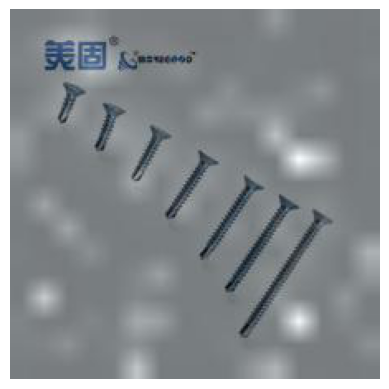

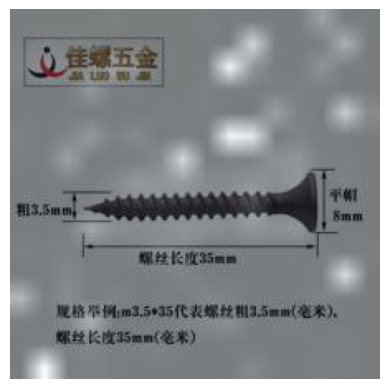

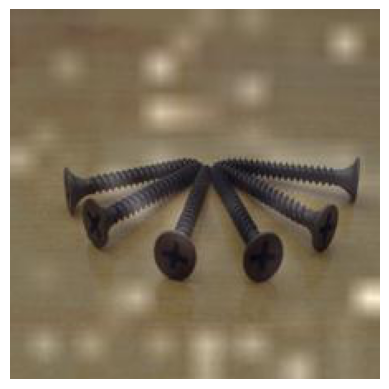

In [6]:
# retrive test
from matplotlib import pyplot as plt

retrieved = collection_images.query(query_texts=["Self-tapping Screw"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
retrieved

In [ ]:
# now the text DB
from chromadb.utils import embedding_functions
default_ef = embedding_functions.DefaultEmbeddingFunction()

text_pth = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if image_name.endswith('.txt')])
text_pth

In [8]:
list_of_text = []
for text in text_pth:
    with open(text, 'r') as f:
        text = f.read()
        list_of_text.append(text)

In [9]:
ids_txt_list = ['id'+str(i) for i in range(len(list_of_text))]
ids_txt_list

['id0',
 'id1',
 'id2',
 'id3',
 'id4',
 'id5',
 'id6',
 'id7',
 'id8',
 'id9',
 'id10',
 'id11',
 'id12',
 'id13',
 'id14',
 'id15',
 'id16',
 'id17',
 'id18',
 'id19',
 'id20',
 'id21',
 'id22',
 'id23',
 'id24',
 'id25',
 'id26',
 'id27',
 'id28',
 'id29']

In [10]:
collection_text.add(
    documents = list_of_text,
    ids =ids_txt_list
)

In [11]:
list_of_text

['佛甲草（Sedum lineare Thunb.）是景天科景天属多年生草本植物，无毛。茎高10-20厘米。花序聚伞状，顶生，疏生花，中央有一朵有短梗的花；萼片线状披针形。种子小。花期4-5月，果期6-7月。产中国云南、四川、贵州、广东、湖南、湖北、甘肃、陕西、河南、安徽、江苏、浙江、福建、台湾、江西。生于低山或平地草坡上。日本也有。佛甲草是一种耐旱性好的多浆绿草种，用于屋顶绿化，采用无土栽培，负荷极轻，可取代传统的隔热层和防水保护层。全草药用，有清热解毒、散瘀消肿、止血之效。',
 '六方瓶是一种用于储存和调配液体的玻璃器皿,通常由六个正六边形面构成,具有高度的透明性和精确的容积控制。',
 '冷焊机在国际上叫ESD，是由前苏联的专家应用类似于放电加工机的电路原理研究开发出来的。当初的加工机涂层厚度最大只能达30μm 左右，因此无法满足修补需要。之后，经过了大量的研究开发，提高了其输出功率，改进了焊枪结构和焊条材料成份。冷焊机是通过微电瞬间放电产生的高热能将专用焊丝熔覆到工件的破损部位，与原有基材牢固熔接，焊后只需经过很少打磨抛光的后期处理。',
 '古琴，又称瑶琴、玉琴、七弦琴，是中国传统拨弦乐器，有三千年以上历史，属于八音中的丝。古琴音域宽广，音色深沉，余音悠远。古籍记载伏羲作琴，又有神农作琴、黄帝造琴、唐尧造琴等传说； 舜定琴为五弦，文王增一弦，武王伐纣又增一弦为七弦；可见中华古琴文化的源远流长，博大精深。琴曲存世3360多首，琴谱130多部，琴歌300首。2003年11月7日，联合国教科文组织世界遗产委员会宣布，中国古琴被选为世界非物质文化遗产。2006年被列入中国非物质文化遗产名录。',
 '哈巴狗即巴哥犬，起源于中国。哈巴狗有很长的历史，其祖先在16世纪被东印度公司的贸易商带到欧洲，成为王室和贵族的宠爱。该犬体型小而壮实，它严肃的外表掩盖着欢快的性情和优秀的品质。哈巴狗非常聪明，性格外向，富有爱心，是忠实的伴侣犬，它适合新手犬主，对儿童和其他宠物很友好。该犬需要定期运动，但不要求太大生活空间，所以是公寓生活的理想犬种。',
 '奥利司他片，适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。',
 '巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为

In [ ]:
# LVM inference
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch
torch.manual_seed(1234)

# Note: The default behavior now has injection attack prevention off.
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

# use bf16
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, bf16=True).eval()
# use fp16
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, fp16=True).eval()
# use cpu only
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cpu", trust_remote_code=True).eval()
# use cuda device
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cuda", trust_remote_code=True).eval()

# Specify hyperparameters for generation
model.generation_config = GenerationConfig.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

# 1st dialogue turn
# query = tokenizer.from_list_format([
#     {'image': './projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/奥利司他片/奥利司他片_2_31.31.jpg'}, # Either a local path or an url
#     {'text': '请识别出图中的关键概念。'},
# ])
# response, history = model.chat(tokenizer, query=query, history=None)
# print(response)
# 图中是一名女子在沙滩上和狗玩耍，旁边是一只拉布拉多犬，它们处于沙滩上。


Loading checkpoint shards: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


In [ ]:
# 1st dialogue turn
image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/虎皮鹦鹉/虎皮鹦鹉_2_28.03.jpg"
# image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/蓝莓果酱/蓝莓果酱_1_33.25.jpg"
# image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/拉杆包/拉杆包_2_29.38.jpg"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "请详细介绍图中视觉概念的相关背景知识。"
def get_response(image_path, text, model_name="Qwen-VL"):
    query = tokenizer.from_list_format([
        {'image': image_path}, # Either a local path or an url
        {'text': text},
    ])
    response, history = model.chat(tokenizer, query=query, history=None)
    # print(response)
    return response
# get_response(image_path, concept_knowledge_description_prompt)
get_response(image_path, zero_shot_concept_recognition_prompt)

'图中是一只蓝白相间的鹦鹉，它有锋利的喙，圆溜溜的眼睛和覆盖在手上的细毛。'

In [18]:
import json
result_dict = {"asada": 1}
print(len(result_dict))
with open("QWen_VL_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

1


In [ ]:
# 
import os
import json
from tqdm import tqdm
test_path = "./mm_rag/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        image_path = os.path.join(sample_path, image_id)
        print(image_id)
        response1 = get_response(image_path, zero_shot_concept_recognition_prompt)
        response2 = get_response(image_path, concept_knowledge_description_prompt)
        print(response1)
        print(response2)
        result_dict[str(image_id)] = [response1, response2]

print(len(result_dict))
with open("QWen_VL_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

  0%|          | 0/30 [00:00<?, ?it/s]

蓝莓果酱_01.jpeg
图中是一杯蓝莓酱，白色的桌布上放着绿叶子的蓝莓，桌布上还摆放着两小瓶红果酱和绿叶子。
由于您没有提供具体的图片内容，我无法为您提供详细的背景知识。请提供相关的图片内容，我将很乐意为您提供详细的背景知识。
蓝莓果酱_02.jpeg
这是一瓶黑加仑果酱，产自俄罗斯。
图中展示的是一瓶黑加仑果酱。黑加仑，学名Ribes nigrum，是一种蔷薇科的植物，其果实通常为黑色或深蓝色，味道酸甜。这种果酱是由黑加仑果实和糖制成的，常常作为甜点食用，也可以用来做面包、蛋糕等烘焙食品。图中的果酱瓶用蓝色纸包裹着，上面还用麻绳绑着，这种包装给人一种清新、自然的感觉，与黑加仑果酱的口味相得益彰。
蓝莓果酱_03.jpeg
这是一瓶蓝莓果酱。
抱歉，您没有提供关于图中具体视觉概念的详细描述，我无法为您提供相关的背景知识。如果您能提供更多细节，我会很乐意帮助您。
蓝莓果酱_04.jpeg
这是一张蓝莓果酱的图片，其中一个是蓝莓果酱的玻璃瓶，另一个是蓝莓果酱的勺子，果酱上方还有绿叶点缀。
由于您没有提供具体的图片内容，我无法为您提供详细的背景知识。如果您有其他关于图片内容的问题，我会很乐意帮助您。
蓝莓果酱_05.jpeg
图是蓝莓果酱的产品图片，展示了蓝莓果酱在不同场景下的应用。
图中展示的是蓝莓果酱和蔓越莓果酱的图片。蓝莓果酱和蔓越莓果酱都是常见的果酱产品，它们通常被用于烘焙、涂抹面包、做冰淇淋等食品的制作中。这两种果酱都是由新鲜的水果经过加工制成的，其中蓝莓果酱主要使用蓝莓作为原料，而蔓越莓果酱则使用了蔓越莓。这两种果酱都含有丰富的维生素和矿物质，同时也是一种美味的甜品。
蓝莓果酱_06.jpeg
这是一瓶蓝莓果酱，上面有木勺。
在这张图片中，我们可以看到一个装满蓝莓果酱的玻璃罐子，放在一个木制的托盘上。图片的背景中，我们可以看到一个小铜碗和一个装有绿色和橙色的水果的铜碗。此外，还有一个装有蓝色果酱的六角形玻璃瓶。图片中还有一个木勺，上面印有红色的“VESCO”字样。这个场景给人一种温馨和舒适的感觉，让人想要品尝美味的果酱和水果。这个场景可能是在一个家庭的厨房中，人们正在准备早餐或茶点。
蓝莓果酱_07.jpeg


  3%|▎         | 1/30 [00:23<11:26, 23.68s/it]

图中是一个透明的玻璃碗，里面装着黑紫色的蓝莓果酱，而且已经搅拌均匀了。
图中展示的是一个白色的碗，里面装着黑色的蓝莓果酱。在图的左上方，有黑色的字组成的一句话：“自制蓝莓果酱”。这种果酱通常是通过将新鲜的蓝莓煮熟，然后添加糖搅拌均匀，再经过发酵制成的。自制的蓝莓果酱不仅健康，而且口感醇厚，酸甜适中，是很多人的早餐选择。
液晶电视机_7_29.42.jpg
这是一台三星的智能电视，具体型号为三星 UA50F6400AJ。从图片中可以看到，电视的屏幕是蓝色的，并且上面有水波纹的图案。电视的边框是银色的。在电视的屏幕的右上角，有“50”这个字样，可能是表示电视的屏幕大小。
抱歉，由于您没有提供图中的具体内容，我无法为您详细介绍概念相关的背景知识。请提供更多信息以便我为您提供帮助。
液晶电视机_5_25.92.jpg
图中是一个48英寸的长虹电视机，黑色的外壳，曲面的屏幕，正在播放一个穿蓝色衣服的男子用脚踢足球的场景。
图中是一个48英寸的长虹电视机，正在播放一个足球运动员用脚踢球的场景。背景是蓝色的天空，一个足球在空中飞舞，运动员身穿红色运动服，正在踢球。根据图中的视觉概念，我们可以了解到这是一台电视机，电视上正在播放一个体育节目，具体的体育项目是足球。长虹是电视机的品牌之一，这台电视机采用了48英寸的大屏幕，可以带来更好的观看体验。红色运动服的运动员在蓝色的天空下显得格外醒目，足球场上飞舞的足球也让画面更加生动活泼。总的来说，这是一幅展示电视机播放内容的画面，通过电视我们可以看到各种各样的节目和场景。
液晶电视机_01.jpeg
这是一台黑色的电视机，电视机的屏幕显示着一片黄色的树林，树林在水面上的倒影非常清晰，同时电视机的边框也是黑色的。
图中展示的是一台黑色的平板电视机，电视画面中展示的是我国西北地区的胡杨林，胡杨林在金黄色的秋季中，与蓝色的天空相映成趣。这台电视机的屏幕显示效果非常清晰，色彩还原度很高，显示的画面非常生动。这台电视机具有高清、平板、智能等特点，可以满足家庭的娱乐和信息需求。同时，电视机的黑色边框与电视画面中的胡杨林色彩形成了鲜明的对比，增加了视觉效果。
液晶电视机_02.jpeg
这是一台小米电视机，具体的型号无法从图片中得知。
对不起，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。请提供图片的描述或内容，我将很乐意帮助您分析图片中的

  7%|▋         | 2/30 [00:48<11:16, 24.17s/it]

这是一台海尔电视机，电视机的屏幕是黑色的。
图中展示的是一台海尔品牌的3D电视，其屏幕显示为黑色。海尔是一家知名的家电品牌，尤其在电视产品方面有着广泛的市场。3D电视是近年来家电行业的一个热门话题，它通过技术手段在电视屏幕上产生立体影像，提供一种更加真实的观看体验。用户需要佩戴3D眼镜才能观看3D电视，这是因为人眼在观看立体影像时，两只眼睛会接收到不同的图像信息，大脑会将这两组信息进行处理，形成一种立体的视觉效果。
红雀珊瑚_01.jpeg
这是一张关于多肉植物的图片，图片中展示了一种名为桃蛋的多肉植物，其在春天会开出浅粉色的花朵。
抱歉，您没有提供图中的具体视觉概念，所以我无法给出详细的背景知识。如果您能提供更具体的信息，如图片内容或关键词，我会很乐意帮助您。
红雀珊瑚_02.jpeg
图中可能是木芙蓉或玫瑰花。
抱歉，您没有提供图中的具体信息，我无法根据您的问题进行解答。如果您可以提供更多信息，我会很乐意帮助您。
红雀珊瑚_03.jpeg
图中是两朵红色的风车茉莉花，它们生长在浓绿色的叶子中。风车茉莉花的花瓣形状独特，像风车一样，因此得名。
由于图像内容没有提供足够的信息，我无法确定你想要了解哪个概念。请提供更具体的问题或概念，以便我为你提供更详细的答案。
红雀珊瑚_04.jpeg
这是一盆白鹭植物。白鹭植物又名白鹭竹、紫竹、彩叶竹，是一种常绿植物。其叶片边缘为红色，显得非常美丽。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。如果您能提供图片中的具体内容，我将很乐意帮助您进行详细的描述和解释。
红雀珊瑚_05.jpeg
这是一张龙骨植物的图片，它的茎是绿色的，上面长着5片浅绿色的叶子，这些叶子的边缘是粉色的。现在它的顶部开着多朵粉红色的花朵，这些花朵的形状像龙的尖角一样，非常美丽。
图中展示的是一种多肉植物的花穗，这种植物通常被称为龙骨或者龙骨科。龙骨是一种常见的室内植物，因其独特的外观和易于养护的特性而受到人们的喜爱。多肉植物是一种特殊的植物，它们的叶子储存了大量的水分，因此不需要频繁浇水。多肉植物的叶子通常很厚，形状和颜色各异，有的可以作为观赏植物，有的可以作为药材使用。龙骨的花穗通常是粉红色的，非常美丽，给人一种生机勃勃的感觉。这种植物的花穗在开花期间会吸引许多昆虫，如蜜蜂和蝴蝶，它们会帮助植物授粉。总的来说，龙骨是一种美丽而有趣的植

 10%|█         | 3/30 [01:09<10:13, 22.71s/it]

图中展示了一簇已经开放的粉红色花朵。这些花朵的形状独特，形状像小球，花瓣中间有一条短蕊，整体看起来非常可爱。这些花朵的花柄处还有尚未开放的花苞。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。如果您能提供图片的链接或者更详细的描述，我会很乐意帮助您。
紫根兰_01.jpeg
图中是一种名叫百合花的植物，它的茎部有许多鲜绿色的叶子，现在只有几朵花苞，其中一朵已经打开成红色的花朵，看起来非常漂亮。
抱歉，由于您没有提供图中的具体内容，我无法为您提供详细的背景知识。请提供更多的信息，我会很乐意帮助您。
紫根兰_02.jpeg
图中是红花,有的才展开两三片花瓣,有的已经全部展开,露出了嫩黄色的花蕊。这些花簇拥在一起，显得非常美丽。
图中展示的是 Clivia miniata，也被称为风车花或非洲百合。这是一种非常受欢迎的观赏植物，因为它的鲜艳色彩和独特的花朵形状。这种植物原产于南非，但现在已经广泛种植在世界各地的花园和室内装饰中。它的花朵有不同的颜色，包括红色、粉色、白色和黄色。每种颜色的花瓣都有黄色的斑点，这使得花朵更加鲜艳和独特。在图中，我们可以看到一些开放的花朵和一些含苞待放的花朵，这展示了 Clivia miniata 的生长和发展过程。这种植物在生长过程中需要适当的光照、水分和温度，以保证其健康生长和开花。
紫根兰_03.jpeg
图中是一簇盛开的红色的孤挺花，花瓣向上翘起，花蕊是黄色的。这种花的名字叫做吊钟花，也叫旱水仙、钟形花、露钟花等。
图中展示的是一簇盛开的红色孤挺花。这种花的学名是“Clivia miniata”，属于孤挺花科。它原产于南非，现在在世界各地都有广泛的种植。孤挺花因其艳丽的色彩和独特的花形而受到人们的喜爱。在许多文化中，孤挺花都被视为坚韧不拔的象征，因为它可以在艰难的环境中生存和开花。在室内养殖孤挺花时，需要注意为其提供适当的光照和水分条件，以保持其健康和开花。
紫根兰_04.jpeg
图中是一盆红花,被拍摄在了花盆中。这盆花的花瓣大且厚，中间有一条很短的蕊，花杆比较细。整体来看，这盆花的花瓣呈红色，花杆和叶子都是绿色的。
抱歉，由于您没有提供具体的图片内容，我无法为您提供详细的背景知识。如果您能提供一张图片，我将很乐意帮助您分析和解释其中的视觉概念。
紫根兰_05.jpeg
这是一盆莉莉花，目前有两朵红色的花瓣已经开放

 13%|█▎        | 4/30 [01:30<09:34, 22.11s/it]

图中是一簇红色的君子兰，它们的花瓣每片中间有一条很短的深色条，花茎和叶子都是绿色的。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。请您提供更具体的信息，例如图片中的内容。
奥利司他片_01.jpeg
图中是一个保健品的瓶子图片，上面是蓝色的字体，写着“奥利司他片”，下面的生产日期是2018年11月28日，保质期到2021年11月27日。
图中展示的是一个药品产品——“奥利司他片”的产品图片。这个产品是由广东九洲奥利医药科技有限公司生产的。根据产品说明书，奥利司他片是一种OTC药品，属于减肥药品，适用于肥胖人群的减肥治疗。其主要成分是奥利司他，这是一种强效的脂肪酶抑制剂，能够抑制脂肪的吸收，从而达到减肥的效果。一般情况下，成人一次服用30mg，一日3次，与饮食同时服用。需要注意的是，孕妇、哺乳期妇女、儿童、老年人以及有肝病、肾病等疾病的患者应在医生指导下使用。此外，该产品不宜与其它减肥药品同时使用。
奥利司他片_02.jpeg
图中是一个广告宣传页面，正上方写着“JARLLY 奥利可他片”下面链接着“抗肥胖治疗药”字样，左边是一个穿白色衬衫和蓝色西装的男模特，右边是一个穿白色上衣和蓝色牛仔裤的女模特，他们俩和中间的药品包装盒一起展示着这个抗肥胖治疗药。
图中是一个药品广告宣传页面，背景是蓝色，左上角写着“广告”，页面中间是一个白色长方形，里面是一个药品包装图，图上画着一个白人男性和一个黄种女性，他们穿着正装，背景是蓝色的高科技线条。在包装盒和人物旁边写着“LARLLY”、“奥利可他片”、“减肥药”、“抗肥胖治疗药”等字样，其中“LARLLY”是蓝色，其他文字是黑色。在页面的左下角有联系方式，其中“减肥热线”是绿色，“抗肥胖治疗药”是橙色。
奥利司他片_03.jpeg
图是奥利司他片的说明书，其中包含拼音“ORLISTAT”，中文名为“奥利司他”，是用于治疗肥胖症的药物。
图中展示的是一个白色盒子，上面写着“奥利司他片”，它是药品的一种，适用于“为抗肥胖医药非处方药”，由浙江正康制药有限公司生产。根据药品的使用目的和该药品的生产厂家，可以推测这是一种用于治疗肥胖的药物，患者可以在非处方药区购买。同时，也可以看出该药品的包装设计，白色盒子上印有药品名称和生产厂家的信息，方便消费者识别和购买。
奥利司他片_04.jpeg
图中是一个塑料透明瓶装的药片，

 17%|█▋        | 5/30 [02:04<11:01, 26.47s/it]

图中是一盒奥利司他片，是浙江海正药业有限公司生产的减肥药。
图中显示的是一个粉白色的药品盒子，上面印有“伊宁曼”、“奥利司他片”、“ORLISTAT TABLETS”、“3片/板,2板/盒”、“浙江海正药业股份有限公司”、“ZHEJIANG HISUN PHARMACEUTICAL CO.,LTD”等字样。根据这些信息，我们可以推测这是一个药品盒子，该药品名为“奥利司他片”，每盒中有2板，每板包含3片药物。浙江海正药业股份有限公司是该药品的生产商。奥利司他片是一种药物，可能用于治疗某些疾病或症状。然而，由于我
舰载直升机_9_30.9.jpg
这是我国第一艘航空母舰辽宁舰，停靠在辽宁大连。
抱歉，由于您没有提供图片内容的具体描述，我无法为您提供相关的背景知识。如果您能提供更具体的信息（例如图片中的内容），我将很乐意帮助您。
舰载直升机_4_28.84.jpg
这是我国第一艘航空母舰辽宁舰，停靠在大连港。2012年9月，中国航母完成首次海上试验任务，胜利返回大连港。这是我国第一艘真正意义的航空母舰，它的服役标志着中国海军从此拥有自己的航空母舰，这对于提高中国海军的作战能力具有重大意义。
抱歉，由于我是一个文字型的AI，我无法看到或理解图片内容。如果你能给我提供与图片内容相关的文字描述，我会很乐意帮助你。
舰载直升机_6_31.25.jpg
这是一张照片，显示了一架海军直-7运输直升机停在甲板上。
抱歉，您没有提供图中的具体信息，我无法根据您提供的信息来详细介绍概念相关的背景知识。如果您可以提供更多的信息（例如，图片中的具体内容和您希望了解的概念），我将很乐意帮助您。
舰载直升机_5_30.38.jpg
这是一架黑鹰直升机，是中国人民解放军海军陆战队和海军航空兵部队装备的主力舰载直升机，也是我军目前吨位最大的一款舰载直升机。
抱歉，由于您没有提供图片内容的具体描述，我无法为您提供详细的背景信息。能否请您提供一些关于该图片的详细信息，例如图片中的主体、场景、颜色搭配等？这样我才能更好地帮助您。
舰载直升机_3_25.47.jpg
这是一张关于英国皇室进行军事仪式的照片。在照片中，我们可以看到三架英国海军的阿古斯塔·韦斯特兰Lynx直升机在进行飞行表演。这些直升机在空中排成一行，下方则是英国海军的军舰。照片中还有人正在进行跳伞表演。
抱歉，由于您没有提供图片的具体内容，我无

 20%|██        | 6/30 [02:25<09:53, 24.75s/it]

这是一张米-8直升机的图片。米-8是苏联和俄罗斯制造的一种中型多用途直升机，广泛用于运输、搜索与救援、反潜、空中救护、森林灭火和VIP运输等多种任务。
抱歉，您没有提供关于图中视觉概念的详细描述，我无法提供相关的背景知识。如果您可以提供更多关于该图的详细信息，我会尽力帮助您。
虎皮鹦鹉_02.jpeg
这是一张两只鹦鹉在树上的照片。
在这张图片中，我们可以看到两只鹦鹉在一棵树的树枝上。从颜色上看，左边的鹦鹉主要是青色和绿色，而右边的鹦鹉则是蓝色和白色相间的。根据我的知识，我了解到这种鹦鹉通常被称为budgerigar，也被称为鹦鹉。budgerigars是鹦鹉科的一种鸟类，原产于澳大利亚。它们是非常受欢迎的宠物，因为它们的颜色鲜艳，性格活泼，容易与人类互动。此外，budgerigars还因其悦耳的鸣叫声而闻名。在这张图片中，我们可以看到两只鹦鹉在树枝上休息，这可能是因为它们正在享受阳光或者是在观察周围的环境。总的来说，这张图片展示了budgerigars自然的生活环境，同时也展示了它们的美丽和活力。
虎皮鹦鹉_03.jpeg
这是一只蓝色的长尾小鹦鹉，它站在一个圆形的绿色食物玩具上，玩具在银色的笼子上。小鹦鹉的喙部呈黄色，眼睛闭上了，它似乎在享受安静的时刻。
在这张图片中，我们看到的是一只虎皮鹦鹉正在一个金属笼子里进食。笼子的左侧有一个装有水的银色水碗，水碗里装有黄色的滤纸。笼子的右侧有一个装有干草的银色容器。图片的背景是白色的墙面。这只鹦鹉的羽毛大部分是蓝色的，羽冠是黄色的，眼睛是黑色的，喙是黄色的。它正在栖息在一个被啃过的苦涩的绿色甜椒上，这只鹦鹉的脚正好可以放在甜椒的籽上。这只鹦鹉正在享受它的食物和水。
虎皮鹦鹉_04.jpeg
这是一只色彩斑斓的长尾小鹦鹉，它正在栖息在一根细小的树枝上。小鹦鹉的羽毛大部分是绿色的，翅膀和尾巴的末端是黑色和黄色的，嘴巴是粉红色的，眼睛是灰白色的。它抓着树枝的脚是灰青色的，看起来非常健康。背景是虚化的，呈现出一种淡绿色。
在这张图片中，我们可以看到一只色彩斑斓的鸟儿停在树枝上。这只鸟儿的羽毛主要是翠绿色的，但是在眼睛周围、鸟的翅膀和尾巴上还有一些黄色的羽毛。鸟儿的嘴巴是黄色和白色的，同时它的翅膀在休息时折叠在身体的一侧。这只鸟儿抓着的树枝是棕色的，而背景则呈现出一种绿色和黄色的色调。从这些细节中，我们可以推测这只鸟儿可能是一只鹦

 23%|██▎       | 7/30 [03:05<11:23, 29.71s/it]

这是一只在笼子里的鹦鹉，笼子是金属网状的，内部栖木是竹子的，笼子外部的鸟是绿色和黄色的，它正在睡觉，头颈埋在身体里。
图中是一只色彩鲜艳的绿黄相间的鹦鹉，它正在一个有金属条的笼子里，笼子有两层，外面是金属网状的，里面是木制的，鹦鹉站在一个木制的杆子上，它的眼睛闭着，嘴巴缩在羽毛里，看起来正在休息。这种鹦鹉可能是绿budgie（绿鹦鹉），也被称为budgerigar，是一种常见的宠物鸟类，原产于澳大利亚。它们通常非常亲人，喜欢与人互动。然而，他们需要足够的空间来飞行和玩耍，否则可能会感到无聊和压抑。此外，他们需要新鲜的蔬菜和水果来保持健康。
佛甲草_8_28.06.jpg
这是一片麦田，在阳光下呈现出金黄色的色彩。
抱歉，由于图像内容的描述中没有提到具体的概念或主题，我无法提供相关的背景知识。如果你能提供更多的上下文信息或者详细描述，我会很乐意帮助你。
佛甲草_12_27.86.jpg
这是一张图片，显示了一片金边假俭的叶子。金边假俭是一种常见的园林植物，它的叶子形状为长圆形，边缘有锯齿，表面有光泽，颜色为深绿色。这种植物通常被用作观赏植物，也可以用于园艺装饰。
抱歉，由于您没有提供图中的具体信息，我们无法为您提供详细的背景知识。如果您能提供更具体的信息（例如，图中的植物、动物、物体等），我们将会很高兴为您提供相关信息。
佛甲草_7_27.94.jpg
这是一棵阴生植物，具体来说，它是一种叫做水生植物的植物，通常在水中生长。它的茎细长且丛生，叶子狭长且透明，仿佛涂了一层油脂。水生植物的种类繁多，包括浮萍、水葱、再力花等。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。能否请您提供更多的信息？
佛甲草_15_28.34.jpg
这是一张图片，显示了金雀花的花朵。金雀花是一种常见的观赏植物，也被称为金钟花。它的花朵呈金黄色，形状像小星星，非常美丽。
抱歉，由于您没有提供图中的具体内容，我无法为您提供详细的背景知识。能否请您提供更多的信息？
佛甲草_2_32.9.jpg
这是一簇亮绿色的丝状石松。它的形态像松树一样，因此得名丝松。这种植物的茎细长且多丝状，叶子从茎的基部生出，呈扇形。整个植物看起来非常漂亮，适合种植在室外花园或室内水族箱中。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。能否请您提供更多的信息？
佛甲草_13_31.3

 27%|██▋       | 8/30 [03:32<10:32, 28.77s/it]

这是一张图片，显示了一片生长在野外的金雀花。
抱歉，由于您没有提供图中的具体信息，我们无法为您提供详细的背景知识。如果您能提供更具体的信息（例如，图中的植物、动物、物体等），我们将会很高兴为您提供相关信息。
麻辣藕片_01.jpeg
图拍摄了装有红烧藕片的盘子，藕片呈淡黄色，有些地方烧成了暗红色，上面撒着许多葱花和芝麻，最后还有一双筷子放在盘子的边缘。
图中所展示的菜品是四川风格的辣子鸡，它是一道来自中国的传统川菜。辣子鸡以鸡肉为主要食材，配以多种香料和辣椒烹饪而成，具有麻辣鲜香的特点。在烹饪过程中，鸡肉被炸至金黄色，表面酥脆，内部鲜嫩。而辣子则是由干辣椒、花椒、葱姜蒜等香料炒制而成的酱料，其辣度适中，能够很好地衬托出鸡肉的鲜美。此外，辣子鸡还配以芝麻和葱花点缀，增加了菜品的色泽和口感。这道菜通常作为川菜中的主菜之一，深受食客们的喜爱。
麻辣藕片_02.jpeg
图中为一锅莲藕炒香肠，香肠切片与莲藕片、辣椒片、蒜片一起翻炒，装盘后顶部摆放一小把葱。
图中是一道菜，名为麻辣香锅，原料主要是莲藕和藕带。莲藕是夏天消暑解渴的好食物，含有丰富的维生素C和粗纤维，能清热凉血、健脾开胃、滋阴养胃。藕带中维生素C的含量是莲花的30倍，有清热解毒、止咳止呕、利尿消肿的功效。莲藕和藕带经过麻辣香锅的烹饪方式，既能去莲藕和藕带的涩味，又能突出它们的鲜香味，是一道夏天非常受欢迎的菜品。
麻辣藕片_03.jpeg
图中是一种中国菜，叫红烧莲藕，配米饭。
在这张图片中，展示了一盘红烧莲藕的特写。红烧是一种烹调技法，主要是将食材用油加热炒至焦香，然后加入适量的水或高汤，用小火慢慢炖煮至熟透，最后加入盐、鸡精等调料调味。红烧的烹调技法可以使食材更加入味，色泽红亮，口感香酥。在这张图片中，红烧过的莲藕色泽红亮，看起来非常美味。
麻辣藕片_04.jpeg
图中是一盘莲藕片，上面撒有干辣椒和花生米，看起来非常美味。
抱歉，由于您没有提供图的具体内容，我无法给出详细的背景知识。请提供更具体的信息，我将很乐意帮助您。
麻辣藕片_05.jpeg


 30%|███       | 9/30 [03:55<09:24, 26.88s/it]

图中是一盘泡椒藕带，它属于素食，是一道色香味俱全的菜。
图中展示的是一道叫做麻辣藕片的菜品。藕片是莲藕的切片部分，经过处理后可以进行多种烹饪。在这道菜品中，藕片被切成了薄片，可能是在烹饪前先用刀切或者使用削皮器削皮。然后，藕片被添加了麻辣调料，这可能包括辣椒、花椒、大蒜和其他香料。最后，藕片被放在一个白色的碗中，准备上桌供人享用。这道菜品的口感麻辣，味道鲜美，是很多中国人都喜欢的下酒菜或者配菜。
断肠草_12_33.22.jpg
这是水彩画《牛至》。牛至是一种菊科植物，原产于欧洲，现在世界各地都有栽培。它是一种常用的烹饪香料，具有独特的香气和味道，常用于制作意大利面酱、腌肉和烤肉等。牛至也具有药用价值，可以用于治疗感冒、咳嗽、喉咙痛等症状。
这幅图展示的是中药白术的植物图。白术为菊科植物多花白术或草白术的根茎。主产于浙江、安徽、四川、贵州、湖南、湖北、江西、福建等地。秋季采挖，洗净泥土，晒至干软，打成粗厚片，除去须根及茎叶，再晒至全干。以片大、色白、无黑心、无杂质、香气浓厚者为佳。白术是常用的中药，具有燥湿利水，健脾益气的功效，用于治疗痰湿内阻、脾胃虚弱引起的痰湿水肿、痰湿腹痛、脾胃虚弱、饮食不化等证。
断肠草_11_28.02.jpg
这是一张金银花的照片。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。能否请您提供更多的上下文信息？
断肠草_16_26.72.jpg
图中是夹竹桃的花朵，花朵呈粉红色，有白色的斑块，夹竹桃是一种观赏植物，常常被种植在公园、庭院、街道旁等地方。
图中可能拍摄的是忍冬属植物的花。忍冬属植物是一类蔓生植物，其花白色，有香味，花瓣5片，果实可以采集后熬煮得到一种药材“忍冬草”，具有清热解毒的功效。
断肠草_1_27.8.jpg
这是一张黄花的图片，黄花在绿叶的衬托下显得更加鲜艳。这张图片可能是通过电视新闻拍摄的，新闻的标题和下方的滚动字幕也说明了这一点。
抱歉，由于这是一个静态图片，我们无法提供与之相关的视频内容。图片中的信息是关于“台湾油桐花季”，报道中提到有5人因过敏紧急送医，其中4人是因为误食桐花所引起的不适，另1人则是对桐花粉过敏引起的症状。桐花季是台湾的赏花季节之一，但每年都会有因桐花过敏引发的医疗事件发生。
断肠草_9_26.72.jpg
图中是忍冬的花朵，忍冬又名金银花，是忍冬科忍冬属的植物。忍冬属植物是

 33%|███▎      | 10/30 [04:22<08:58, 26.93s/it]

图中画了一株植物，其中包含绿色的枝条、黄色的花、绿色的叶子，还有褐色的枝干。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。如果您能提供图片的详细内容，我将很乐意为您提供相关的背景知识。
职业赛车手_01.jpeg
这是一张丽贝卡·哈恩的写真照片。她穿着白色赛车服，坐在赛车的引擎盖上，右腿上放着一个头盔。
在图中，一个金发碧眼的女子坐在一辆白色赛车的引擎盖上，她身穿白色赛车服，腰间系着一根皮带，上衣上的彩虹条纹十分醒目。女子的左手拿着一个头盔，右手抓着赛车的把手，显得非常自信和专业。这幅画面展示了女子赛车手的风采和对赛车的热爱。
职业赛车手_02.jpeg
这是一张卡丁车比赛的图片，卡丁车比赛是一项非常刺激的赛车运动。
抱歉，由于您没有提供具体的图片内容，我无法为您提供详细的背景知识。请提供相关的图片内容，我会很乐意帮助您分析。
职业赛车手_03.jpeg
这是一名赛车手在赛车内的场景。我们可以看到他戴着头盔，坐在车里，准备参加比赛。
抱歉，您提供的图片内容与干扰信息中提到的 Rally driver 并不匹配。在图像中，我们看到的是一个穿着摩托车赛车服和头盔的男人，而不是一个 Rally driver。如果您有关于摩托车赛车手的背景信息想要了解，欢迎向我提问。
职业赛车手_04.jpeg
这是一张NASCAR赛车手Jeff Gordon的海报照片。照片中，Jeff Gordon身穿赛车服，站在一辆红色的赛车旁边，赛车停在一片水面上，背景是灰蒙蒙的天空，天空中还飘着一些白云。他的双臂交叉在胸前，露出自信的微笑。
图中是Jeff Gordon，美国NASCAR赛车手，四次NASCAR Cup Series的冠军得主。在他的职业生涯中，Gordon一共赢得了19次NASCAR Cup Series的冠军，是历史上最成功的NASCAR赛车手之一。他在2015年宣布退役，结束了自己22年的职业生涯。除了他的赛车成就，Gordon还因其出色的驾驶技术和对赛车事业的贡献而获得了多项荣誉。在他的职业生涯中，他一直以其专业精神和对赛车的热爱而受到人们的尊重。
职业赛车手_05.jpeg
图中是一个赛车手坐在黑黄相间的赛车后面，做出胜利手势的照片。
抱歉，由于您没有提供足够的背景信息，我无法准确地为您解读这张图片。如果您能提供更多上下文信息，我将很乐意为您提供更详

 37%|███▋      | 11/30 [04:44<08:04, 25.49s/it]

这是一张图片，展现了一位赛车手在赛道上庆祝胜利的场景。这位赛车手佩戴着头盔和手套，身穿赛车服，背后是观众席。他的左手比出了一个“V”的手势，象征胜利。
由于你没有提供特定的图片内容，我将根据图片内容提供一些可能的背景知识。

如果你指的是赛车手在赛道上庆祝的画面，那么这可能是在一次重要的比赛，如F1或WEC中取得胜利。赛车运动需要极高的驾驶技术、速度和策略，同时也考验赛车和驾驶员的耐力。在比赛中取得胜利通常需要在众多因素中做出最佳决策，并在压力下保持冷静和专注。获胜的赛车手会在终点线或特定的庆祝地点庆祝他们的胜利，这可能包括向观众挥手、做出标志性的手势或与团队成员庆祝。
车牌号码_8_27.19.jpg
这是一辆白色的小汽车，停在一块黑色的路面上。
抱歉，您没有提供图中的具体信息，我无法根据您的问题给出详细的解答。如果您可以提供更具体的问题，或者对图片内容的详细描述，我会尽力帮助您。
车牌号码_12_23.11.jpg
这是一张夜间的街头环境照片，照片中可以看到一辆黑色小汽车停在路边，车头部分已经严重变形，右侧有一个白色路锥。不远处还有一辆黑色车辆和一辆白色车辆。图片最左侧有一个身穿防弹背心的男子，头戴头盔，应该是保安员。图片最右侧有一个黑色木制方形物体，上面还有一个白色的POP。图片的正中上方是一段树木，夜晚看起来比较暗。
抱歉，由于缺乏足够的上下文信息，我无法准确理解你对“图中视觉概念”的要求。请提供更具体的问题或相关信息，我会尽力帮助你。
车牌号码_14_24.19.jpg
这是一张黑色的轿车停在街边的照片。
抱歉，由于您没有提供图中的具体信息，我无法为您提供详细的背景知识。请提供更多的上下文信息，我将很乐意帮助您。
车牌号码_3_27.34.jpg
图中是一个黑框的显示屏，上面有多个蓝色的中文字母和数字，以及有部分白色的字母和数字，无法判断这是在显示什么内容。
图中是一个电子显示屏，上面显示着多个航空器的编号。这些编号可能是为了帮助人们快速找到自己所乘坐的航班的登机口。在现代航空运输中，航班编号通常由两部分组成：航班号和航空公司代码。航班号通常是一个由字母和数字组成的字符串，而航空公司代码则通常是一个字母或者字母和数字的组合。这些编号被用来帮助人们识别和跟踪航班，特别是在航空公司的售票系统和机场的登机系统中。此外，这些编号也经常被用于航空公司的网站和应用程序

 40%|████      | 12/30 [05:03<07:00, 23.35s/it]

这是一张红色汽车的后部照片，该车停放在城市街道的人行道上，人行道上铺有不规则形状的灰色砖块。汽车后部从左到右有车牌、红色车灯、备胎、红色车尾部防护板。车牌号为“NA5945B”。
图中显示的是一辆红色的轿车，停放在城市街道上。从图片中可以看到，这辆车的颜色是红色，停放在城市街道的一侧。在图片的左侧可以看到另一辆车和一个行走的人。这张图片可能是在一个繁忙的城市环境中拍摄的，展示了车辆和行人在城市生活中扮演的角色。红色的轿车可能是该城市的居民或游客使用的交通工具之一。这张图片可能是在白天拍摄的，展示了城市街道的景象。
自攻钉_01.jpeg
图中是4个黑色的干壁螺钉，它们的头呈喇叭形状。
图中展示的是四颗黑色的干壁螺钉，也被称为自攻螺钉，它们呈斜向排列，且长短不一。干壁螺钉是一种常用在墙体内固定各种材料的螺钉，如石膏板、矿棉板等。它的头部呈阶梯形，可以更好地固定在各种材质的表面上。这种螺钉的长度可以根据实际需要来选择，以适应不同的安装需求。在选择干壁螺钉时，需要考虑到螺钉的材质、强度、耐腐蚀性等因素，以确保其能够承受相应的载荷，并具有较长的使用寿命。
自攻钉_02.jpeg
图中展示的是5颗金黄色的螺丝，它们大体上呈斜角状态排列，最左边的螺丝的头部朝向图片的左侧，而最右边的螺丝的头部则朝向图片的右侧。这些螺丝的材质是金属，颜色为金黄色，显得非常光滑亮泽。在螺丝的尾部，有一些带有塑料帽的螺丝，这些螺丝的材质也是金属，但颜色没有其他螺丝亮，显得有些暗色。
由于您没有提供图片的具体内容，我无法为您提供详细的背景信息。请提供更具体的问题或图片描述。
自攻钉_03.jpeg
图中是一组黄色的螺丝，它们被排列在白色背景上。这些螺丝的形状、颜色和材质都是一样的，它们的尾部呈圆角状。
图中展示的是黄色的自攻螺丝，排列在白色背景上。这些螺丝的特点是直槽、黄色、自攻，长度较长。自攻螺丝是一种特殊的螺丝，它通常用于在没有预先钻好孔洞的情况下将物品固定在表面上。由于它们具有自攻能力，因此可以将螺丝直接打入到材料中，无需使用额外的工具。这种螺丝通常用于木工、家具组装和其他需要在硬质材料上固定物品的场合。在图中，这些螺丝的长度较长，可能需要使用特定的工具或技巧来安装，以确保螺丝的稳定性并避免损坏材料。
自攻钉_04.jpeg
图中展示了五颗银色的螺丝，它们的长度和攻丝方式不同，且放在光滑的银色桌子

 43%|████▎     | 13/30 [05:26<06:35, 23.27s/it]

图中是一组彩色的螺纹钉，它们的长度不一，最长的钉子超过了图片的长度限制，从图片中看，有六根钉子呈现在蓝色的背景上。
图中展示的是几颗不同长度的金属钉子，它们的颜色是金属色，可能经过了电镀处理。这些钉子的长度和颜色各异，有的是沉头，有的是尖头。它们被斜着放在一个蓝色的表面上，似乎是在进行一个展示或者分类。这些钉子可能是用来进行各种不同的安装或者维修工作，例如钉在木头或者其他材料上。它们的长度和形状不同，是为了适应不同的工作需求和材料。
碳酸氢铵_01.jpeg
这是一张聚丙烯酰胺的图片。
由于您没有提供具体的图片内容，我将以一种通用的方式进行描述。

在图中，我们可以看到一个白色粉末的堆。这个粉末可能是多种物质，具体是什么需要进一步的信息。然而，由于它是白色的，我们可以推测它可能是一种颗粒状的粉末，可能是某种化学物质、食品添加剂或其他工业原料。它的形状是圆的，这可能是因为它是一种易于堆积和储存的形状。然而，我们不能仅凭这个图像就确定这个粉末的具体性质和用途，因为这需要更详细的背景信息和实验数据。
碳酸氢铵_02.jpeg
根据图片内容，这是一袋丰喜牌的磷酸氢铵，采用的是白色塑料袋包装，封口为绿色。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。能否请您提供一张图片，我将很乐意帮助您分析。
碳酸氢铵_03.jpeg
图中是一堆白色的粉末，放在一个白色的盘子中，盘子放在一个黑色的桌子上。
图中展示的是一堆白色的粉末。这种粉末可能是某种产品的原材料或者是某种化学物质。由于没有更多的上下文信息，我们无法确定这种粉末的具体性质和用途。白色的粉末在我们的日常生活中很常见，它们可能是食品添加剂，也可能是工业生产中的原料。在科学研究中，白色粉末也可能是某种化学物质的样品。总的来说，白色的粉末在我们的生活中扮演着很多角色，它们的性质和用途各不相同。
碳酸氢铵_04.jpeg
图中是袋装的碳酸氢铵，绿色袋子，红色字体，碳酸氢铵是化学式为NH4HCO3的化合物，有白色细粉状固体、无色结晶性粉末，易溶于水，水溶液为弱酸性。
图中是一袋50kg的硫酸氢铵，它是绿色的袋子，上面印有红色和黄色的字。硫酸氢铵是一种化学物质，是一种常用的肥料，特别是在种植花卉和蔬菜时。它含有氮、硫、磷等多种营养元素，可以为植物提供生长所需的营养。在农业中，肥料是非常重要的，它可以促进植物的生长和发

 47%|████▋     | 14/30 [05:48<06:08, 23.05s/it]

图中是袋装的碳酸氢铵，这是一种白色晶体，常用作肥料。
很抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。如果您能提供更具体的信息（例如，图片中的内容），我将很乐意帮助您。
六方瓶_01.jpeg
这是一只蓝色和白色的花瓶，它有六边形的形状，有一些蓝色的花纹和白色的纹路。
图中展示的是一件蓝色和白色中国瓷器花瓶，花瓶的形状是六角形的，这种形状的花瓶在古代陶瓷艺术中比较少见，因此更显独特和珍贵。六角形的设计可能代表了中国古代对于平衡和和谐的追求，同时也增加了花瓶的稳定性和视觉冲击力。花瓶的蓝色和白色颜色搭配经典，蓝色在中国传统文化中象征着深远、稳重、智慧、信仰以及高尚，而白色则象征着纯洁、和平、简洁、高雅，这两种颜色的结合使得花瓶更具有艺术感和文化内涵。花瓶的两侧中间位置有两个用蓝色绘画的兽形把手，把手的形状独特，增加了花瓶的实用性。花瓶的底部没有注明年代和款识，可能是比较早期的作品，因此更具有历史价值和收藏价值。
六方瓶_02.jpeg
这是一只粉彩山水纹六角瓶，属于清朝乾隆年间的产品。它采用的是粉彩绘画技法，瓶身上的图案非常精美，描绘了山河景色。瓶身是红色的，六边形棱角，瓶高53厘米，口径19厘米。整个瓶身光滑细腻，色彩鲜艳，是一件非常珍贵的瓷器艺术品。
图中展示的是一件清朝时期的红色六角花瓶。这件花瓶的特别之处在于它的颈部装饰有颜色鲜艳的彩绘，上面描绘了山石树木等自然景色，而这些彩绘的工艺难度较大，需要精细的绘画技巧和熟练的绘画工具。这种彩绘技术在中国传统陶瓷艺术中非常常见，通常用于装饰花瓶、盘子等陶瓷制品。这种彩绘技术的使用，不仅增加了花瓶的艺术价值，也展现了古代中国陶瓷艺术家的高超技艺。
六方瓶_03.jpeg
这是一件蓝色的瓷器瓶子，它有着蓝色的釉面，独特的形状和设计，瓶口窄，底部宽，整体呈现出一种艺术感。
图中展示的是一件蓝色的瓷器花瓶。花瓶是一种常见的家居装饰品，通常用于存放鲜花或其他装饰物。这件花瓶的设计风格是蓝色的，这种颜色的选择可能是为了吸引人们的注意力，并为室内装饰增添一种宁静和深远的感觉。蓝色在视觉上通常与海洋、天空和水等自然元素相关联，因此它能够创造出一种平静和放松的氛围。此外，这件花瓶的形状是六角形的，这种设计使得花瓶看起来更加独特和现代。总的来说，这件花瓶的设计结合了传统和现代的元素，使其成为家居装饰中的一件独特作品。


 50%|█████     | 15/30 [06:29<07:07, 28.53s/it]

这是一张蓝色和白色的花瓶图片。花瓶呈方形，整体是蓝色和白色的，没有其他颜色。花瓶的颈部装饰着蓝色的图案，具体图案无法辨认。花瓶的底部长方形底座是白色的，整体看起来非常美观。
图中展示的是一个蓝色和白色装饰的陶瓷花瓶。这种花瓶在中国非常常见，是中国传统工艺品之一。中国有着数千年的陶瓷制作历史，在这个过程中，陶瓷艺术得到了极大的发展和创新。中国的陶瓷制品以质地细密、色泽丰富、造型多样而闻名于世，花瓶就是其中一种非常有代表性的产品。

花瓶在中华文化中也有特殊的意义。它不仅是一种实用的器皿，还常常被用作装饰和表达情感的工具。在家居装饰中，花瓶常常被用来增添室内的生机和美感，人们会用各种各样的花卉来装饰花瓶，以此来表达对美好生活的向往和追求。

此外，花瓶在一些特殊场合也被赋予了特殊的含义。例如，在婚礼上，新郎新娘会互赠花瓶，象征着两人之间的美满婚姻和永恒的承诺。在一些艺术展览和拍卖会上，高级的花瓶作品更是被看作是艺术品收藏的珍品，价值连城。

总的来说，图中的蓝色和白色装饰的陶瓷花瓶是中国传统工艺美术的代表之一，它既是一种实用的器皿，也是一种表达情感和美感的装饰品，同时在特定的场合中还被赋予了特殊的含义。
哈巴狗_01.jpeg
这是一只哈巴狗，它有着斗鸡眼、吐着舌头，穿着红色的领结，坐在地上。
抱歉，由于您没有提供图片的具体内容，我无法为您提供相关的背景知识。如果您能提供更详细的信息（例如，图片中的动物或物体），我将很乐意帮助您。
哈巴狗_02.jpeg
这是一只哈巴狗，它有着可爱的短腿和大眼睛，黑色的鼻头和脖子，脖子上挂着一个黑色的项圈，哈巴狗的舌头也伸了出来，看起来非常可爱。
抱歉，由于您没有提供图片内容的具体信息，我无法为您提供相关的背景知识。如果您能提供更具体的信息，例如图片中的对象、场景或主题，我将很乐意为您提供相关信息。
哈巴狗_03.jpeg
这是一只小鹿犬和哈巴狗的混种幼犬，名叫布丁。它有褐色的皮毛，黑色的鼻子和白色的胸部。现在它正坐在地上，面向前方，看着镜头。
这是一种混合犬，起源于中国，但已经灭绝。它是由一种拉萨犬和一种哈巴狗杂交而成。由于其稀有性和独特的外观，它在中国非常受欢迎。然而，由于其易患眼病和呼吸系统问题，它在中国被禁止繁殖。
哈巴狗_04.jpeg
这是一张趴在地毯上的巴哥犬的照片。照片中的巴哥犬有黑色的耳朵，皱纹较多，眼神呆萌，看起来非

 53%|█████▎    | 16/30 [06:48<05:56, 25.45s/it]

这是一只小胖乎乎的哈巴狗，它正在草地上趴着。
在这张图片中，一只小胖乎乎的哈巴狗正趴在草地上。它的舌头微微伸出，眼神呆萌，看起来非常可爱。哈巴狗是一种古老的犬种，起源于埃及，以其友善、忠诚和聪明著称。它们通常体型较小，肩高约30-32厘米，体重通常在20-28公斤之间。哈巴狗的毛发短而密，通常为黑色、棕色或灰色。它们的尾巴很卷，给人一种非常可爱的感觉。在这张图片中，这只哈巴狗趴在草地上，舌头微伸，眼神呆萌，非常符合人们对于这种犬种的普遍印象。
读卡器_8_30.1.jpg
这是一张白色USB读卡器的照片，它用于读取IC卡。
由于图像内容的描述中提到这是一个“白色读卡器”，并且有“USB接口”，并且有一个“数据线”，因此，我们可以推测这可能是一个用于读取数据的设备，可能是读卡器或者U盾等。

读卡器是一种用于读取存储在卡片中的数据的设备，通常用于读取各种存储卡中的数据，如SD卡、TF卡等。读卡器通常有USB接口，可以将读取到的数据通过数据线传输到计算机中。

U盾，全称是“USB Key”，是银行等金融机构推出的一种用于网上银行交易的安全产品。它通常具有密码保护功能，只有输入正确的密码才能进行交易。U盾通常通过USB接口与计算机连接，传输数据。

因此，根据图像内容的描述，我们可以推测这可能是一个读卡器或者U盾等设备。
读卡器_5_31.77.jpg
这是一张黑灰色的手机照片，上面有一款应用叫做“安全小卫士”的图标。
抱歉，由于您没有提供具体的图片内容，我无法为您详细解读概念相关的背景知识。如果您能提供更具体的信息，我将很乐意帮助您。
读卡器_16_29.9.jpg
这是一款名为“硅胶保护套”的产品，它被设计用于保护和提供额外的保护给您的设备。它采用透明硅胶材质制成，可以完全包裹您的设备，提供全方位的保护。
对不起，由于缺乏足够的上下文信息，我无法理解您提到的“视觉概念”。请您提供更多的信息或详细说明，以便我能够更好地回答您的问题。
读卡器_3_33.16.jpg
这是一本黑色的圣经，封面上印着银色的字“Bible”和“KJER”。
抱歉，由于您没有提供具体的图片内容，我无法为您提供相关的背景知识。如果您能提供图片的详细内容，我将很乐意为您提供相关的背景知识。
读卡器_12_32.72.jpg
图中是一个黑色的证件读卡器，它有一个屏幕，用来显示读卡的结果。这个读卡器应

 57%|█████▋    | 17/30 [07:10<05:19, 24.59s/it]

这是一款黑色的读卡器，品牌是Microsoft Windows，类型为USB Reader。
抱歉，由于您没有提供图片的具体内容，我无法为您详细介绍相关背景知识。请提供更具体的问题或图片描述。
古琴_7_32.25.jpg
这是一张古琴的照片。古琴，又称瑶琴，是中国传统乐器中的一种，属于拨弦乐器。它的形状类似于长条形的共鸣箱，上面有七个到九个音位，通常用指甲或特制的拨子来弹奏。古琴的声音深沉而悠扬，被誉为“中国乐器之首”，在中国文化中有着重要的地位。
图中展示的是两种不同的古琴，一种是伏羲式，另一种是仲尼式。古琴是中国传统的弹拨乐器，被誉为“国乐之魂”，具有悠久的历史和丰富的文化内涵。据史书记载，古琴在公元前3000年到公元前2000年之间就已经出现，是中国最早的弹拨乐器之一。古琴的音色深沉、悠扬，具有很高的艺术表现力，被广泛用于独奏、重奏、合奏等各种场合，是中国传统音乐的重要组成部分。古琴的制作工艺非常精细，需要经过选材、制作、漆饰、刻字、装饰等多道工序，每一道工序都需要制琴师的精细操作和丰富的经验。古琴的形状一般为长条形，上面有七根到十三根弦，演奏时需要用拨子拨动琴弦，产生美妙的音乐。古琴的音域宽广，可以演奏出丰富多样的音色和和弦，是中国音乐的瑰宝。
古琴_9_32.47.jpg
这是一张关于红木整板凳子的图片。这张图片展示了从不同角度看红木整板凳子。整板凳子是一种传统的木质坐具，通常用于在家中或公共场所休息。这张图片中的凳子看起来非常坚实和耐用，似乎是由红木木材制成的。整板凳子的设计简单而实用，它的出现反映了人类对舒适和实用性的追求。
抱歉，由于您没有提供图片内容的具体描述，我无法为您提供详细的背景知识。请提供更具体的信息，如图片中的具体内容，或者与图片相关的问题，我会尽力帮助您。
古琴_4_32.2.jpg
这是一张古琴，属于古乐器之一，属于八音中的弦音。古琴音色深沉，具有悠久的历史和深厚的文化内涵，被尊为“国乐之父”。
图中展示的是古琴的特写照片，焦点落在中间的琴弦上。在图片的左上方可以看到一个黑色的壶，其样式似为古代的茶壶。古琴和茶壶的出现，让人想起中国的传统文化。古琴，作为中国传统的弹拨乐器，有着几千年的历史，被誉为“中国乐器之首”。它的音色深沉，能够表达出丰富的情感和意境。而茶，是中国的国饮，有着几千年的饮用历史。茶文化与琴瑟、书法、围棋并称为中国的

 60%|██████    | 18/30 [08:11<07:05, 35.43s/it]

这是一张古筝的照片。古筝是一种中国传统弹拨乐器，它的外形为长条形，木制，有21根弦，通常用雁羽或者马尾制成。在这张照片中，可以看到古筝的头部和部分琴弦。
这张图片展示了一个古筝的特写镜头。古筝是一种中国传统弹拨乐器，通常有21根弦，每根弦代表一个音。图片中的古筝头部呈棕色，材质可能是梧桐木，这种木材被广泛用于制作古筝。从图片中可以看到，古筝的表面光滑，线条流畅，给人一种优雅和古老的感觉。古筝的音色优美，被誉为“中国乐器之王”，在中国传统音乐中占有重要地位。
银鱼炒蛋_01.jpeg
图中为一盘炒鸡蛋和鱿鱼，盛于蓝色花纹的盘中，放在棕色的木桌上。
在这张图片中，我们看到的是一个蓝色花纹的陶瓷盘子，盘子中放着一份炒鸡蛋和鱿鱼。鸡蛋是黄色的，炒得有些碎，鱿鱼是白色的，炒得也很碎，两者混合在一起，形成了一个黄色和白色的混合物。在深棕色的木桌上，有一个圆形的白色盘子，上面有蓝色的花纹。这是一份看起来很美味的家常菜。
银鱼炒蛋_02.jpeg
图中是一盘银鱼炒蛋，蛋液炒得碎碎的，银鱼也比较多，点缀着葱花点缀，看起来很美味。
银鱼又名银鱼，学名银鱼，属鱼类，栖息在沿海地区，以浮游生物为食，体形略扁，呈银白色，肉质细嫩，味道鲜美，为海味珍品。银鱼炒蛋，是一道色香味俱全的汉族名菜，属于家常菜谱。此菜蛋花细嫩，鱼肉鲜美，汤汁浓郁，营养丰富。
银鱼炒蛋_03.jpeg
图是一盘炒鸡蛋和洋葱的特写，鸡蛋炒得散散的，洋葱有白色的，也有黄色的，都放在一个白色的盘子里，放在一个棕色的桌子上。
抱歉，您提供的图片内容是关于炒蛋和洋葱，放在一个白色深碗中。这张图片并没有包含其他的食物，如面条和菠菜。如果您有关于这个场景的其他问题，我会很乐意帮助您。
银鱼炒蛋_04.jpeg


In [ ]:

# sat, transformers=4.33.2
save_path = "./cache/huggingface/hub/models--THUDM--visualglm-6b/snapshots/f4f759acde0926fefcd35e2c626e08adb452eff8/"
from transformers import AutoTokenizer, AutoModel

print("model loading...")
tokenizer = AutoTokenizer.from_pretrained(save_path, trust_remote_code=True)
model = AutoModel.from_pretrained(save_path, trust_remote_code=True).half().cuda()
# response, history = model.chat(tokenizer, image_path, "描述这张图片。", history=[])
# print(response)
# response, history = model.chat(tokenizer, image_path, "这张图片可能是在什么场所拍摄的？", history=history)
# print(response)
def get_response(image_path, text):
    response, history = model.chat(tokenizer, image_path, text, history=[])
    # print(response)
    return response

model loading...


[2024-05-07 03:18:36,933] [INFO] [RANK 0] > initializing model parallel with size 1
INFO:sat:[RANK 0] > initializing model parallel with size 1
[2024-05-07 03:18:36,936] [INFO] [RANK 0] You are using model-only mode.
For torch.distributed users or loading model parallel models, set environment variables RANK, WORLD_SIZE and LOCAL_RANK.
INFO:sat:[RANK 0] You are using model-only mode.
For torch.distributed users or loading model parallel models, set environment variables RANK, WORLD_SIZE and LOCAL_RANK.
/usr/local/anaconda3/envs/zzw/lib/python3.8/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Loading checkpoint shards: 100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


In [51]:
print(model)
del model
torch.cuda.empty_cache()

In [54]:
print(model)

ChatGLMForConditionalGenerationWithImage(
  (transformer): ChatGLMModel(
    (word_embeddings): Embedding(130528, 4096)
    (layers): ModuleList(
      (0): GLMBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attention): SelfAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
        )
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): GLU(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)
        )
      )
      (1): GLMBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attention): SelfAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value):

In [ ]:
# 
import os
import json 
from tqdm import tqdm
test_path = "./mm_rag/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        image_path = os.path.join(sample_path, image_id)
        print(image_id)
        response1 = get_response(image_path, zero_shot_concept_recognition_prompt)
        response2 = get_response(image_path, concept_knowledge_description_prompt)
        print(response1)
        print(response2)
        result_dict[str(image_id)] = [response1, response2]

print(len(result_dict))
with open("VisualGLM_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

  0%|          | 0/30 [00:00<?, ?it/s]

蓝莓果酱_01.jpeg


Specify both input_ids and inputs_embeds at the same time, will use inputs_embeds


这是一杯蓝莓果酱，由新鲜的蓝莓和蜂蜜混合而成。它看起来既美味又令人垂涎欲滴，让人不禁想要品尝一口。在餐桌上放置着三杯饮料，每杯都配有一片薄荷叶作为装饰。这场景充满了浪漫的气息，仿佛置身于一个美丽的花园之中。
蓝莓果酱是一种由新鲜蓝莓制成的甜酱或果冻，通常用于烹饪、烘焙和甜点制作中。它的主要成分是水和蓝莓果汁，添加一些糖和其他天然成分来增加口感和风味。这种果酱通常呈现出深紫色或浅蓝色的颜色，其外观非常美丽，非常适合作为礼物或美食享用。
蓝莓果酱_02.jpeg
这是一瓶蓝莓果酱，由紫色包装和蓝色盖子组成。它被放在白色背景下的盘子上。 蓝莓果酱是一种美味的天然食品，通常用于制作各种甜点、糕点或三明治等美食。它的味道独特而令人愉悦，是许多人们喜爱的美味选择之一。
蓝莓果酱是一种由新鲜蓝莓制成的甜味和果味混合的果酱，通常被用于各种菜肴、甜点或零食中。它通常是用罐装或瓶装来保存，颜色为紫色或蓝色。这种果酱在制作过程中使用天然浆果，如蓝莓、覆盆子等，并添加糖和其他调味料以增加风味。此外，一些品牌会将其包装成礼品或纪念品，使其更易于携带和使用。
蓝莓果酱_03.jpeg
这是一瓶蓝莓果酱，上面覆盖着一片面包。它被放在白色盘子上，旁边是一杯橙汁和一块饼干。 蓝莓果酱散发着浓郁的香味，令人垂涎欲滴；面包则呈现出金黄色的光泽，让人食欲大开。 橙子则是清新可口，果汁四溢，仿佛在向人们诉说着它的甜蜜与美味。 这样的组合，让人们不禁沉浸在这个美妙的时刻里，享受这份美食带来的快乐。
蓝莓果酱和面包片的组合代表着一种独特的食品文化，它以其独特的口感、风味以及外观而受到广泛的欢迎。这种食物通常被用于早餐或午餐，因为它既美味又健康。在蓝莓果酱中，新鲜的浆果被提取并混合成浓稠的酱汁，其味道清新甜美，令人回味无穷。而在面包片中，加入蓝莓酱后，会呈现出更加脆爽的口感，使整道菜肴更具吸引力。此外，蓝莓果酱和面包片的搭配还可以提供丰富的营养，如蛋白质、维生素和矿物质等，有助于维持身体健康。
蓝莓果酱_04.jpeg
这是一瓶蓝莓果酱，旁边放着一把勺子。它被放在白色盘子上，上面放了一些蓝莓和水果。图片中的瓶子里盛着蓝莓酱，周围是一些新鲜的蓝莓和水果。这种果酱通常用于烹饪或作为甜点的一部分。它是美味而健康的，可以增强味觉体验并提高整体健康水平。
图中的视觉概念是一个装满蓝莓果酱的罐子和一把勺子放在一张白色的桌子上

  3%|▎         | 1/30 [00:37<18:04, 37.39s/it]

这是一道黑莓果酱，由黑莓、蜂蜜和燕麦混合而成。它看起来很漂亮，金黄色的色泽让人垂涎欲滴。将勺子插入碗中，可以轻松地品尝美味的酱汁。它还富含抗氧化剂和维生素C，有助于促进身体健康。它是一份美味而健康的小吃选择，适合早餐或午餐食用。
黑莓果酱是一种由黑莓和蜂蜜混合制成的甜味酱汁或甜点，通常用于制作蛋糕、糕点等食品。这种酱汁的风味独特，口感甜美而微酸，具有浓郁的果香味道。在烹饪中，它常常用来装饰面包、饼干或其他甜品，增加其美味度。此外，它也可以作为独立的小吃，单独食用或作为礼物送给亲朋好友。
液晶电视机_7_29.42.jpg
这是一张平板电视的图片，上面显示着蓝色和黑色交替的图案。图案中央是一个圆形的水滴形状，周围则是一些类似花朵的细节装饰。背景是白色或灰色的天空。该图像没有文字或其他内容。 这幅图片展示了一个现代、高端的设备，拥有独特的设计。
这张图片展示了一台平板电视放在白色背景下。这台电视采用了黑色面板和蓝色LED灯带设计。屏幕上方有一个圆形的图标显示着“智慧”或“语音助手”。电视后面有一扇金属门，上面挂着一个黑色的帘子。
液晶电视机_5_25.92.jpg
这张图片展示了一台平板电视，屏幕上显示着一个男人正在观看电视节目。屏幕背景是深色的，并点缀着白色线条和图案。电视拥有四个扬声器，并且配备了一个可旋转支架以方便用户调整角度。图像中的男人穿着黑色衣服，戴着帽子，看起来有些紧张或专注地看着电视。
这张图片展示了一台40英寸的LED电视屏幕播放着一名男性运动员的广告视频。该图像的背景是深色的、模糊的玻璃和白色的天空。电视屏幕上显示的图像清晰明亮，配合黑色边框，使得整个画面看起来整洁而简洁。
液晶电视机_01.jpeg
现代电视，连接着自然之美。它静静地躺在湖泊中，沐浴在金色的秋季里。它是一台智能的平板电视，拥有独特的外观和功能。它的屏幕采用先进的液晶技术，清晰明亮的图像展现出细腻的色彩和流畅的画面感。而内置的智能系统则让操作更加简单便捷，让用户轻松享受娱乐生活。
现代电视屏幕放置在湖泊旁边，背景是树木和树叶，这场景充满了自然之美。它代表着现代科技与自然环境的融合，展现出一种独特的美感。人们可以欣赏美丽的景色、享受舒适的生活，而科技的发展也促进了人类的进步和发展。
液晶电视机_02.jpeg
电视屏幕，静静地躺在海滩上。它被海浪拍打着，在蓝天下熠熠生辉。大海的蓝色与天

  7%|▋         | 2/30 [01:03<14:15, 30.55s/it]

这是一台平板电视，黑色屏幕和白色背景。它静静地躺在白色的桌面上，似乎在等待它的主人的到来。它是一台现代设备，拥有先进的技术，能够带来卓越的观看体验。它有着清晰的画面、流畅的播放，以及强大的功能，为人们带来了无限的快乐与享受。
平板电视屏幕放置在白色背景下，黑色屏幕上显示着黑色的字体和图片。这一幅场景充满了现代科技感和现代感，展现出一种独特的美感。在现代化的家庭中，这种设备通常被用于娱乐、教育或工作等方面，其功能十分强大且易于操作。
红雀珊瑚_01.jpeg
一朵红色花朵的特写，上面有许多鲜艳的粉红色。这朵花生长在绿叶丛中。花朵上有一些小的红色和绿色的花瓣。图片展示了一朵花的细节特征，包括其颜色、大小和形状。这些细节突出了花朵的美丽和美丽。花朵周围的绿色叶子为整个场景增添了自然和谐的氛围。
这张图片展示了一朵鲜花的特写，其中许多红色和绿色的花瓣组成一个鲜艳的花蕊。这些花朵位于植物的叶子上，表明它们可能生长在花园或公园里。这些花朵具有美丽的颜色、精致的花朵形状以及独特的外观，吸引了观察者的注意。此外，这些花朵在绿色的背景中突出显示，进一步突出了它们的美学价值。
红雀珊瑚_02.jpeg
这是一棵植物，它生长在砖墙的一侧。它的叶子和花朵是粉红色和绿色的。它还有一个分支从花茎上伸出来。图片中可以看到一些树叶在微风下摇曳着。这棵树可能是一个盆栽或花园中的装饰性植物。
这幅图片描绘了一棵植物在砖墙或石墙上生长的景象。这棵树的叶子呈现出粉红色和白色相间的颜色，非常美丽。它可能是一颗花树、灌木或蔷薇科的植物，其花朵通常具有鲜艳的颜色和美丽的外观。此外，图片中的背景也展示了一种独特的美感，可能是一种建筑结构或者城市景观的一部分。这种植物的鲜艳色彩和美丽的花朵以及它的背景的完美融合为这幅画增添了一份诗意和美感。
红雀珊瑚_03.jpeg
这张照片显示了一朵红色花朵的特写，它生长在绿色的植物上。花朵靠近叶子，可能正在生长或开放。花朵周围还有绿叶和树枝环绕着它们。这看起来像是一棵花树的一部分。图片中的花朵可能正在开花，或者只是刚刚开放。
在图片中，一朵粉红色的小花生长在一片绿色的叶子上，叶子上有许多小分支和花朵。这种植物通常被称为“仙人掌”或“仙人球”，因为它们具有类似仙人掌的特征，如高而细的茎、刺状叶以及独特的花形。这些特征使它们成为自然生态系统中的一个独特组成部分，为许多动物提供食物来

 10%|█         | 3/30 [01:34<13:54, 30.90s/it]

这张照片展示了一朵带有粉色和白色花蕾的多肉植物。它生长在木桌上，靠近窗户或门。花朵在绽放中散发出清新的气息。背景是一张棕色桌子。图像中的植物可能是一种被称为“仙人掌”的植物。它的花通常有鲜艳的颜色、独特的形状和分支。
这张图片展示了一朵带有粉色和白色花朵的多肉植物上，有五只绿色的芽。这些芽是植物的繁殖过程中的一部分，通过从母本植物中长出新的枝条来增加植物的数量和生长。在多肉植物上长芽通常需要适当的环境、营养供应以及合适的温度等条件才能成功发芽。
紫根兰_01.jpeg
这是一盆盆栽植物，它位于一个砖墙旁边。它的花是红色的和白色的。图片中还有其他盆栽植物。它们可能正在欣赏它们的美丽或为花园增添色彩。照片展示了不同的花卉和植物，它们在不同的环境中展示着独特的魅力。
这张照片展示了一簇植物，包括花朵和叶子，被放在砖墙前或附近的一个盆栽里。这种植物的种植方式通常称为室内花园，因为在室内空间中可以更容易地管理和维护它们。这些植物通常是通过定期浇水、施肥和维护来保持健康的，并可以通过调整光照和其他环境因素来获得最佳生长状态。此外，一些室内花园还使用各种容器和装饰品来增加美感和装饰性。
紫根兰_02.jpeg
花朵和植物图片显示，有一束花放在盆栽里。它们包括橙色的百合、红色的玫瑰和其他花卉。这些花朵被放置在一个绿丛中，背景是绿色的叶子。这束花非常美丽，充满了色彩和活力。它可能是一种室内或户外花园装饰的一部分，为房间增添了一份温暖和自然的氛围。
花朵是植物中最常见的美丽元素之一，具有独特的外观和色彩。在图片中，有一盆花放在花瓶里，周围围绕着其他花盆。这些花盆通常被放置在室内或户外的花园、公园等地方，为人们提供欣赏花卉的机会。不同的颜色和形状可以吸引不同年龄段的人的注意力，也可以创造出美丽的氛围。此外，花朵作为自然的一部分，也反映了人类对大自然的热爱与尊重。
紫根兰_03.jpeg
这张照片显示了一朵红色花朵，它位于一个桌子或桌子上。这朵花在窗户附近开放着。它可能放置在室内的窗台上。背景中有一个瓶子和一张桌子。花朵的存在表明这个房间可能是一个有光线的房间，因为花瓶里的东西可能会吸引注意力并干扰观察。
这张照片展示了一朵红色花朵的特写镜头，它位于一张桌子或桌子上。这个图像的背景是一面窗户，窗外有一片绿色的叶子和一束花。这种对比将花朵与窗口外的绿色环境进行了融合，强调了它们作为自然元素的

 13%|█▎        | 4/30 [02:02<12:57, 29.90s/it]

这是一盆红色的花，放在砖墙前。它被放置在一个花盆里，周围是盆栽植物和盆栽植物。图片中可以看到一些花朵在绽放，并有一些其他的植物环绕着它们。这些植物可能是室内或户外的花卉，为花园增添了色彩和美丽。
这张照片展示了一张室内植物图片，其中包括一盆红色的花卉盆栽和一株紫色的花。这些花朵被放在一个花盆里，可能是一个大的陶瓷盆或金属容器。这种组合不仅使照片更具吸引力，而且突出了植物的自然美感。红色的花朵是常见的颜色之一，而紫色的花朵则因其神秘和优雅的魅力而闻名。通过将这两种色彩结合在一起，创造了一种独特的视觉效果，吸引了人们的眼球并增强了对它们的兴趣。
奥利司他片_01.jpeg
这是一瓶药瓶，上面标着“海利胶囊”的字样。它由蓝色和白色两种颜色组成，形状像一个小瓶子。在瓶盖上有一个标签，上面写着药品名称、剂量、用途以及有效日期等详细信息。这个药物是用于缓解疼痛症状的药物，例如头痛、肌肉酸痛或关节疼痛。
这是一款白色瓶子的药品，瓶身上印有蓝色字体的标签，上面写着“海利胶囊”。该药由多种成分组成，包括维生素B族、蛋白质和矿物质等营养成分。它可以帮助维持身体健康，改善睡眠质量，增强免疫系统功能，促进头发生长等等。
奥利司他片_02.jpeg
这是一张广告海报，图片中是两个穿着蓝色衬衫和黑色裤子的男人站在一个瓶子旁边。瓶子上标着“维生素C软胶囊”。男人看起来似乎正在服用这种药物。海报的字体是简单的白色宋体。这是一篇关于维生素C的广告，旨在向人们宣传维生素C的重要性以及如何在日常生活中获得足够的维生素C。
广告海报上的图片展示了一款名为"Larynx"的胶囊产品，由男性和女性形象组成。图片中的女性穿着蓝色衬衫、黑色裤子和高跟鞋，而男性则身着白色T恤和牛仔裤。他们看起来既时尚又优雅，展现出一种自信的姿态。这个图像传达了品牌的形象和价值观，强调了他们的高端品质和独特性。
奥利司他片_03.jpeg
这是奥利司他(Orlistat)，是一种非甾体抗炎药，主要用于缓解胃肠道疼痛、减轻炎症和消化不良症状。其主要成分为布洛芬和对乙酰氨基酚，能够抑制环氧化酶的表达，减少炎症反应并降低胃酸分泌.
奥利司他是一种非甾体抗炎药(NSAID)，主要用于缓解轻至中度疼痛、减轻胃肠道不适和消化不良症状，如头痛、胃痛、腹泻等.此外，奥利司他还可以用于减肥治疗，通过抑制食欲来减少摄入的热量，从而有助于控制体重.奥利司

 17%|█▋        | 5/30 [02:30<12:05, 29.04s/it]

这是一盒名为“Orlyva”的口服避孕药，白色盒子上有一个白色的标签。它由两种成分组成：左炔诺孕酮和雌二醇。这两种药物是紧急避孕措施的一种选择，适用于在性行为后72小时内使用。它们可以帮助减少怀孕的风险并降低性传播感染的风险。
这是一盒名为"Orlyva"的口服避孕药片的图片，盒子上标有“避孕效果长达12年”的标签。该药物由德国制药公司欧利维特(Olay)生产，每盒包含80粒药片和说明书。这种口服避孕药通过改变女性体内激素来防止怀孕，副作用包括恶心、呕吐、头痛等。虽然这些副作用相对较小，但长期使用可能会对健康产生不利影响。因此，建议遵循医生的建议并按照药品说明进行用药。
舰载直升机_9_30.9.jpg
这是一张航母的图片。这艘航母位于海上，是一艘大型军舰。它有一个船身和船首，船尾则连接着码头。这艘航母有飞行甲板，可以搭载直升机、战斗机等机种进行起降操作。在船舱内可以看到一些士兵正在训练或休息。天空晴朗无云，只有几朵淡淡的云朵点缀其中。
这是一张海军航母的插图。这艘航母位于船舱中，上面停着几架直升机和战斗机。这艘航母是一艘大型军舰，拥有巨大的舰岛、机库和其他设施。它被涂成灰色，并配备了各种武器系统，包括导弹发射器、鱼雷发射器和雷达。
舰载直升机_4_28.84.jpg
这是一张直升机在航母上降落的图片。这艘航母是美国海军的两栖攻击舰，它正在驶向港口。直升机从航母甲板上起飞，飞行穿过水面，并垂直降落到航母的停机坪上。天空多云，云层中点缀着几朵雨滴和闪电。
这是一张美国海军舰艇在航母上起飞的插图。这艘航母是两栖攻击舰，其设计用于执行多种任务，包括海上巡逻、支援登陆和打击敌方目标等。直升机从航母甲板上起飞，穿过水面飞行到空中。
舰载直升机_6_31.25.jpg
这是一张直升机甲板的图片。这艘直升机停在一艘航母上，背景是海洋和天空。直升机的机翼呈三角形设计，机身由黑色、银色和绿色组成。船舱内有多个乘客坐在舱位上，有一名船员站在舰桥上。
这是一张直升机甲板的图片。这艘直升机停在甲板上，周围是海洋和天空。直升机的机翼呈弯曲状，看起来有些不寻常。它有一个带有旋翼的机身和一个驾驶员座位。
舰载直升机_5_30.38.jpg
这是一架直升机在蓝天中飞行的插图。它有一个长长的大翅膀，呈灰黑色，看起来十分结实耐用。飞机的机头是圆形的，上面有几个旋翼和引擎。周围有树木和其他物体，背景模糊

 20%|██        | 6/30 [02:54<10:59, 27.48s/it]

这是一架军用直升机，上面装备着各种武器和电子设备。它被涂成蓝色，并带有白色条纹。机翼呈三角形设计，机身上有许多凸起的天线。飞机底部有一门炮塔和一个机枪口。天空多云，远处可见几座山峰。
这是一架军用直升机在天空中飞行的画面。它由黑白两色组成，机身上绘有红色和白色图案。直升机的机翼呈弯曲状，螺旋桨位于机尾上方。天空多云，远处可见几座山峰。
虎皮鹦鹉_02.jpeg
图片中有一只鹦鹉，它可能是一种鸟或鸟。它们栖息在树枝上。鸟儿通常很友好和好奇，所以可能会吸引其他鸟类的注意并互相交流。这只鸟可能是一只鹦鹉或鸟，因为它有绿色、蓝色和黄色的羽毛。图片展示了一个有趣的场景，两只小鸟坐在树上，似乎在交谈或者玩耍。
图片中有一只鸟栖息在树枝上，它可能是鹦鹉或长尾鹦鹉。这些鸟类通常被称为鹦鹉和长尾鹦鹉，是色彩斑斓的宠物，以其鲜艳的颜色、羽毛和独特的外观而闻名。它们常常被认为是一种社交动物，喜欢与人类互动并建立紧密的关系。此外，这些鸟儿对食物的需求很高，因此需要提供适当的饮食来支持它们的健康生长。
虎皮鹦鹉_03.jpeg
这只蓝色的鹦鹉坐在一个金属碗里，里面有一个绿色的苹果。它可能正在吃或玩耍。鸟儿的蓝色羽毛和黄色翅膀表明它是一只小型鹦鹉，可能是蓝凤头鹦鹉。这个笼子是一个银色的金属容器，可以容纳鸟笼里的其他物品。
这只蓝色的鹦鹉坐在一个银色的碗里，碗上有一个绿色的按钮或开关。它可能正在等待食物或其他物品进入碗中，或者只是单纯地享受这个美丽的场景。这种鸟类通常被称为小蓝鸟或凤尾鹦鹉，是宠物和野生动物之间的一种混合体。它们非常聪明、好奇且喜欢与人互动，因此成为许多家庭的选择。
虎皮鹦鹉_04.jpeg
这是一只鹦鹉，名叫小蝴蝶鸟。它坐在一根树枝上，可能正在休息或寻找食物。这只鸟儿非常美丽和迷人，有着绿色、蓝色和黄色的羽毛，以及一个独特的橙色眼睛。它的喙很细而有力，可以轻松地抓住树枝上的任何物品。
这张图片展示了一只鹦鹉坐在一根树枝上，它的翅膀和羽毛颜色鲜艳而美丽。这种鸟被称为小笼鸟或鸟嘴雀，是一种小型鸟类，通常被用作宠物鸟、观赏鸟或者作为食物来源。它们通常以植物为食，包括种子、果实以及花朵等。这些鸟儿的栖息地广泛分布于热带地区，如印度、印度尼西亚、菲律宾和爪哇岛等地。
虎皮鹦鹉_05.jpeg
这是一只蓝色的蝴蝶鹦鹉，它坐在笼子的角落里。它的羽毛是蓝色和白色的，非常美丽。它的翅膀上有一些黑

 23%|██▎       | 7/30 [03:25<10:56, 28.53s/it]

这是一只鹦鹉，黄色和绿色的。它坐在笼子里的一根木杆上。图片中这只鸟似乎正在梳理羽毛或整理它的羽毛。这是一张鸟类的图片。请注意，鸟儿在笼里时可能会感到不适，因此请确保它们有足够的空间来活动、休息和探索周围的环境。
这张图片展示了一只鹦鹉坐在金属笼子的一根柱子上，可能正在梳理羽毛或整理翅膀。这种鸟被称为鹦鹉，是热带鸟类中最受欢迎的宠物之一，广泛分布在世界各地的热带地区。它们通常以各种颜色和图案为特征，包括绿色、黄色、蓝色、黑色等等。这些色彩的组合使鹦鹉成为美丽的宠物，并被广泛地饲养在家里作为宠物。
佛甲草_8_28.06.jpg
这张图片展现了一片绿色的田野，中间是一棵高大的向日葵。阳光透过云层洒落在这片田野上，给整个场景增添了温暖的氛围。远处有一片森林和一座山丘，背景中还有一条小溪流过。整张图像充满了自然的美丽和宁静的气息。
这张图片展现了一片广阔的田野上长满绿色和黄色的草的景观。天空是深蓝色的，太阳在天空中漂浮着。远处有几只小鸟飞翔，周围点缀着一些树木和野花。整张画面充满了自然美景的感觉。
佛甲草_12_27.86.jpg
这张图片展示了一片绿色植被的全景。树木和灌木从地面上伸展开来，覆盖着土壤表面。植物呈现出深绿色的色调，并点缀着一些棕色的小点。背景中有一些树枝和小树叶。天空是深蓝色的，阳光透过云层洒落在地上。
这张图片展示了一片绿色的草地和一棵高大的树。树木高大茂密，叶子呈深绿色且排列紧密。草地上长满了草，看起来十分茂盛。天空晴朗无云，阳光透过树叶洒落在地上。
佛甲草_7_27.94.jpg
这张图片展示了一株绿色植物，它生长在一个玻璃容器里。植物上有一些小叶子和芽，它们被包裹在一个塑料袋中。背景是一块灰色大理石地面，表面有一些雪。整张图片都是白色的，没有色彩或纹理的瑕疵。只有几朵雪花落在地面上。
这张图片展示了一株绿色植物盆栽放在一块灰色大理石地面上。这株植物是绿色的，看起来十分新鲜和充满活力。它的茎部有细小的分支，叶子呈圆形且密集排列在茎上。整盆植物的根系很发达，可以支撑整个重量。此外，它的叶子呈现出明亮的绿色，表面有许多小凸起的颗粒状纹路。
佛甲草_15_28.34.jpg
这张图片展示了一棵绿色的植物，它的茎上长着许多黄色的小花。这些花朵呈现出明亮的绿色和鲜黄色，每朵花都有五片花瓣和一个中心的花蕊。整棵植物的叶片呈深绿色且质地柔软。背景中有一些光线穿过树

 27%|██▋       | 8/30 [03:53<10:24, 28.41s/it]

这张图片展示了一片绿色的草地，上面长满了各种植物。这些植物的茎和叶子呈深绿色，有些叶子上还有小凸起的芽。背景中有一些树木和一些灌木丛。整张图呈现出一种宁静和平的氛围。阳光透过树叶洒落在地上，为整个场景增添了温暖的色彩。
这张图片展示了一片绿色的草地和一棵高大的树。树木高大茂密，树叶茂盛繁密。草地上有一些小石子和小石头，地面上还有一些泥土。天空晴朗无云，阳光透过树枝洒落在地上。
麻辣藕片_01.jpeg
这是一道美食，它有着独特的口感和味道。它是用莲藕、辣椒、葱等食材制成的，它的烹饪方式简单而美味。这道美食不仅适合作为小吃或零食食用，还可以搭配米饭一起享用，让整餐更加营养健康。它的名字是"酸辣藕片"，它的口味独特，令人回味无穷。
这道菜是一道经典的川菜，以辣椒和花生为主要食材，口感麻辣可口、香脆可口，是四川地区非常受欢迎的一道美食.它的名字来源于它的烹饪方式，将辣椒炒制后加入花生一起翻炒，从而制作出这道美味的菜肴.
麻辣藕片_02.jpeg
食材清单如下，包括莲藕、辣椒、蘑菇、青椒等。烹饪步骤如下：1.将莲藕切成小块，放入清水中煮熟备用；2.热锅加油，加入洋葱和姜蒜末爆香；3.加入蘑菇翻炒一下；4.加入青椒继续翻炒几下；5.加入煮熟的莲藕块翻炒均匀；6.加入盐、生抽调味；7.最后加入葱花即可。
这道美食图片中的食材是莲藕、辣椒和花生碎等调料一起炒制而成的一道热锅菜.莲藕具有肉质鲜嫩、口感丰富的特点，而辣椒则能够增添菜肴的辛辣味道，花生碎则是增加食欲的必备配料之一.这道菜不仅美味可口，而且营养丰富，是一道非常受欢迎的家常菜品.
麻辣藕片_03.jpeg
这是一道美味的菜，由蔬菜和肉类组成。它看起来十分诱人，令人垂涎欲滴。它是用米饭、辣椒、洋葱等食材制成的。它的味道鲜美可口，色香味俱佳。这道菜是美味而健康的选择，可以增强身体的免疫力，提高生活质量。
这道菜是一道以蔬菜为主料的菜肴，其特色在于将食材切成了形状各异、大小不均的小片或块，呈现出独特的美感和食欲感。这种烹饪方式不仅使食物更加美味可口，还增加了视觉上的吸引力，让人不禁为之惊叹。
麻辣藕片_04.jpeg
这张图片展示了一道菜肴，它由蔬菜、坚果和辣椒组成。在白色盘子里有一盘菜，包括洋葱、番茄、胡萝卜和香蕉片。它还配有一些辣椒和花生酱。这道菜是素食的，可能用于沙拉或汤等饮食选择。
这张图片展示了一道菜肴，由各种蔬菜和坚

 30%|███       | 9/30 [04:17<09:28, 27.06s/it]

这是一碗由蔬菜和水果组成的菜肴，白色的碗上放置着各种水果和蔬菜。其中，最引人注目的是一根香蕉片，它被放在碗里的中央位置。 香蕉片的颜色是深绿色的，它的表面覆盖着一层金黄色的果肉。它是香蕉的一种变种，口感比其他香蕉更加柔软、甜美。 在餐桌上，这道菜不仅美味可口，而且具有独特的美感。它象征着一种健康的生活方式，让人类享受美食的同时感受到生命的美好。
这道菜是一碗由蔬菜和水果制成的菜肴，其特色在于将各种食材混合在一起，呈现出独特的色彩和口感。它的名字来源于它的原材料，包括洋葱、胡萝卜、甜菜根等蔬菜以及苹果、梨子等水果。这些不同的食材被组合在一起，形成了一道美味可口的菜肴。 这种混合食物的独特性使它成为了一种受欢迎的美食，受到了许多人的喜爱。人们可以在不同的场合享用这道菜肴，比如早餐、午餐或晚餐，甚至是零食。这种菜肴不仅美味可口，而且健康营养，能够为身体提供所需的能量和营养物质。
断肠草_12_33.22.jpg
这张图片展示了一根绿色的植物茎，上面有许多黄色的小花。这些花是生长在绿色叶子上的。茎的末端有一个小分支，似乎是一个芽。背景呈灰色或浅棕色。整张图看起来清新自然。这幅图像描绘了植物的自然生长状态和花朵的外观。
这张图片展示了一种植物的图片，它有着绿色的叶子和茎，并呈现出棕色的分支。叶子呈扇形或椭圆形，边缘有锯齿状。花朵是白色、粉色或黄色的，花朵上有细长的花蕊。
断肠草_11_28.02.jpg
这张图片展示了一朵白色和黄色的金银花。花朵生长在绿叶之间，叶子呈深绿色且细长。花朵的花瓣为淡黄色，而雄蕊则是白色的。背景中有一些绿色的植物，可能是其他种类的植物或树木。整体画面给人以清新自然的感觉。
这张图片展示了一朵白色和黄色的金银花的特写镜头。花朵位于绿叶之间，叶子呈深绿色并带有细毛。花朵上有许多小分支，每一根上都有一些黄色和白色的斑点。
断肠草_16_26.72.jpg
这张图片展示了一棵树上的叶子和花朵。这些叶子呈深绿色，而花朵则呈现出鲜黄色。背景中还有一些光线透过树叶洒落在地上，形成了光影效果。整张图像给人以清新自然的感觉。树上的鸟儿正在欢快地歌唱着。
这张图片展示了一束植物，包括一些黄色和绿色的花。这些花朵被绿叶所环绕着，它们看起来非常漂亮且美丽。背景中有一些树木和一些模糊的线条。整张图像充满了光线透过树叶的光影效果。
断肠草_1_27.8.jpg
这张图片展示了

 33%|███▎      | 10/30 [04:44<08:57, 26.89s/it]

这张图片展示了一株植物，它的茎上有绿叶和藤蔓。它被描绘成绿色和棕色的混合色，并带有一些紫色斑点。在叶子上，有一个黑色的字体写着“生命的力量”。整张图呈现一种自然、清新的氛围。
这张图片描绘了一簇绿色植物，包括一些叶子和茎。这些植物的茎上长满了细长的分支，看起来十分茂盛。整张图的背景是灰色或浅棕色的。在图片中的文字描述着这株植物的名称、品种以及用途。
职业赛车手_01.jpeg
一个穿着黑色赛车服的女子，站在赛道旁。她的头发微卷，眼神深邃而神秘。她的服装充满了运动的气息和时尚的元素，仿佛一位优雅的运动员。她静静地注视着前方的赛车，似乎沉浸在比赛的氛围之中。她的姿态优美、自信，展现出女性独特的魅力。
照片中的女子穿着黑色紧身衣和白色长靴，搭配着赛车服，展现出她自信、优雅的气息。她的着装风格独特而时尚，令人难忘。她站在一辆黑色的方程式赛车旁边，似乎正在享受驾驶的乐趣。她的姿态充满了活力与激情，让人不禁为她感到惊叹。
职业赛车手_02.jpeg
这张照片显示了一名穿着黄色夹克的人驾驶一辆赛车，在赛道上行驶。这个人戴着头盔和手套，可能是为了保护自己免受碰撞或事故的伤害。他正在参加一项运动比赛，可能包括竞速、卡丁车或其他类似的活动。图片中的背景是一条道路和一个障碍物，表明这是赛道的一部分。
这张照片中的人骑着一辆小卡丁车在赛道上行驶，可能是参加赛车比赛或漂移活动。这种车辆通常由四个轮子组成，具有一个特殊的框架来支撑它们，使它们在弯曲的路面和崎岖的道路上表现良好。赛车手通常在特定的赛事、场地或活动中驾驶这些车辆进行竞赛，以展示他们的技能和速度。赛道上的障碍物，如隔离带或弯道，为驾驶员提供了挑战性的环境，使他们能够控制速度和方向，并确保安全地通过障碍。
职业赛车手_03.jpeg
这是一篇关于摩托车手的文章，描述了他驾驶着一辆黑色赛车时的情景。在车后坐着一名年轻男子，他们交谈着什么，似乎很有趣。然而，当车手开始加速并试图超越这位年轻人时，他的头盔掉落了，这引起了驾驶员的注意。
这张照片中的男子戴着黑色头盔和红色夹克，穿着白色T恤，站在一辆黑色的SUV前。他的姿态似乎有些疲惫或不安，因为他似乎是在驾驶着这辆车，而周围有两个人正在观察他的行动。这场景充满了紧张感，让人不禁猜测这位司机是否遇到了紧急情况或者事故。
职业赛车手_04.jpeg
这是一张图片，展示了一名赛车手站在一辆红色方程

 37%|███▋      | 11/30 [05:10<08:26, 26.63s/it]

这是一篇关于赛车手在赛道上庆祝胜利的诗篇。他站在领奖台上，双手举起，向观众和队友表示感激之情。他的成功证明了他在赛道上的卓越表现，赢得了比赛的胜利。这个场景充满了激情、兴奋和喜悦，让人们沉浸在赛事中的氛围之中。
这张照片展示了一名赛车手在赛道上举起双手庆祝胜利的场景。这位车手戴着头盔和手套，穿着赛车服，站在赛道旁。他高举着手臂，似乎正在向观众表达他的兴奋之情。这个场景充满了激情、热情和激动感，展现了一个充满竞争和挑战的赛事现场。
车牌号码_8_27.19.jpg
图片展示了一辆白色轿车停在车库里。该车有黑色条纹和白色车顶，前车牌为“苏M-T5”。车内没有乘客或物品可见。图片拍摄于一家汽车维修中心。背景中可以看到一些车辆在修理和维护。该图像可能是一张现场照片或者是一个对这辆车进行维护的监控视频。
图片展示了一辆白色轿车停在车库里。该车的前面有黑色条纹装饰，车身两侧也有黑色的条纹。车后有一个大圆形标志。车内没有开灯或任何其他明显的照明设备。车辆停于车库中，周围没有其他车辆或其他物品。
车牌号码_12_23.11.jpg
这是一张夜晚的照片，显示一栋建筑前停着几辆车。建筑物的外墙是白色的，窗户上挂着红色灯笼。道路上有交通锥和路障设置，表明这是一条繁忙的街道。背景中可见街灯照亮了天空。图片拍摄于夜晚时分。
这张图片展示了一家餐厅位于城市街道上的一栋建筑前。建筑物的外观是白色和蓝色的，看起来有些年久失修。在人行道上有几辆汽车停着，其中一辆停在路中央，其他几辆车则排在两侧车道中。建筑物前的广场有一棵高大的树，树上有一些鸟正在筑巢。天空阴沉多云，远处可见到一座高耸的建筑。
车牌号码_14_24.19.jpg
这张图片展示了一辆黑色迈凯轮620s停在城市街道的人行道上。车漆深黑，车牌为粤H-K578。车身线条流畅，引擎盖和后扰流板都采用碳纤维材质。车轮为19英寸合金轮毂，轮胎为固特异prosciutto花纹。车内有驾驶员座椅、乘客座位和一个多媒体屏幕。车辆配备了高级配置，包括空气悬挂系统、智能驾驶辅助系统和电动窗帘等。
这张图片展示了一辆黑色迈凯轮620s停在城市街道的人行道上。车漆深黑，车身线条流畅而优雅。驾驶员侧窗被大玻璃覆盖着，后扰流板和尾翼则位于车辆后部。车轮为18英寸合金轮毂，轮胎为全轮驱动。车内装饰豪华舒适，座椅配备有皮革材质，仪表盘配备了液晶屏幕。引擎盖上方有一个独特

 40%|████      | 12/30 [05:31<07:29, 24.98s/it]

这张图片展示了一辆红色跑车停在一个砖块上。车后有一个大红色的“8”字标记，表明这是一辆80年代的汽车。该车的引擎盖和车顶都有黑色的装饰板。车辆周围有一些人在走动或站立着。背景中可以看到几栋建筑和一个公园。
这张图片展示了一辆红色跑车停在一个砖块的人行道上。车后面有两个人站在旁边观看。车身尾部标着“2017款GTI”。车辆前缘有一个大圆形扰流板和后翼子板。
自攻钉_01.jpeg
这是一组黑色的螺丝，它们被放在白色的背景上。黑色代表着神秘和深邃，而白色则象征着纯洁与柔和。这些螺丝似乎有着不同的形状和大小，但它们却都是同一类型的产品。它们的表面是光滑且干净的，没有任何明显的瑕疵或缺陷。它们静静地躺在白色的背景中，仿佛在等待着什么的到来。
黑色螺丝是一种由金属制成的紧固件，通常用于建筑、家具和工业领域。它们通常是六角形或八角形的，具有高强度的结构和耐用性。由于其卓越的性能和良好的适应性，黑色螺丝被广泛应用于各种行业。
自攻钉_02.jpeg
这是一组金属螺丝，由四个不同颜色和形状组成。它们被放在白色背景上，展现出独特的美感。它们的用途广泛，适用于各种领域，如建筑、机械、电子等。这些螺丝具有不同的尺寸和类型，可以适应各种不同的应用需求。
金属螺丝是一种由高强度钢、铝或不锈钢制成的紧固件，通常用于各种领域和行业。这些螺丝具有独特的形状和尺寸，以适应不同的应用需求。它们可以广泛应用于建筑、机械、电子和其他工业领域，如汽车制造、航空航天和医疗设备等。
自攻钉_03.jpeg
这是一组金属钉子，在白色的背景上。它们被银色的光泽所闪耀着，展现出它们的高贵和优雅。这些金属钉子是建筑、家具和其他工业领域的必需品，可以用于各种用途。它们具有耐用性、灵活性和可重复使用性，使其成为现代建筑和工业的重要组成部分。
一组金属螺丝被放置在白色的背景上，呈现出独特的美感和独特性。这些螺丝是用于建筑、家具和其他领域的各种应用中常见的材料之一。它们通常由高强度的钢制成，具有耐用性和灵活性，适用于各种不同的用途。
自攻钉_04.jpeg
这是一组金属螺丝，它们排列在白色背景上。这些螺丝是不锈钢的，具有不同长度和直径，以展示它们的用途和大小。这展示了现代工业技术的力量，以及它们在各种领域中的应用。 不同的尺寸可以满足不同的需求，例如建筑、汽车制造或电子设备等。此外，这种设计还可以使螺丝更加耐用并易于维护，因为

 43%|████▎     | 13/30 [05:50<06:35, 23.29s/it]

这张图片展示了一组螺丝钉，它们被放在蓝色表面上。这些螺丝钉是黑色的，有一个金属头和一个螺母。它们看起来有些生锈了，可能已经使用了一段时间或受到了损坏。在图片中，有几只螺丝钉位于一个物体上，可能是桌子、椅子或其他家具的顶部。
这张图片展示了一组螺丝钉，它们整齐地排列在蓝色表面上。这些螺丝钉呈黄色和绿色，形状各异，有长而细的螺丝、短而粗的螺丝以及较宽的螺丝。
碳酸氢铵_01.jpeg
这是一堆白色的粉末，看起来是盐。它被放在黑色背景下，看起来像一个袋子或盒子。白色粉末似乎是由盐和水混合而成的，但具体成分未知。这种混合物可能是用于烹饪、调味或其他用途的。但它可能不适用于所有情况，因为它的成分和用途取决于具体的用途和环境条件。
黑色背景下的一堆白色颗粒可能是盐、糖或粉末等混合物。这些颗粒可能由不同的物质组成，例如氯化钠(NaCl)、蔗糖(Stable sugar)和淀粉质等。加入盐或其他甜味剂后，它们可以用于烹饪、烘焙和其他食品制作过程中作为调味料或添加剂使用。
碳酸氢铵_02.jpeg
这是白色的塑料包装，上面印有“氟化钠”的字样。它通常用于化学实验、工业制造和食品生产中，是一种强氧化剂，具有毒性且易挥发. 氟化钠在反应中产生氢氟酸，是剧毒物质，有爆炸性危险，应小心使用并遵循安全操作程序。
化学肥料是一种用于植物生长的化学物质，通常由氮、磷和钾三种元素组成。化学肥料可以刺激植物的生长，促进其光合作用和营养吸收能力，并有助于维持植物的生态系统平衡。化学肥料的种类很多，包括有机肥料、无机肥料和有机-无机混合肥料等。其中有机肥料是指天然的有机物经过腐烂发酵后得到的肥料；而无机肥料则指通过化学反应或物理作用生产的肥料，如磷酸盐肥料、硝酸盐肥料等；有机-无机混合肥料则是将有机肥料与无机肥料结合使用，以提高肥效和改善土壤结构.
碳酸氢铵_03.jpeg
这张图片展示了一块白色的粉末，可能是粉状物质或混合物。它放在一个盘子上，上面覆盖着一层白色粉末。这个盘子是放在桌子上的，背景是一个黑色的桌子。粉末似乎被放置在一个玻璃容器里，周围有一堆沙子和石头。
这张图片展示了一堆白色的粉末或颗粒堆在盘子上，可能是粉状物质、淀粉或其他类似的材料。这些白色粉末堆积在一起形成了一个金字塔形状，可能由不同的成分组成，如面粉、淀粉和碳酸钙等。这种混合物通常用于制造食品包装、纸张和其他日常用品的制造过程中。


 47%|████▋     | 14/30 [06:17<06:27, 24.24s/it]

这是一袋子白色的粉末，看起来像是淀粉质。它被分成了四包，每包都有不同颜色和大小. 粉末的包装上标有"淀粉质"，并有一个标签说明用途、成分以及使用方式. 粉末的颜色可能是白色或黄色，具体取决于其组成.
这张照片展示了一个包装着塑料颗粒的袋子和几个瓶子.这些瓶子上印有各种化学名称、用途等标签，表明它们可能是用于制造其他产品或化学品的原料.此外，袋子中还包含一些未使用的化学物质，如氯化氢、硫酸盐、碳酸钠等.
六方瓶_01.jpeg
这只花瓶是一个青花瓷或白瓷的蓝色和白色花型花瓶。它放在一个白色的桌子上，可能是一个展示柜、桌子或其他类似的表面上。它的设计独特，有几何形状。这个花瓶是古董物品，可能由东方风格制成，也可能是现代作品。
这张图片中展示的是一个青花瓷花瓶，上面装饰着蓝色和白色的图案。这种具有几何形状、复杂设计和细节的陶瓷花瓶通常被视为艺术和文化象征。它们常常出现在博物馆或艺术品展览中，以展示传统和现代风格之间的差异。此外，这些花瓶也被认为是一种美学上的杰作，因为它们展示了对美感的追求和对精致设计的重视。
六方瓶_02.jpeg
这只花瓶是陶瓷的，上面绘有花卉图案。它的颜色为粉红色和白色，花朵呈现出鲜艳的色彩。它的造型独特而精致，具有优美的曲线感。在背景中，它是一个白色的盒子或瓶子，可能是一个礼物盒或者是一个展示品。
这只陶瓷花瓶是粉彩花卉图案的，上面画着一朵粉色的花朵和一只小鸟。花朵上还点缀着一些绿色的花叶，使得整个画面更加生动有趣。它的色彩非常鲜艳明亮，在白色背景下显得尤为突出。
六方瓶_03.jpeg
这是一只蓝色的陶瓷花瓶，由青瓷制成。它的设计独特而精致，瓶身呈八角形，瓶颈为圆形，底部是六边形的底足. 瓶子上覆盖着一层釉料，表面呈现出一种独特的蓝色光泽，给人以高贵、神秘的感觉。
蓝色陶瓷花瓶，具有几何形状和独特的设计特征，是当代艺术中备受瞩目的作品之一. 瓶子采用高温烧制的青花瓷釉料制成，呈现出一种深邃而神秘的美感，在光线下散发出柔和的光芒，让人不禁沉醉其中. 瓶身的设计独特，以多边形为灵感来源，每一片花瓣都有着不同的形态和纹理，使得整个作品更加生动有趣. 瓶子上覆盖着一层薄釉，让瓶颈部分看起来像一个开放的花蕊，寓意着生命的无限可能性. 整体而言，这个瓶子既是一件艺术品，又是一种文化的表达，它的美丽与独特性让人们无法抗拒它的魅力.
六方瓶_04.jpeg
这只

 50%|█████     | 15/30 [06:44<06:16, 25.12s/it]

一个蓝色的陶瓷花瓶，上面装饰着蓝色和白色的图案。它放在一个白色盘子上。这个青花瓷器花瓶可能是古董或艺术品，具有独特的设计和美学价值。它的尺寸较大，可能表明它是作为展示品、礼物或其他重要物品的一部分而存在的。
白色和蓝色花瓶的其中一个视觉元素是几何形状。这种设计通常被称为“立方体”或“八角形”，其独特而引人注目的形状使它们成为经典的视觉设计元素。这些几何形状的出现表明设计者对美学、比例和对称的关注，并可能在特定的文化背景下产生灵感。此外，它们可能是为了展示艺术美感而创造的，也可能是在空间中作为装饰性元素使用。
哈巴狗_01.jpeg
这是一只哈巴狗坐在草地上的一张图片。它戴着红色的领带，舌头伸出来，似乎正在舔自己的鼻子。背景是森林和岩石。这张照片展示了这只小狗在自然环境中放松自己的姿态。它的身体姿势非常有趣，尤其是舌头的位置。
这张照片展示了一只哈巴狗坐在草地上的一张桌子旁，伸出舌头，似乎正在寻找食物或玩具。这种姿势通常被称为“舔食”(smiling)，是狗狗表达快乐、幸福和满足的一种方式。此外，这只小狗可能正在享受阳光或者周围的环境中的任何令人愉悦的气味。它可能是在玩耍，或者在休息期间放松自己。
哈巴狗_02.jpeg
这是一只哈巴狗，坐在白色的背景上。它戴着黑色的项圈和嘴套，似乎正在享受它的主人的拥抱。它是那么可爱、温柔，让人不禁想要靠近它，感受它的温暖。 这只小狗静静地坐着，仿佛在思考着什么，或者只是单纯地享受着它的生活。它的存在如此美好，让我们感受到了生命的无限可能性。
这张照片拍摄于一个白色的背景上，一只哈巴狗坐在白色背景下的一张桌子上。这只小狗看起来十分可爱和活泼，它伸出舌头，似乎正在享受周围的环境。它的黑白色调与周围白色的背景形成了鲜明的对比，使得照片更加生动有趣。
哈巴狗_03.jpeg
这张照片展示了一只棕色和白色的狗，坐在白色背景上。它看起来很高兴或放松，可能是在玩耍或者享受休息。这只狗可能正在看着镜头，因为它的耳朵竖立着，眼睛凝视着相机。这张图片捕捉到了狗狗的快乐、幸福的感觉以及它的自然表情。
这张照片展示了一只棕色的巴哈马狗坐在白色的表面上，它的鼻子上挂着一张嘴。这个场景可能意味着这只狗正在休息或放松，或者它正在等待主人或其他家庭成员的到来。在照片中，狗狗的姿势和表情表明它是放松的，这通常与快乐、幸福或平静有关。
哈巴狗_04.jpeg
这是一

 53%|█████▎    | 16/30 [07:04<05:29, 23.56s/it]

这只哈巴狗躺在草地上，靠近石墙。它似乎正在休息或玩耍。图片中还有一只猫和一只狗。它们看起来很放松，可能是在享受阳光或一起散步。背景是草地和砖墙，暗示着这是一个户外环境。
在这张图片中，一只哈巴狗躺在草地上，舌头伸出来，看起来放松和舒适。这种姿势通常被称为“吐舌头”或“舔舌头”，是狗狗表达愉悦、快乐或者放松的方式之一。这个场景的背景可能是一个石墙建筑附近，它为这只哈巴狗提供了一个舒适的环境，可以休息和享受阳光。
读卡器_8_30.1.jpg
这是一张图片，展示了一个白色USB信用卡充电器放在桌子上。该充电器上有一个带有标签的USB接口和一个电源插头。充电器似乎由一个塑料外壳组成，上面印有“AMV”或“安米特”等字样。此外，它还有一个黑色的线连接在信用卡上。
这张图片展示了一张带有USB接口的信用卡卡套。该卡套由白色制成，上面印有品牌和日期等信息。它放置在一个黑色的表面上，周围是一些其他物品。这个卡套似乎是由塑料制成的，并有一个可拆卸的金属环可以将其固定在信用卡上。
读卡器_5_31.77.jpg
这张图片展示了一个带有白色和灰色相间的圆形图案的设备。该设备正面呈灰蓝色，反面则呈现出银色边框。它似乎是一个智能手机或平板电脑，并配有一条白色的屏幕。图像中没有任何文字或其他标志来指示它是哪个品牌的产品。
这张图片展示了一个带有白色和灰色相间图案的移动存储设备。该设备看起来是便携式的，并有一个金属外壳和一个塑料屏幕。它似乎由英特尔制造，并配备了英特尔芯。
读卡器_16_29.9.jpg
这张图片展示了一个带有蓝色和黑色外壳的USB闪存驱动器。它似乎是一个面向侧面放置的设备，上面有一个可旋转的金属盘片。该设备似乎是用于存储数据或文件。此外，它还有一个塑料支架和一个金属托架。图像的背景是白色灰色的天空。
这张图片展示了两个带有蓝色和黑色外壳的USB闪存驱动器放置在桌面上。这些驱动器有一个可拆卸的金属盖和一个塑料盒包装。它们似乎是由同一制造商制造的不同型号的产品。在图片的背景中可以看到一些白色碎片或灰尘。
读卡器_3_33.16.jpg
这是一张图片，展示了一个黑色的笔记本电脑。它放在一个灰色背景上，看起来是放在桌子上的。电脑屏幕呈圆形，周围有键盘和鼠标。屏幕上显示着一条文本消息，看起来像是一个电子邮件或短信。 这台电脑看起来非常新，表面没有磨损或其他痕迹。
这张图片展示了一个黑色

 57%|█████▋    | 17/30 [07:28<05:09, 23.77s/it]

这是一张图片，显示一个手持设备(可能是笔记本电脑)的侧面。该设备有黑色和银色的外观，并配有USB接口、HDMI端口和其他连接口。它有一个圆形屏幕和一个键盘区。背景是白色或淡灰色的天空，远处可见着建筑物。
这张图片展示了一张 USB 接口的信用卡或借记卡。该卡片呈黑色和白色相间的设计，上面印有 Windows 徽标和一个数字签名。它似乎被放在玻璃表面上，并配有光线反射效果。
古琴_7_32.25.jpg
这张图片展示了一个木质的乐器，名为“gu丽丽”，是一种传统的中国弦乐器。它由木材制成，有五个弦轴和四个琴头。该乐器有一个独特的外观，包括弯曲的金属框架、蝴蝶形状的外观以及装饰性的羽毛。
这张图片展示了一个木质的乐器，它被描述为一种弦乐器或管乐。该乐器由木材制成，并有一个复杂的设计，包括弦轴、共鸣器和演奏者的手。它看起来是手工制作的，并且似乎没有进行保养和维护。
古琴_9_32.47.jpg
这张图片展示了一个古老的吹奏乐器，它看起来是传统的长笛。该乐器被放置在一张木质的木凳上，上面覆盖着一层毛毯。它的周围放置了几本书籍和一个文件夹。背景为白色或浅灰色。这个乐器可能是古代时期的，因为它有弯曲的管身和弯曲的把手。
这张图片展示了一个古老的吹奏乐器，上面覆盖着一层白色的布或丝绸。该乐器由木头制成，形状类似于长笛。它有一个木质的把手和一个弯曲的管口。在它的一侧可以看到一根木棒，可能是用于调节音调。
古琴_4_32.2.jpg
这张图片展示了一个陶瓷小器，上面装饰着各种图案和细节。它看起来是手工制作的，可能是由手工制成的。该物品放置在一张木质桌子上，周围点缀着灯光。桌子表面似乎涂有一层油或蜡来保护它的表面免受磨损。
这张图片展示了一个传统的小陶瓷香炉放在一张木质桌子上。它由黑色和棕色的木材制成，上面还雕刻着一些花纹。香炉表面是光滑的，没有毛刺或裂缝。桌子是由一块木板制成的，看起来比陶制香炉要更结实耐用。
古琴_15_32.1.jpg
这张图片展示了一把古典吉他，它看起来是手工制作的。该乐器有着黑色的木质框架和红色的皮革面板。它的弦轴由木头制成并带有一个金属制的金属套环。这把吉他看起来非常古老且精致，在光线下呈现出一种柔和的色调。
这张图片展示了一把古典吉他，它看起来是手工制作的，木质材料为红色和黑色。该乐器由木材制成，形状独特且具有独特的外观特征。它有一个弯曲的金属弦轴和一个可

 60%|██████    | 18/30 [08:02<05:21, 26.81s/it]

这张图片展示了一把木质吉他，其外观精美而精致。该乐器由黑色木材制成，拥有弯曲的弦轴和独特的琴头设计。它放置在一个黑色的木制桌子上，背景是模糊的玻璃窗户。这把吉他看起来非常漂亮且优雅，有着令人难忘的设计和精湛的工艺。
这张图片展示了一把木质吉他放在木桌上，背景是玻璃的。这把吉他看起来非常漂亮和精致，有着深棕色的表面和黑色的弦轴。它似乎是由手工制成的，并采用高质量的木材制成。
银鱼炒蛋_01.jpeg
这是一道炒饭，上面撒着香菜和洋葱。它由鸡蛋、米饭和蔬菜组成，看起来十分美味可口。在木桌上放着一个蓝色的盘子，盘子里有一碗炒饭和一个碗。图片中可以看到几个小碗里的米饭和配菜，以及桌子上的餐具。
这道菜是炒蛋和洋葱丁的混合菜肴，在木桌上摆放着蓝色的盘子和白色的碗。盘子里有炒鸡蛋、洋葱丁以及酱油等调料，呈现出色香味俱佳的视觉效果。这种菜肴通常用于早餐或午餐，以提供丰富的营养和美味的味道。
银鱼炒蛋_02.jpeg
这道菜由洋葱、鸡蛋和沙拉组成，放在白色盘子里。它看起来是一份炒饭或炒蛋的混合餐点。在盘子上有一个叉子和一个刀。桌子上还有一张桌子。图片展示了菜肴的摆盘和装饰。这种组合可能是一种快捷方便的食物选择，适合早餐或午餐。
这张图片展示了一道菜肴，由洋葱、鸡蛋和酱油组成，放在白色盘子里。这道菜以多种食材的混合而著名，可以用于各种烹饪方式，如炒蛋或煎蛋卷等。此外，它也可以作为沙拉的一部分或配菜，为整体菜色增色添彩。这种混合食物通常搭配各种蔬菜、肉类或其他蛋白质来源，以满足口味需求并增加营养摄入。
银鱼炒蛋_03.jpeg
这是一份炒蛋炒饭，上面撒着洋葱和胡萝卜丁。它静静地放在木桌上的盘子里，看起来十分诱人。这是一道简单而美味的菜肴，可以搭配各种主食或小吃，为餐桌增添色彩缤纷的味道。在快节奏的现代生活中，这道菜不仅美味可口，而且能够带来愉悦的心情。
这道菜以鸡蛋为主料，配以洋葱和青椒等蔬菜，色彩丰富、口感独特。在餐桌上摆放的木盘上，放置着一碗白米饭和一些菜肴，其中还有几个碗或瓶子。这种搭配不仅展示了食物的多样性，也体现了主人对美食的热爱和对不同食材的搭配能力。
银鱼炒蛋_04.jpeg
这道菜是炒洋葱、鸡蛋和青葱，放在一个白色的盘子里。它看起来不错，可能由一个厨师制作。图片中有一个叉子放在盘子上。这道菜可能是一道早餐或午餐的菜肴，因为人们通常吃这种食物作为早餐或晚餐的一部分。
这张

 63%|██████▎   | 19/30 [08:25<04:41, 25.56s/it]

这是一道炒虾和蔬菜的菜肴，放在一个盘子里。它看起来美味可口、色香味俱佳。图片中可以看到一些辣椒和洋葱，以及一个叉子放在盘子上。这道菜可以搭配米饭或面条食用，也可以作为配菜单独享用。它可能是一道美味的中式菜肴，适合在任何场合品尝。
这张照片展示了一道菜肴，它由蔬菜、肉类和米饭组成，放在盘子里的桌子上。图片中的食物看起来十分诱人，令人垂涎欲滴。这种食物通常被用于各种烹饪方式，如炒、蒸或煮等。然而，在这张图片上，我们看不到任何实际的菜肴，只有一张桌子和一个盘子。这可能暗示着这道菜可能没有准备好或者正在准备之中。此外，画面中似乎没有任何餐具的存在，这也可能表明这道菜正在进行某种特定的仪式或庆祝活动，而不需要使用餐具进行食用。
电水壶_9_32.6.jpg
这张图片展示了一个黑色的金属水壶，上面有一个把手。壶身呈圆形设计，表面为黑色不锈钢材质。壶盖是打开的，里面可以看到水。背景是一个模糊的城市夜景，前景是一面玻璃墙。整张图片营造出一种神秘而富有未来感的氛围。
这张图片展示了一个黑色的咖啡壶和一把不锈钢勺子放在一块白色的表面上。背景是模糊的玻璃地面。这个场景看起来是一个繁忙的城市中心或商场区域。整张图像缺乏细节，只有模糊的背景和黑色咖啡壶和勺子的轮廓清晰可见。
电水壶_15_35.12.jpg
这是一张图片，展示了一个不锈钢水壶。它有一个黑色的表面和银色的把手。壶盖是打开状态的，里面似乎有水。背景是一个白色或浅灰色的纹理。水壶上没有标签或其他标识。整体而言，这个水壶看起来非常漂亮、时尚且现代化。
这是一张图片，展示了一个不锈钢水壶放在白色背景下。壶口处有一个插头，上面系着一条带子。壶身呈黑色，表面平滑光滑。壶盖是打开的，并配有一个小把手。
电水壶_7_33.72.jpg
这是一张图片，展示了一个黄色的水壶。它有一个把手和一个盖子，可以打开或关闭。壶身呈白色和黄色相间的颜色设计。壶盖是圆形的，顶部有银色装饰。壶底有一个防滑垫。整体看起来非常漂亮、精致且耐用。
这是一台黄色的电水壶，上面有一个白色的盖子和一个把手。它放在一个白色表面上，看起来是在一个光线充足的房间中。壶身呈黄色和白色相间的条纹设计，顶部有银色装饰。
电水壶_8_34.44.jpg
这是一张图片，展示了一个不锈钢水壶。它有一个充电插头和一个开关按钮。壶身呈银色，顶部有黑色金属装饰。壶盖打开着，上面有一个白色的标签。壶

 67%|██████▋   | 20/30 [08:49<04:12, 25.24s/it]

这张图片展示了一个不锈钢水壶放在木制台面上。它由银色金属制成，上面有一个黑色的把手和一个开关键。背景是一面玻璃窗户，透过窗框可以看到室内的景观。房间中没有任何家具或物品占据空间。整体氛围为简洁而现代。
这张图片展示了一个不锈钢水壶放在木质台面上。壶口朝着侧面，底部有一个圆形的把手和一个金属盖子。桌子表面是白色的，上面铺着一张毛毯。背景中还有一扇窗户和灯光透过来。
胡蜂_7_32.5.jpg
这张图片展示了一只黄蜂坐在木杆上，它的翅膀和身体都覆盖着黑色、黄色和棕色的斑点。这只蜂巢被一个黑色的框架包围着，上面有几个小洞。背景是一张窗户的照片，透过玻璃可以看到外面的景色。
这张图片展示了一只黄蜂坐在木杆上，翅膀展开，头部向上抬起。这只黄蜂有着黑色的背部和黄色的腹部，周围是一些棕色的斑点。它的翅膀呈弯曲状，并带有一条细长的尾巴。整张图片的背景都是一片模糊的景象，似乎被多云天气所笼罩。
胡蜂_19_32.78.jpg
这是一张图片，展示了一只黄蜂坐在一片岩石上。这只黄蜂有着黑色的头部、黄色的翅膀和棕色的身体。它似乎正在休息或睡眠，因为它的触角和翅膀都放松着。背景是一块灰白的岩石表面，可以看到一些裂缝和微光反射。
这是一张蝴蝶的图片，它的翅膀展开着，翅膀上覆盖着黑色和棕色的斑点。蝴蝶身体呈黄色或橙色，头部有黑色的斑点。它的眼睛是绿色的，有着深色的瞳孔。蝴蝶的胸部和腹部呈现出深绿色的色彩，而背部则呈现浅灰色的颜色。
胡蜂_15_29.94.jpg
这张图片展示了一只昆虫，它正在吃花蜜。这只昆虫有长而细的触须和一对复眼。它的身体呈黑白相间，头部为黑色，胸部是白色，腹部则是黄色。翅膀上覆盖着黑色的羽毛，尾巴上有橙色的部分。整体而言，这只昆虫看起来既美丽又神秘。
这张图片展示了一只蜜蜂正在采集花蜜。这只蜜蜂的头部呈黑色和橙色，翅膀上长有长长的白色羽毛。它用舌头舔着花朵上的花蜜，并收集了一小部分花蜜作为食物来源。
胡蜂_9_32.3.jpg
这是一张蜜蜂的图片，它位于灰色背景上。蜜蜂的头部呈棕色和黑色，身体呈现出橙色、黄色和棕色的颜色组合。翅膀是黑色的，上面有白色斑点。蜜蜂的翅膀很大且很强壮，可以飞行很远的距离。它的眼睛很小，呈深褐色或浅棕绿色。
这是一张蜜蜂的图片，它正在收集蜜粉。蜜蜂有长而细的触须和细长的身体，它们通常以翅膀为支撑。它们的头部呈圆形或椭圆形，眼睛位于其上缘处。
胡蜂_

 70%|███████   | 21/30 [09:19<03:58, 26.47s/it]

这是一张蜜蜂的图片，它正在从一朵花上取蜜。蜜蜂的头部被黑色和黄色覆盖着，身体是棕色和白色的。花朵是绿色的，叶子也是绿色和黄色的。背景是一片模糊的天空，没有云或明显的光线。蜜蜂似乎正在采蜜，它的口器在花蕊中张开，并轻轻地吸食花蜜。
这是一张蜜蜂坐在一朵花上的图片。这只蜜蜂正在用它的口器吸食花蜜。花朵的花瓣是黄色的，而蜜蜂的翅膀和身体则是黑色的。图片的背景是一片草地，有树叶和小虫子围绕在周围。
巧克力蛋糕_01.jpeg
这是一块巧克力蛋糕，放在木制盘子上。它被切成了四块，每块都有糖霜覆盖。此外，它还有几个水果和坚果作为装饰。这看起来像一个生日或庆祝活动的甜点。图片中展示了这个蛋糕的细节，包括它的切割方式、水果和坚果的装饰以及它的颜色。
这幅图片展示了一个由巧克力和坚果组成的多层蛋糕被放在木制盘子上，上面覆盖着奶油、糖霜和其他配料。它看起来既美味又诱人，令人垂涎欲滴。这种设计反映了一种优雅而复杂的甜点，可以吸引人们的注意力并让他们享受美食的诱惑。
巧克力蛋糕_02.jpeg
这张图片展示了一个巧克力蛋糕，上面浇着糖霜。它放在一个白色的盘子上，旁边放着一把勺子。此外，盘子里还有一只杯子和一瓶牛奶。这些元素表明这个甜点是一杯或几个客人享用的。蛋糕看起来诱人、美味，可能适合作为点心或茶点来品尝。
这张图片中的视觉元素是一块巧克力蛋糕放在盘子上，上面浇着糖霜或奶油酱。这个场景通常用于描述甜点、糕点或其他美食的精致装饰和美味体验。在图片中，蛋糕被放置在一个白色盘子里，周围有一把叉子和一个杯子。这种布置展示了一种优雅而精致的氛围，使食物更加诱人，让人想要品尝它的味道。此外，使用勺子将蛋糕从盘子上取走也增加了用餐者的体验感。
巧克力蛋糕_03.jpeg
这幅图片展示了一块巧克力蛋糕，上面覆盖了可可粉和坚果。它被放在蓝色的盘子上，旁边放着一把叉子。图像没有提供任何文字或说明，但可以猜测这是一道美味的甜点，适合享用一顿轻松愉悦的晚餐或早餐。
巧克力蛋糕上的白色部分是一层薄脆的奶油层和一层可可粉组成的。这种混合了两种不同口味的甜点通常被称为"多层"，因为它具有独特的口感和外观。在图片中，可以看到一块放在蓝色盘子上、带有叉子的巧克力蛋糕。这暗示着它被切成四块或更多份，每一小块都配有不同的口味和装饰，以满足不同的口味偏好。此外，将巧克力蛋糕放置在餐桌上表明这是一道美味的餐点，人们可以享用它的美

 73%|███████▎  | 22/30 [09:45<03:31, 26.44s/it]

这是一份巧克力蛋糕，上面覆盖着坚果。它放在一个木盘上，旁边放着一个叉子和一把勺子。图片中展示了一个完整的巧克力蛋糕，以及几个完整的核桃和其他坚果的碎片。整张图片充满了美味的味道和令人愉悦的氛围。这是一道美味的甜点，是享受美食的时刻。
巧克力蛋糕上覆盖着一片核桃和几个坚果仁，看起来十分诱人。这个场景通常出现在婚礼、生日或特殊场合的庆祝活动中。它代表着幸福、甜蜜和欢乐的情感表达，是许多人喜欢享用的美食之一。
冷焊机_11_31.78.jpg
这是一张图片，展示了一台电子仪器。这台机器由金属制成，有多个显示器和按钮。其中一个显示器显示着数字0-9，而另一个则显示红色、绿色或蓝色LED灯的闪烁状态。此外，该设备还配备一个可旋转的金属板，用于控制其功能。
这张图片展示了一台电子仪器，它由金属制成并配有红色和蓝色的LED灯。该设备似乎用于加热或冷却某些材料，例如半导体芯片、电路板或其他电子设备的组件。此外，它还配备一个数字屏幕显示各种信息，如温度、电流和其他参数。
冷焊机_01.jpeg
这是一台多功能焊接机，由三个不同的加热头组成。一个用于金属的加热；另一个用于气体或液体的加热；第三个用于电焊机的电源供应。它拥有多种功能，适用于各种不同类型的焊接作业，包括汽车、航空航天和电子设备等各个领域。
白色背景下的蓝色机器是一台高频焊接机，其外观独特、精致，宛如一件艺术品。它由三台不同的设备组成，分别是加热头、电极和控制系统。这些设备协同工作，可以完成各种复杂的金属加工操作，如焊接、切割、熔炼等。它的高效性、灵活性以及安全性使其成为工业领域中不可或缺的重要工具之一。
冷焊机_02.jpeg
这是一台焊接机，由两个红色和蓝色组成的机器。它被放置在一个金属框架上，周围是电线、电缆等电气设备。它的旁边有一个控制面板和一个电源插头。这台机器可以用于各种不同类型的焊接工作，例如金属切割、熔接、焊接等等。它是现代工业中不可或缺的重要工具之一，对于生产和维护具有重要意义。
闪存焊接机是一种基于现代计算机技术的新型焊接设备，它采用数字化控制和智能化设计，能够高效、安全地完成各种金属和非金属材料的焊接操作。其具有多种功能，如自动定位、自动焊接、自动补偿等功能，大大提高了工作效率和质量。此外，它还支持多种编程方式，包括手动编程、程序编辑、自动化编程等，使得用户可以根据自己的需求进行定制化设计和优化。因此，

 77%|███████▋  | 23/30 [10:08<02:57, 25.36s/it]

这是一台等离子切割机，它由两个电极组成。一个用于焊接金属，另一个用于切割金属。它的功率很高，可以每秒进行多次操作。它可以在多种材料上使用，如钢、铝和铜等。它是电焊机的一种特殊形式，可以在需要时进行快速而高效的加工。
等离子切割机是一种用于金属加工的数控设备，具有高效、节能、环保等特点。它利用等离子体加热材料表面并产生高温气体，然后通过高速气流将高温气体吹散或压缩，从而在材料上形成一层薄层。这种薄层的等离子体可以迅速冷却和固化，使材料表面的硬度提高，同时减少材料的变形量。等离子切割机的应用范围广泛，包括汽车制造、航空航天、电子行业、船舶制造业等各个领域。
硫磺_15_28.12.jpg
这张图片展现了一群人在采石场中工作的场景。他们身穿黑色和棕色的衣服，手持工具，站在一堆巨大的岩石上。背景是雾霭笼罩的山脉。天空阴沉多云，远处可见几朵云层。这些人似乎正在开采或处理这些石头，而其他人则站在一旁观看。
这张图片展现了一群人站在一堆金属和岩石上的情景。这些金属和岩石似乎是从地下开采出来的。他们穿着黑色的衣服，手持工具。背景中可以看到几朵云彩，天空阴沉多云。
硫磺_1_23.48.jpg
这张图片展现了一位身穿黑色夹克和牛仔裤的男子，站在一片被岩石覆盖的空地上。他手持一个铲子，似乎在挖掘泥土或石头。背景中可以看到几栋建筑和一些树木。天空阴沉多云，远处可见山脉和云朵。
这张图片展现了一位身穿白色衬衫和黑色裤子的男子站在一片被泥土覆盖的废墟前。他手持铲子，似乎在挖掘着什么。背景中有几栋建筑和一个大型金属框架结构的建筑。天空阴沉多云，远处可见几座山峰。
硫磺_10_26.12.jpg
这张图片展现了一个人手持一篮子香蕉，另一个人站在后面。两人都穿着黄色衬衫和黑色裤子。背景是雾蒙蒙的森林或山脉。这两个人似乎正在从树上采摘香蕉。图像中没有任何其他物体可见。整张图的氛围似乎是轻松愉悦的。
这张图片展现了两名男子在丛林中攀爬并使用吊绳将货物从树上取下的场景。他们穿着传统的服饰和头盔，手持长木棍或手摇铃铛。树木茂密且密集，阳光透过树叶洒落在地上。天空阴沉多云，远处可见一座山峰。
硫磺_17_25.27.jpg
这张图片展现了一个火山口，喷发着蒸汽和烟雾。背景中有几棵高大的树木和一个湖泊。天空多云且有些阴沉。在火山的周围有一些岩石和植被。从远处看可以看到一些山脉和森林。整个场景充满了宁静的氛围。

 80%|████████  | 24/30 [10:25<02:17, 22.91s/it]

这张图片展示了一堆白色的粉末，看起来像是面粉。这些粉末看起来是从某种食品中提取的，可能是燕麦或玉米粉等谷物制成的。背景中似乎有一些灰色和棕色的物体，不清楚它们是什么。整张图像呈现一种柔和、平滑的感觉，没有强烈的色彩对比。
这张图片展示了一堆白色的颗粒物质，看起来像是燕麦片或面粉。这些物质堆积在一起形成了一个圆形的堆叠物，看起来似乎是由粉末混合而成的。这些颗粒物质在灰色的背景上反射出光线，使其看起来像是在阴影中拍摄的照片。
短靴_3_31.25.jpg
这张图片展示了一双黑色皮革的平底靴子，带有两个扣环。这款鞋子看起来时尚而经典，适合各种场合穿着。鞋面采用皮革制成，鞋底则采用橡胶材质。它们的长度适中，可以搭配任何服装风格。此外，这双靴子还配有一条带子，可以用来系上或取下配饰。
这张图片展示了一双黑色皮革平底鞋，有双带扣的后跟和前脚蹼。鞋底呈深棕色，鞋面为浅灰色。这款鞋子采用高质量的皮革制作，并带有金属配饰，如金属扣环、带扣等。
短靴_2_30.25.jpg
这张图片展示了一双黑色皮革靴子，配有拉链和前带。靴子的鞋底是平纹材质，而鞋面则采用皮革制成。这款鞋子的设计独特，采用了金属扣环与后跟相连，增添了时尚感。整体而言，这双靴子时尚、优雅，适合各种场合穿着。
这张图片展示了一双黑色皮革靴子，有拉链和前带扣设计。靴子的鞋底是平的，而鞋面则采用了皮革材质制成。靴子上还有一条金属链装饰，看起来既时尚又实用。
短靴_1_30.5.jpg
这张图片展示了一双黑色皮革高筒靴，配有金属扣带和拉链。靴子的鞋底是平绒材质，鞋面则是皮质的。这款鞋子看起来时尚而优雅，适合穿着搭配正式场合或休闲活动。此外，它的长度适中，可以很好地修饰腿部线条。
这张图片展示了一双黑色皮革高筒靴，配有金属扣带和拉链。靴子的鞋底采用橡胶材质制成，而鞋跟则采用了钉状设计。这款鞋子在光线下呈现出深色的外观。
短靴_8_30.17.jpg
这张图片展示了一双黑色靴子，上面带有拉链和带扣。靴子的鞋底是皮革制成的，而鞋跟则是金属制的。靴子的长度适中，适合各种身高的女性穿着。图片的背景是灰色或浅灰色的背景。这双鞋子看起来时尚、优雅且耐用。
这张图片展示了一双黑色靴子的侧面特写。这双靴子有带扣和鞋底，鞋面由皮革制成并带有一个装饰性的蝴蝶结。靴子上还有一条白色的丝带系在脚踝处。图片的背景是灰色或浅灰色的。
短靴_6_30.36.j

 83%|████████▎ | 25/30 [10:57<02:08, 25.65s/it]

这张图片展示了一双黑色皮革靴子，鞋底为橡胶材质。靴子的鞋头是平跟设计，而鞋垫则位于前脚掌处。靴子采用全皮制成，并配有带扣和拉链。靴子的长度约为28英寸，宽度约为17.5英寸。
这张图片展示了一双黑色皮革的靴子，鞋底为橡胶材质。靴子前端有拉链，后端则没有拉链。靴子表面采用绒布面料制成，并配有金属扣环。整体而言，这款鞋子具有时尚、舒适和耐用的特点。
拉杆包_01.jpeg
这是一件黑色的旅行箱，有金色的扣环和白色的轮子。它静静地躺在白色背景中，似乎等待着主人的到来。它的出现意味着一段旅程的开始，一段新的旅程的开启。无论是独自旅行还是和家人一起出行，这个箱子都是不可或缺的伙伴。它可以承载各种物品，如衣物、书籍、电子设备等；也可以作为背包或行李箱使用，方便携带行李去旅行。它是旅途中的灵魂伴侣，为旅途增添无限的色彩与魅力。
这个黑色的旅行包上有一个金色的拉链和两个银色的轮子，周围是白色的背景。它代表着一种现代、时尚的风格，展示了人们对旅行的热爱与追求。黑色代表它的沉稳和神秘；金色则象征着高贵和华丽；而银色则是它的优雅和精致。这个旅行包既能够轻松携带物品，又具有独特的美感，为旅行者提供了方便的选择。
拉杆包_02.jpeg
这是一件粉色行李箱，上面有一个轮子。它静静地躺在木地板上，似乎在等待主人的到来。箱子里装满了各种物品和文件，包括书籍、文具、电子设备等。它的周围还有一些小袋子，用来存放一些杂物或纪念品。这个小小的箱子充满了生命的气息，展示了人类的智慧与创造力。
红色行李箱和轮子一起出现在同一个画面中，充满了活力与动感。这个场景可能是一个旅行或旅游的场景，人们带着行李，从城市到乡村或者穿越荒野，在旅途中探索世界。行李箱是旅行者不可或缺的伙伴，它承载着各种物品，包括衣物、书籍、电子设备等等。而轮子则提供了灵活性，使得使用者可以更加自由地移动，穿梭于不同的地形之间。这样的组合展现了一种充满活力的旅途生活，让人们感受到自由与冒险的精神。
拉杆包_03.jpeg
这是一件黑色的旅行箱，上面有一个白色的袋子。它由轮子和框架组成，可以方便地移动到不同的目的地。黑色和白色交织的布料让它看起来更加时尚、优雅。它是旅行者不可或缺的伙伴，无论是长途还是短途旅行都可以轻松携带。
黑色旅行箱和轮子组成的组合体，代表着现代生活方式中背包客的便捷出行方式。它既可用于长途旅行、出差或旅游等目的，也适用于短

 87%|████████▋ | 26/30 [11:26<01:46, 26.56s/it]

一个女人拿着一个蓝色和红色的行李箱，手里拿着轮子。她站在白色背景中。图片展示了她的旅行箱。箱子上有红色、蓝色和白色的条纹。女人穿着蓝色的裤子和运动鞋。她正在准备或已经出发去旅行。行李箱可能是旅行袋，也可能是背包，但无法确定其确切类型。
这张照片中的女人穿着蓝色衣服和白色裤子，手里拿着一个红色行李箱或背包，可能是旅行箱、手提包等。她站在房间里的门口，可能正在等待她的行李到达。这个场景暗示着这个女人可能在旅行或者准备出发，因为她在拿箱子，这表明她正在进行旅程。此外，图片中的门把手也表明这个地方是一个公共场所，可能是酒店、机场或其他旅游地点。
鹿茸_13_33.62.jpg
这是一张人类牙齿的图片，包括上颌和下颌的侧面视图。这颗牙是一颗成年人的牙齿，由磷灰石组成，质地坚硬且耐用。它的大小约为1.5英寸长，直径为0.8英寸。这颗牙具有一个明显的裂缝，位于它的正中央，裂缝呈V字形，长度约2.7英寸。
这是一张图片，展示了一只人类牙齿的特写。这颗牙是一颗智齿，位于口腔最上方，与上颌骨相连。它呈三角形，向前突出并覆盖着其他的牙齿。这颗牙通常需要拔除或保留，具体取决于其功能及健康状况。
鹿茸_19_33.34.jpg
这张图片展示了一堆水果和蔬菜，包括胡萝卜、洋葱和西葫芦。这些食材被放在白色的表面上，背景是灰色或浅棕色的斑点。蔬菜看起来新鲜且健康，有健康的绿色外观。胡萝卜顶部呈圆形，而洋葱顶部呈三角形。西葫芦顶部呈椭圆形。
这张图片展示了一片水果和蔬菜的切片，其中包括胡萝卜、洋葱和西葫芦等蔬菜。这些切片呈现出不同颜色和纹理，有些是白色或浅棕色，而有些则是深绿色或深色。整张图片的背景看起来像灰色或浅棕色，并带有一些模糊的散射光线。
鹿茸_4_34.72.jpg
这张图片展示了一只鹿的角。这只鹿长着长长的鹿角，它的角呈灰褐色并带有白色斑点。它看起来健康、强壮和活跃。背景中有许多绿色植被。鹿在草地上漫步着，似乎在寻找食物或休息。整个图像充满了自然美景的感觉。
这张图片展示了一只鹿的角和牙齿特写。这只鹿有着长长的白色尾巴、浓密的黑色毛发以及锋利的牙齿。它的眼睛是深棕色的，耳朵直立并呈扇形展开。整只鹿看起来健康而强壮，在草地上自由奔跑着。
鹿茸_2_33.38.jpg
这张图片展示了一副鹿角的插图，其中鹿的角被扭曲成各种形状。这些角的大小和弯曲程度各不相同，有些呈现出明显的弯曲或折皱。背景中

 90%|█████████ | 27/30 [11:58<01:25, 28.36s/it]

这张图片展示了两只大角羊的骨骼，它们被放在一块灰色表面上。这些骨头看起来已经腐烂了，因为它们看起来很旧且有些变形。背景中还有一些光线穿过来照亮了这个地方。这只角的外部轮廓非常清晰和完整，而内部则有一些裂缝或磨损。
这张图片展示了两只野生羊角骨放在一块白色的表面上。它们看起来是新鲜的，因为它们的关节处有血丝相连。这些骨头呈现出一种独特的弯曲形状和纹理，可能是在自然条件下生长时受到压力和摩擦的结果。
糖画_7_32.25.jpg
这张图片展示了一条金色的蛇，上面绣着汉字“金”。这条蛇是中国文化的象征之一。它通常象征着财富、幸运和成功。蛇的形象在中国传统文化中代表着智慧和神秘的力量。此外，金色也是财富的象征，因为黄金被认为是一种有价值的资源。
这幅图像展示了一条金色的蛇，其头部呈汉字“龙”的形状。这条蛇被描绘成弯曲的曲线和优美的线条，在光线下呈现出金色的光芒。整个图案采用简单的几何形状设计，以简洁的方式展示出来。
糖画_14_30.08.jpg
这张图片展示了一个铜质公牛雕像，上面雕刻着牛的头部和身体。雕塑上还装饰了花卉图案和其他细节。公牛被描绘成一只强壮而有力的动物，其角、头和肌肉线条清晰可见。整个作品采用金银色金属制作，表面涂有一层透明漆或清漆。
这张图片展示了一个金属雕塑或标志，上面画着牛的形象和符号。这个标志是红色的，上面有一个“A”字和一个“N”。牛被描绘成强壮而有力的动物，它正在吃草或者站着休息。
糖画_2_36.62.jpg
这张图片展示了一只金色的鸡，翅膀和尾巴都是金色。这只鸡站在一块白色背景上，上面还有一条红色线装饰着它的爪子。整个图像看起来是一幅装饰性的作品，旨在表达庆祝或祝福。它可能是一个礼物、贺卡或其他纪念品的一部分。
这幅图像展示了一只金色的鸡在白色背景下飞翔。这只鸡翅膀展开呈扇形，头高昂着，眼睛明亮而迷人。它的翅膀和羽毛呈现出金色的光芒，整个形象栩栩如生。整体效果营造出一种欢快、自由的氛围。
糖画_17_32.22.jpg
这是一张动物的图片，是一只昆虫。这只昆虫有着橙色的头部、红色的眼睛和黄色的身体。它似乎正在吃食物或休息。背景是白色的，没有其他物体。图片看起来清晰而明亮。 这张图片展示了一只昆虫，它的头部呈橙黄色，眼睛为红色，身体呈现橙色。
这是一张昆虫的图片，它看起来像一只蝴蝶或蜜蜂。这只昆虫有着鲜艳的橙色和黄色，头部呈圆形且有一个小眼睛

 93%|█████████▎| 28/30 [12:27<00:57, 28.61s/it]

这张图片展示了一位身穿红色衬衫和领带的女性，她正在用银盘盛着食物。她的餐桌上摆放着各种菜肴、水果和其他食品。这位女性戴着眼镜，看起来十分专业。背景中还有一张桌子和几个椅子。整张图片的氛围是温馨而舒适的，充满了美食和烹饪的气息。
这张图片展示了一位身穿红色衬衫和黑色裤子的女性正在厨房中烹饪食物。她坐在桌子旁，面前放着一个不锈钢盘子，里面装着一些菜肴。桌上还摆放着几个碗、杯子和其他餐具。厨房里还有一盏照明灯和一个烤箱。
海绵_15_27.9.jpg
这张图片展示了一个插针的立方体，上面有许多孔。这个插针似乎是一个用于医疗目的的工具，例如针灸或刺血疗法。它由塑料制成，表面有银色涂层。插针的形状是长方体的，顶部有一个小凸起。
这张图片展示了一个带有针的塑料容器，上面插着一根根白色的线。这些线似乎是用来连接不同长度和形状的针的。容器上还标有“刺穿”或“穿透”等词语。
海绵_6_31.27.jpg
这张图片展示了一张海绵的样本，它呈圆形或椭圆形。该海绵呈现出明亮的绿色、黄色和蓝色，并带有白色斑点。背景是白色的，没有反射光线。整体而言，这张牌看起来非常漂亮且充满活力。它可能是用于清洁表面或擦拭物品。
这张图片展示了一块海绵以不同颜色和形状排列在白色表面上。它呈圆形或椭圆形，并呈现出不同的透明度。这些颜色的海绵有绿色、黄色、蓝色和粉色。它们的大小各不相同，有些海绵比其他更大更厚。
海绵_12_31.97.jpg
这张图片展示了一组黄色的海绵，每片上都带有绿色的标签。这些海绵是在一个白色的表面上堆叠的，它们呈三角形排列成一堆。背景似乎是光线透过玻璃或反射在表面上形成的模糊效果。整张图像看起来是用于清洁厨房用具的场景。
这张图片展示了一组黄色的海绵，每层之间都覆盖着蓝色的膜。这些海绵被堆叠在一起，呈现出一个金字塔的形状。它们呈黄色和绿色相间的颜色，并覆盖了一层蓝色膜。背景是白色的，反射了阳光的光线。
海绵_2_31.31.jpg
这张图片展示了一块橙色的海绵，表面有许多小凸起。它看起来有些湿润和柔软。背景是白色的，没有光线反射或阴影。整张图像呈现出一种平滑而柔和的感觉。海绵似乎被放置在一个表面上，可能是桌子、地面或其他物体上。
这张图片展示了一块橙色的海绵在白色表面上。海绵表面有微小的孔洞和凸起的部分。它看起来是新鲜的，因为表面似乎没有受到任何损坏或磨损。此外，该物体似乎被放置在一个光

 97%|█████████▋| 29/30 [12:54<00:27, 27.90s/it]

这张图片展示了一块海绵，上面覆盖着黄色和蓝色的图案。它呈圆形形状，表面有纹理，并配有一个小的凸起。海绵的形状是圆形的，大小适中。它的表面被涂成蓝色，而顶部则被涂成黄色。
这张图片展示了一块海绵表面覆盖着黄色和蓝色的涂层。它看起来是用于清洁或擦拭物品的海绵。该海绵呈圆形形状，尺寸大小适中。它的表面有纹理并带有凸起的部分。
荷花_11_31.88.jpg
这张图片展示了一朵粉红色的莲花，被一片绿叶所环绕。花朵位于水面上，周围是荷叶和睡莲叶。背景中有一些微光闪烁，表明池塘里可能有一些光线穿过水面。整张图像看起来平静而宁静，充满了自然之美。
这幅图片展示了一朵粉红色的莲花在池塘中绽放着。它的叶子被水覆盖着，荷叶和睡莲叶漂浮在水中。花朵上点缀着一些水滴，而水面上则有一些小水珠。整张图像充满了宁静的氛围，并呈现出一种平静、美丽的感觉。
荷花_15_29.95.jpg
这张图片展示了一朵粉红色的莲花，它位于一片绿叶之中。花朵被叶子包围着，叶子呈深绿色并带有一些微黄色。背景中有一些水滴和几朵粉色的荷花。整张图像充满了自然之美和宁静的氛围。花朵的美丽与周围的绿色环境相得益彰，营造出一种平静而祥和的感觉。
这张图片展示了一朵粉红色的莲花在绿叶中绽放着美丽的花朵。花朵有着长长的花瓣和鲜艳的粉色花蕊。背景是一片绿色的草地，远处有一片湖水。整张图充满了宁静和平和的氛围。
荷花_14_29.52.jpg
这张图片展示了一朵粉红色的莲花，花朵在绿色的背景中绽放。花瓣柔软而美丽，中心呈现出粉色和白色交替的色彩。背景是模糊的，可能是由光线或树叶等自然元素所组成。整张图像充满了柔和的氛围，展现了一种宁静和平和的感觉。
这张图片展示了一朵粉色莲花在绿色的背景中绽放着美丽的花朵。花朵的花瓣呈现出淡粉红色和白色，而花蕊则是深红色和黄色。整个花朵的形状是圆形或椭圆形，且有着弯曲的茎。
荷花_13_31.23.jpg
这张图片展示了一朵粉色的莲花，花朵位于水面上。花瓣展开如扇形，中心有一个黄色的花蕊。背景是绿色和浅棕色的草地，远处有一片模糊的白色云朵。整张图像充满了自然的美丽色彩和宁静的氛围。该图是一个静物摄影，没有前景或背景的物体干扰。
这张图片展示了一朵粉红色的莲花在绿叶中绽放着。花朵中心有一个黄色的种子和一个绿色的叶子围绕著它。背景是浅绿色的草地和深色的天空。整张图像看起来平静而宁静，充满了自然之美。
荷

100%|██████████| 30/30 [13:22<00:00, 26.74s/it]

这张图片展示了一朵粉红色的莲花，在绿色的荷叶上生长。花朵中央有一个小露珠，周围围绕着许多叶子和茎。背景中有一些树木和远处的山脉。整张图像充满了宁静和平和的氛围。天空是深蓝色的，点缀着一些闪烁的小星星。
这张图片展示了一朵美丽的睡莲在池塘中绽放着。睡莲花开于水面上，花朵呈粉红色和白色，叶子则是深绿色。整个场景被茂密的荷叶所环绕，远处还有几棵高大的树木。天空是深蓝色的，有一些星星点缀其中。整张图显得宁静而祥和。
200


In [ ]:
# 1st dialogue turn
image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/虎皮鹦鹉/虎皮鹦鹉_2_28.03.jpg"
# image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/蓝莓果酱/蓝莓果酱_1_33.25.jpg"
# image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/拉杆包/拉杆包_2_29.38.jpg"

def get_response(image_path, text, model_name="Qwen-VL"):
    query = tokenizer.from_list_format([
        {'image': image_path}, # Either a local path or an url
        {'text': text},
    ])
    response, history = model.chat(tokenizer, query=query, history=None)
    # print(response)
    return response
# get_response(image_path, concept_knowledge_description_prompt)

import json
# cdpath = "./projects/codebase/applications/concept_desc_dict_en.json"
cdpath = "./projects/codebase/applications/concept_desc_dict.json"
with open(cdpath, 'r', encoding='utf-8') as f:
    concept_desc_dict = json.load(f)

In [ ]:
# 
import os
import json
from tqdm import tqdm
test_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
zero_shot_concept_recognition_prompt_rag = "检索结果显示图中是一个{}。\n请问这是什么？"
concept_knowledge_description_prompt_rag = "根据检索到的概念知识：{}: {}。\n请详细介绍图中视觉概念的相关背景知识。"
result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        image_path = os.path.join(sample_path, image_id)
        print(image_id)
        # retrieve
        imgs = collection_images.query(query_uris=image_path, include=['data'], n_results=1)
        rag_concept = imgs['uris'][0][0].split('/')[-1].split('_')[0]
        print(rag_concept)
        rag_description = concept_desc_dict[rag_concept]
        zero_shot_concept_recognition_prompt = zero_shot_concept_recognition_prompt_rag.format(rag_concept)
        concept_knowledge_description_prompt = concept_knowledge_description_prompt_rag.format(rag_concept, rag_description)
        print(zero_shot_concept_recognition_prompt)

        response1 = get_response(image_path, zero_shot_concept_recognition_prompt)
        print(response1)
        print(concept_knowledge_description_prompt)
        response2 = get_response(image_path, concept_knowledge_description_prompt)
        
        print(response2)
        result_dict[str(image_id)] = [response1, response2]

print(len(result_dict))
with open("VisualGLM_rag_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

  0%|          | 0/30 [00:00<?, ?it/s]

蓝莓果酱_01.jpeg
蓝莓果酱
检索结果显示图中是一个蓝莓果酱。
请问这是什么？


这是一杯蓝莓果酱，由新鲜的蓝莓制成，混合了蜂蜜和柠檬汁等配料，呈现出一种酸甜的口感。它静静地躺在一个玻璃碗中，上面点缀着一些绿色的叶子，看起来十分美丽。在桌子上放置的是两个杯子，其中一个盛满了蓝莓果酱，另一个则放着一份水果沙拉或甜点。
根据检索到的概念知识：蓝莓果酱: 蓝莓果酱就是用蓝莓等材料做的果酱，其所需的材料主要有水·麦芽糖·冰冻蓝莓·柠檬·细砂糖。蓝莓果酱能够减轻眼疲劳，提高夜间视力，降低胆固醇，预防癌症和心脏病的功效，保护毛细血管及抗氧化，延缓脑神经衰老，增强记忆力，消除体内炎症。。
请详细介绍图中视觉概念的相关背景知识。
蓝莓果酱是一种以蓝莓、糖、柠檬汁等食材为主料制作的果酱，通常呈现出深紫色或深蓝色的色泽。它的主要成分包括水和麦芽糊精，其中冰冻蓝莓是制作过程中不可或缺的重要成分之一，有助于保持水果的新鲜度和口感。此外，砂糖和柠檬汁也起到了增加甜度的作用。这种美味的果酱不仅可以提供丰富的营养，还可以缓解眼部疲劳和提高夜间视力，从而预防眼睛疾病；同时，它还具有降低胆固醇水平、预防癌症和心脏病的功效，对身体健康具有积极的影响；另外，它还有保护毛细血管和抗氧化作用，可以延缓脑神经衰老，增强记忆力，并有效清除体内的炎症。
蓝莓果酱_02.jpeg
蓝莓果酱
检索结果显示图中是一个蓝莓果酱。
请问这是什么？
这是一种蓝莓果酱，由一种紫色包装的罐装或瓶装制成。它可能是一种自制的果酱或者是由商店购买的果酱。这种果酱通常被用于各种菜肴和甜点中，例如蛋糕、饼干、沙拉等。
根据检索到的概念知识：蓝莓果酱: 蓝莓果酱就是用蓝莓等材料做的果酱，其所需的材料主要有水·麦芽糖·冰冻蓝莓·柠檬·细砂糖。蓝莓果酱能够减轻眼疲劳，提高夜间视力，降低胆固醇，预防癌症和心脏病的功效，保护毛细血管及抗氧化，延缓脑神经衰老，增强记忆力，消除体内炎症。。
请详细介绍图中视觉概念的相关背景知识。
图展示了一种由水和糖、冰冻的蓝莓、柠檬汁和砂糖制成的蓝莓果酱。这种果酱通常使用糖浆或蜂蜜作为甜味剂，并添加一些其他成分来增加风味和口感。此外，它还可以用于制作各种甜点，如蛋糕、饼干等食品。 蓝莓是一种富含抗氧化剂的水果，具有多种健康益处。例如，它们有助于降低患癌症的风险；改善眼睛健康；减少心血管疾病和中风的发生风险；促进免疫系统功能；缓解脑损伤；预防皮肤老化。这些特性使蓝莓成为健康饮食的重要组成部分。 此外

  3%|▎         | 1/30 [00:39<19:18, 39.96s/it]

蓝莓是一种浆果类水果，富含多种维生素和矿物质，具有独特的口感、风味和营养价值。蓝莓果酱是以新鲜的蓝莓为主料制作的果酱，通常使用砂糖或蜂蜜作为甜味剂，并添加柠檬汁等调味料以增加酸度。这种果酱可以用于各种菜肴的制作，如甜点、沙拉、三明治、汤等。此外，蓝莓果酱还有助于降低眼疲劳，改善睡眠质量，预防癌症和心血管疾病，保护毛细血管和抗氧化，促进大脑健康以及增强记忆等功能。
液晶电视机_7_29.42.jpg
液晶电视机
检索结果显示图中是一个液晶电视机。
请问这是什么？
这张图片展示了一台液晶平板电视，屏幕上显示着复杂的图案和设计。背景是模糊而不清晰的，似乎是由光线反射而成。电视屏幕采用黑色边框，并配有金属支架。此外，图像中还有一只猫出现在画面中央。
根据检索到的概念知识：液晶电视机: 液晶显示器是一种借助于薄膜晶体管驱动的有源矩阵液晶显示器，它主要是以电流刺激液晶分子产生点、线、面配合背部灯管构成画面。IPS、TFT、SLCD都属于LCD的子类。其工作原理是，在电场的作用下，利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完成时域和空间域的彩色重显。。
请详细介绍图中视觉概念的相关背景知识。
这是一张图片展示了一台有源矩阵液晶平板电视的背景知识和相关技术细节。该图像中显示的是一块黑色的屏幕，上面有一个蓝色花纹图案。这种花纹是由光线反射而成的，而不是由像素组成的颜色。此外，屏幕上还有一条白色的线条，可能是用于连接电视与其他设备或设备的接口。
液晶电视机_5_25.92.jpg
液晶电视机
检索结果显示图中是一个液晶电视机。
请问这是什么？
这张图片展示了一台液晶平板电视，屏幕呈白色背景上显示着一名男子正在观看体育比赛的画面。这名男子身穿黑色运动服和运动鞋，头部戴着一顶帽子。电视屏幕上播放的是一场足球比赛的视频片段。
根据检索到的概念知识：液晶电视机: 液晶显示器是一种借助于薄膜晶体管驱动的有源矩阵液晶显示器，它主要是以电流刺激液晶分子产生点、线、面配合背部灯管构成画面。IPS、TFT、SLCD都属于LCD的子类。其工作原理是，在电场的作用下，利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完

  7%|▋         | 2/30 [01:07<15:12, 32.58s/it]

这幅图片展示了一台黑色的电视屏幕，屏幕上显示着黑色的画面。这种场景通常出现在高端电视设备上，比如等离子电视机或者OLED电视机。这些电视使用特殊的技术来创造逼真的图像效果，并能够在不同的颜色之间切换。例如，当用户切换到红色模式时，图像将呈现出更鲜艳的红色；而切换到蓝色模式时，图像则更加锐利。此外，它们还可以调整对比度和亮度等参数，以满足用户的个性化需求。
红雀珊瑚_01.jpeg
红雀珊瑚
检索结果显示图中是一个红雀珊瑚。
请问这是什么？
红雀珊瑚是一种植物，其花朵由许多红色和橙色的花瓣组成。它生长在绿叶中，可能是在花园或公园里。这些花通常具有鲜艳的颜色，特别是红色、粉色和紫色。
根据检索到的概念知识：红雀珊瑚: 红雀珊瑚，中药名。为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。分布于热带美洲。具有清热解毒，散瘀消肿，止血生肌之功效。常用于疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血。。
请详细介绍图中视觉概念的相关背景知识。
在图片中，一朵鲜艳的红色花朵上有许多小的红色和绿色的花瓣，这表明它的花蕊是粉红色的。这种植物通常生长在热带地区或亚热带地区的花园、公园等环境中。这些美丽的花卉在自然生态系统中扮演了重要的角色，提供了食物来源、栖息地和维护物种多样性。此外，它们也被广泛种植用于装饰目的，为环境增添了色彩和美感。
红雀珊瑚_02.jpeg
红雀珊瑚
检索结果显示图中是一个红雀珊瑚。
请问这是什么？
红雀珊瑚是一种热带植物，其花朵呈粉红色和白色，叶子为深绿色。它生长在树干或石墙的表面上，通常被用作装饰性的植物。它的花形美丽、色彩丰富，非常适合作为花园中的装饰品。
根据检索到的概念知识：红雀珊瑚: 红雀珊瑚，中药名。为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。分布于热带美洲。具有清热解毒，散瘀消肿，止血生肌之功效。常用于疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血。。
请详细介绍图中视觉概念的相关背景知识。
图片中的植物是红雀珊瑚 Pedilanthus tithymaloides (L.) Poit.，是一种热带美洲的草本植物。它的茎和叶子呈粉红色或紫色，花朵为白色。这种植物的药用价值被广泛认可，被用于治疗多种皮肤疾病、口腔溃疡以及创伤和骨折等。此外，它还可以用于消炎

 10%|█         | 3/30 [01:43<15:23, 34.22s/it]

在图片中，可以看到一朵正在盛开的花和它的茎。这种植物被称为红雀珊瑚 Pedilanthus tithymaloides (L.) Poit.，广泛分布在热带美洲地区。它有着独特的外观，包括鲜艳的红色、粉色和白色花瓣以及绿色或棕色的斑点。该植物的全草被广泛用于治疗各种皮肤疾病，如疮疡肿毒、疥癣、跌打肿痛、骨折和外伤出血等。此外，它还被认为具有清热解毒、散瘀消肿和生肌的功效，有助于促进伤口修复和预防感染。
紫根兰_01.jpeg
紫根兰
检索结果显示图中是一个紫根兰。
请问这是什么？
紫根兰花，是紫色的花，花朵呈深紫色或浅紫色，花瓣有红色和白色。它们通常生长在盆栽植物中，如仙人掌、仙人球等。这些植物的种植方式包括室内花园、户外花园或阳台花园。
根据检索到的概念知识：紫根兰: 紫根兰，石蒜科垂筒花属，多年生球茎草本。别名乔治百合。喜温暖湿润气候，生长适温为18—25℃，忌酷热，阳光不宜过于强烈，应置荫棚下养护。怕水涝。冬季休眠期，要求冷凉的气候，以10一12℃为宜，不得低于5℃。喜富含腐殖质、排水良好的砂壤土。。
请详细介绍图中视觉概念的相关背景知识。
图片中的植物是紫根兰，一种石蒜科的草本植物，也被称为乔治百合或垂筒花。它通常生长在湿润的环境中，例如沼泽地和河流附近。紫根兰花形优美，花朵呈钟状或喇叭状，颜色深沉而美丽，花瓣呈现出紫色或粉红色。它的花期较长，可以持续数周甚至数月。紫根兰喜欢温暖的气候，生长适温在18-25摄氏度之间。它也需要一定的湿度来促进其生长和发展。然而，它们也害怕强烈的阳光直射，因此应该将其放置在阴凉通风的地方。在冬季，紫根兰需要冷凉的气候，最好保持在10-12摄氏度左右，不低于5摄氏度。此外，它们需要一个富含腐殖质、排水良好的砂壤土作为它们的生长环境。
紫根兰_02.jpeg
紫根兰
检索结果显示图中是一个紫根兰。
请问这是什么？
紫色根兰花开在盆栽里，周围有植物和花架。它看起来非常漂亮，很美丽。花朵的花瓣是深紫色的，而中心的黄色部分非常明亮且吸引人。这种美丽的花卉通常被认为是一种受欢迎的室内观赏植物，可以放在窗户旁或阳台上欣赏。
根据检索到的概念知识：紫根兰: 紫根兰，石蒜科垂筒花属，多年生球茎草本。别名乔治百合。喜温暖湿润气候，生长适温为18—25℃，忌酷热，阳光不宜过于强烈，应置荫棚下养护。怕水涝。冬季休眠期，要求冷凉的气候，以10一12℃为

 13%|█▎        | 4/30 [02:19<15:09, 34.96s/it]

图片中的植物是紫根兰，一种石蒜科垂筒花属的多年生草本植物。它有一个球形或半球形的花盘，由许多花瓣组成，颜色鲜艳而美丽。紫根兰花形优美，花朵大而美丽，给人以优雅的感觉。紫根兰喜欢温暖的气候和充足的水分，生长适宜温度为18-25摄氏度之间。它们需要阳光充足的环境来促进光合作用，但应避免强烈的阳光直射。此外，紫根兰害怕水涝，因此应该避免过度浇水或者让土壤处于过于潮湿的状态。在冬季，紫根兰进入休眠状态，要求冷凉的气候，最好保持在10-12摄氏度左右，不低于5摄氏度。紫根兰适应性强，可以在各种环境中生存和发展，包括室内花园、户外花园等场所。
奥利司他片_01.jpeg
奥利司他片
检索结果显示图中是一个奥利司他片。
请问这是什么？
这是一瓶蓝色的药瓶，上面标着"奥利司他"，是一种含有磷酸酯酶抑制剂的饼干状药物。这种药物主要用于治疗胃肠道问题如消化不良、胃食管反流和便秘等。它的主要成分是磷酸酯酶抑制剂，能够减少胃酸分泌并促进肠道运动，从而缓解症状。
根据检索到的概念知识：奥利司他片: 奥利司他片，适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。。
请详细介绍图中视觉概念的相关背景知识。
奥利司他是一类非处方药的减肥药物，主要用于控制体重和减少脂肪的摄入。奥利司他在胃肠道中产生抗油脂酶的作用，阻止油脂的吸收并促进其排泄，从而减轻食欲、降低体重。该药的主要副作用包括消化不良、腹泻等消化道症状以及恶心、呕吐等过敏反应。因此，在使用奥利司他时需要遵循医生的建议并在药品说明书的指导下使用。此外，由于奥利司他对饮食的影响较为显著，建议患者在服用期间避免大量饮酒、吸烟和使用刺激性饮料及食物。
奥利司他片_02.jpeg
奥利司他片
检索结果显示图中是一个奥利司他片。
请问这是什么？
这是奥利司他的广告海报，图片中是两个穿着蓝色衬衫和黑色裤子的男人，正坐在一张桌子上吃奥利司他饼干。这个广告的目的是宣传这种糖果的减肥效果，并鼓励人们通过食用它来控制体重。
根据检索到的概念知识：奥利司他片: 奥利司他片，适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。。
请详细介绍图中视觉概念的相关背景知识。
奥利司他是一种新型的减肥药物，主要用于治疗肥胖症和体重超重者。这种药的主要成分是奥利司他，是一种磷酸酯酶抑制剂，能够抑制胃肠道中的脂肪酶活性，减少脂肪的吸收和转化，从而减轻食欲、降低能量摄入

 17%|█▋        | 5/30 [02:50<13:54, 33.39s/it]

奥利司他是一类非处方药，主要用于控制食欲和减少脂肪摄入。这种药物的主要成分是奥利司他钠，是一种磷酸酯酶抑制剂，能够抑制胃肠道中的脂肪酶活性，从而阻止脂肪的消化过程。此外，奥利司他还能够通过刺激肠道蠕动来促进排便，有助于减轻便秘症状。奥利司他在减肥方面的有效性得到了广泛认可，已经被广泛应用于控制体重、降低体脂率以及预防心血管疾病等领域。
舰载直升机_9_30.9.jpg
舰载直升机
检索结果显示图中是一个舰载直升机。
请问这是什么？
这是一张舰载直升机的插图，它位于船体顶部，从水中驶出。这艘直升机是海军的大型舰艇，用于在海上执行各种任务，如搜索和救援、训练演习等。直升机拥有先进的机载系统和武器系统，可以搭载多种导弹、火箭和其他武器，以应对不同的作战需求。
根据检索到的概念知识：舰载直升机: 舰载直升机在海战中的地位日益突出，直升机装备水面舰艇是舰艇现代化的一个重要标志。随着现代海战向立体化、多层次发展，各国海军迫切需要掌握海上制空权，维护海洋权益，保障领海安全。由于舰载直升机在海上担负侦察救护、反潜反舰、两栖突击、空中预警以及电子战、水雷战等多种使命。因此世界各国在竞相发展军用舰船的同时，都在大力发展性能优良的舰载直升机。。
请详细介绍图中视觉概念的相关背景知识。
舰载直升机是一种可搭载大量人员和武器的水上飞机，通常用于执行各种任务和战术行动。它的主要作用是在战斗中提供空中支援和作战支持，包括搜索目标、进行侦察、实施救援、打击敌方舰艇或地面部队等。此外，舰载直升机还可以协助陆上基地进行补给、维修和维护工作。 在海上部署时，舰载直升机可以与其他舰艇协同作战，如战斗机、鱼雷机、攻击机等。它们能够在空中对敌人实施有效的打击，并有效地保护舰艇免受来自水下的威胁。同时，舰载直升机也可以为舰艇提供必要的通信、导航和控制能力，使舰艇更加灵活高效地执行任务。 随着技术的发展，舰载直升机的性能不断提高，其功能也不断扩展。例如，新型舰载直升机可以在更短的时间内从陆地起飞并在更短的时间里到达战场，从而缩短战斗时间。此外，舰载直升机还具备更强的隐身性和抗干扰性，使其能够有效应对雷达和其他传感器的攻击。
舰载直升机_4_28.84.jpg
舰载直升机
检索结果显示图中是一个舰载直升机。
请问这是什么？
这是一张美国海军航母上直升机起飞的照片，背景是天空多云。这艘航母正在驶离码头，并准备进入水域

 20%|██        | 6/30 [03:25<13:38, 34.11s/it]

这是一张舰载直升机的插图，它位于一片水域中，周围有树木和云朵。这艘直升机看起来是为军事用途而设计的，其设计包括悬停式机身、旋翼和机尾，以及可折叠式的起落架。此外，它还配备着各种传感器和武器系统，例如雷达、机枪、火箭发射器等。这些功能使舰载直升机能够执行多种任务，如搜索救援、反潜作战、侦察和攻击敌方目标。
虎皮鹦鹉_02.jpeg
虎皮鹦鹉
检索结果显示图中是一个虎皮鹦鹉。
请问这是什么？
虎皮鹦鹉是一种色彩斑斓的鸟类，通常被称为鹦鹉或鸟嘴鹦鹉。它们以其绿色、蓝色和黄色的颜色而闻名。图片显示两只虎皮鹦鹉栖息在树枝上。这些鸟儿是宠物鸟，可能受到人类欢迎，因为它们非常有趣且易于训练。
根据检索到的概念知识：虎皮鹦鹉: 虎皮鹦鹉（学名：Melopsittacus undulatus）是鹦形目鹦鹉科的鸟类，又名娇凤，属小型攀禽品种，原产于澳大利亚的内陆地区，野生的虎皮鹦鹉栖息于林缘、草地等处。结群活动。以植物种子等为食。繁殖期为6-1月。营巢于树洞中。每窝产卵4-8枚。孵化期为18天。性情活泼且易于驯养，在中国是大众最喜欢的宠物鸟之一。虎皮鹦鹉是全世界最普遍的宠物鸟，品种繁多，顽皮可爱，受到大众广泛地喜爱，全世界的总数量超过5百万只，它们常是许多刚对鹦鹉有兴趣的人买的第一只鹦鹉，也是最常出现于鸟展的种类，自从公元1860年澳洲生物学家——癸格曼德对基因工程的重大发现与突破后，各种虎皮鹦鹉的变种即进入前所未有的多样性，共有上千种的变种，再加上它们非常容易照顾及繁殖，所以才会如此的普遍。（概述图参考资料：）。
请详细介绍图中视觉概念的相关背景知识。
图片中的两只虎皮鹦鹉正在树枝上休息和交谈，这是一只蓝色的虎皮鹦鹉和一个绿色的虎皮鹦鹉。这些鸟儿属于鹦鹉科，通常被认为是一种小巧可爱的宠物鸟。它们的羽毛颜色鲜艳而美丽，常常被用来作为装饰或艺术品的材料。由于它们在栖息地和行为上的适应性，它们被广泛认为是一种理想的宠物鸟，可以与其他动物互动并促进社交行为的发展。此外，虎皮鹦鹉在科学界也具有重要的地位，因为它们拥有独特的基因组序列，这将有助于研究人类基因组计划和其他生物进化过程的研究。
虎皮鹦鹉_03.jpeg
虎皮鹦鹉
检索结果显示图中是一个虎皮鹦鹉。
请问这是什么？
这只蓝色的小鹦鹉是虎皮鹦鹉，它坐在一个金属笼子里的碗里。它的羽毛和颜色非常鲜艳。它可能正在吃食物或休息，或者只是站在笼子上

 23%|██▎       | 7/30 [04:06<13:55, 36.32s/it]

图片中的鸟儿是一只黄色的虎皮鹦鹉，它正在枝头上梳理羽毛和梳理翅膀上的污垢。这种鹦鹉非常受欢迎，因为它们通常被认为是最好养的宠物鸟之一，容易训练，性格友好，并且需要较少的关注和护理。此外，虎皮鹦鹉在世界各地都被广泛饲养作为宠物或观赏动物，因此它们在生态系统中也扮演着重要的角色。这些小鸟可以被用来制作艺术品，如绘画、雕塑和其他手工艺品，也可以用于音乐创作，因为它们的声音很美妙。
佛甲草_8_28.06.jpg
佛甲草
检索结果显示图中是一个佛甲草。
请问这是什么？
这张图片展现了一片广阔的田野，上面长满了各种绿色的植物和野花。天空湛蓝，阳光透过云层洒下，给整个场景增添了温暖而柔和的氛围。远处有一棵高大的树木，树上结满果实。
根据检索到的概念知识：佛甲草: 佛甲草（Sedum lineare Thunb.）是景天科景天属多年生草本植物，无毛。茎高10-20厘米。花序聚伞状，顶生，疏生花，中央有一朵有短梗的花；萼片线状披针形。种子小。花期4-5月，果期6-7月。产中国云南、四川、贵州、广东、湖南、湖北、甘肃、陕西、河南、安徽、江苏、浙江、福建、台湾、江西。生于低山或平地草坡上。日本也有。佛甲草是一种耐旱性好的多浆绿草种，用于屋顶绿化，采用无土栽培，负荷极轻，可取代传统的隔热层和防水保护层。全草药用，有清热解毒、散瘀消肿、止血之效。。
请详细介绍图中视觉概念的相关背景知识。
图片中呈现出一片广阔的绿色草地，草地上盛开着各种颜色的花朵。这些花朵包括黄色、橙色、粉色等色彩，非常美丽动人。在花丛之间还有一些杂草生长，它们看起来有些杂乱，但整体而言仍然保持着良好的生态平衡状态。整张图片充满了自然之美，展示了植物的多样性和生命力。
佛甲草_12_27.86.jpg
佛甲草
检索结果显示图中是一个佛甲草。
请问这是什么？
这张图片展示了一片绿色的草地，上面长满了各种植物和灌木丛。这些植物生长得茂密而密集，有些植物的茎上还长着叶子。背景中有一些树木，它们高大挺拔，树叶茂盛。天空是晴朗的蓝色，阳光透过云层洒落在地上。
根据检索到的概念知识：佛甲草: 佛甲草（Sedum lineare Thunb.）是景天科景天属多年生草本植物，无毛。茎高10-20厘米。花序聚伞状，顶生，疏生花，中央有一朵有短梗的花；萼片线状披针形。种子小。花期4-5月，果期6-7月。产中国云南、四川、贵州、广东、湖南、湖北

 27%|██▋       | 8/30 [04:47<13:49, 37.68s/it]

图片展示了一片生长着绿色植被的草地，包括一些植物和小灌木。这些植物生长在一块黑色的土壤表面下，周围有一些树木和一些其他绿色植物。前景中可以看到一棵高大的树冠，以及一些小灌木从它的树干上延伸出来。草地上还有一些小型的灌木丛，它们看起来正在成长。整个场景看起来非常宁静和平和。
麻辣藕片_01.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
这是一道美食，是一道以银鱼和鸡蛋为主要食材的菜肴，通常搭配辣椒、葱等调料一起烹制而成.银鱼是一种淡水鱼类，肉质鲜美可口，富含蛋白质、维生素和矿物质等营养成分，是餐桌上的一道美味佳肴.
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。。
请详细介绍图中视觉概念的相关背景知识。
图片中的菜肴是银鱼炒蛋，它由银鱼丝和鸡蛋组成，烹饪时加入葱、姜等调料烹制而成.银鱼是一种生活在淡水或海水中营养丰富的高级鱼类，其肉质细腻柔嫩，味道鲜美可口，富含多种营养成分，如蛋白质、不饱和脂肪酸、维生素和矿物质等.此外，银鱼的药用价值也很高，具有滋阴润燥、养血安胎的功效，适用于孕妇及胎儿发育期的营养需求和健康保健.
麻辣藕片_02.jpeg
麻辣藕片
检索结果显示图中是一个麻辣藕片。
请问这是什么？
这是一道麻辣的莲藕，它由新鲜的莲藕切片和辣椒、花椒等调料烹制而成. 食材清单如下： 1个新鲜莲藕(约500克) 2根干辣椒 3颗干花椒 适量葱姜蒜末 适量食用油 适量盐 适量生抽 适量糖 适量醋 制作步骤如下： 1将莲藕洗净去蒂，切成适当大小的薄片； 2热锅冷油，加入葱姜蒜末煸炒出香味后捞出备用； 3放入干辣椒和花椒继续翻炒，炒至香味出来并微焦； 4加入切好的莲藕片翻炒均匀，再加入盐和生抽调味； 5最后加入白糖和适量的醋调色，再加入适量的水焖煮片刻即可；
根据检索到的概念知识：麻辣藕片: 麻辣藕片是由莲藕等为主要食材做成的一道美味可口的小吃，属于湘菜系。。
请详细介绍图中视觉概念的相关背景知识。
麻辣藕片是一道以莲藕、辣椒和花椒等为主要食材制成的美食小

 30%|███       | 9/30 [05:16<12:14, 34.97s/it]

图片中的菜肴是一种传统的江苏菜，由银鱼和鸡蛋组成。银鱼是一种淡水鱼类，生活在长江口及其附近地区，其肉质细腻柔嫩，味道鲜美可口，营养丰富，被誉为“水中软白金”或“长寿食品”。而鸡蛋则是一种优质的动物蛋白来源，富含必需氨基酸和其他营养成分。这道菜不仅具有极高的营养价值，而且味道独特鲜美，非常适合家庭聚餐或者商务宴会等场合享用。此外，银鱼炒蛋对孕妇而言也有很好的保健作用，能够滋阴润燥、养血安胎，有助于胎儿神经系统和骨骼系统的发育。
断肠草_12_33.22.jpg
断肠草
检索结果显示图中是一个断肠草。
请问这是什么？
这张图片展示了一株植物，它的茎上有绿叶和白色的花蕊。花朵呈白色或粉色，花瓣边缘有紫色斑点。植物的叶呈深绿色，叶子上有许多细小的凸起颗粒。整株植物呈现出一种清新自然的感觉。
根据检索到的概念知识：断肠草: 钩吻（学名：Gelsemium elegans (Gardn. & Champ. ) Benth.），是马钱科、钩吻属常绿木质藤本，小枝圆柱形，幼时具纵棱；叶片膜质，卵形、卵状长圆形或卵状披针形，除苞片边缘和花梗幼时被毛外，全株均无毛。叶片膜质，卵形、卵状长圆形或卵状披针形，种子扁压状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。5-11月开花，7月至翌年3月结果。分布于中国江西、福建、台湾、湖南、广东、海南、广西、贵州、云南等省区。印度、缅甸、泰国、老挝、越南、马来西亚和印度尼西亚等也有分布。生海拔500-2000米山地路旁灌木丛中或潮湿肥沃的丘陵山坡疏林下。主要功效：破积拔毒，祛瘀止痛，杀虫止痒。镇痛；镇静；抗炎；散瞳；抗肿瘤；毒性。主治疥癞，湿疹，瘰疬，痈肿，疔疮，跌打损伤，风湿痹痛，神经痛。（概述图片来源：中国自然标本馆）。
请详细介绍图中视觉概念的相关背景知识。
这是一幅描绘植物的图片，展示了一种名为“断肠草”的植物。断肠草属于马钱科、钩吻属的一种常绿木质藤本，其叶子呈卵形、卵状长圆形或卵状披针形，种子扁压状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。它分布于中国的江西、福建、台湾、湖南、广东、海南、广西、贵州、云南等地，生于海拔500-2000米的山地路旁灌木丛中或潮湿肥沃的丘陵山坡疏林下。断肠草的主要功效包括破积拔毒、祛瘀止痛、杀虫止痒、镇痛、镇静、抗炎、散瞳、抗肿瘤以及毒性。它的主治病症包括疥癞、湿疹、瘰疬、痈肿、疔疮、跌打损伤、风湿痹痛、神经痛

 33%|███▎      | 10/30 [06:07<13:20, 40.04s/it]

图片中的植物是一种名为“断肠草”的植物，属于马钱科、钩吻属。这种植物的拉丁名为Gelsemium elegans (Gardn. & Champ. ) Benth.，其形态学特征包括叶片膜质，卵形、卵状长圆形或卵状披针形，种子扁压状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。断肠草分布于中国的江西、福建、台湾、湖南、广东、海南、广西、贵州、云南等地区，生于海拔500-2000米的山地路旁灌木丛中或潮湿肥沃的丘陵山坡疏林下。断肠草的主要功效包括破积拔毒，祛瘀止痛，杀虫止痒，镇痛，镇静，抗炎，散瞳，抗肿瘤以及毒性。它的用途广泛，常用于治疗疥癞，湿疹，瘰疬，痈肿，疔疮，跌打损伤，风湿痹痛，神经痛等症状。
职业赛车手_01.jpeg
职业赛车手
检索结果显示图中是一个职业赛车手。
请问这是什么？
这是一位女赛车手，穿着白色制服和黑色头盔，站在赛道旁拍照。她的头发柔软而自然，展现出自信与优雅的姿态。她的笑容温暖而迷人，仿佛在向观众展示她的运动魅力。
根据检索到的概念知识：职业赛车手: 职业赛车手是指以赛车运动为职业的运动员,他们通过参加赛车比赛来获取收入,并且需要在赛车比赛中表现出色,以赢得比赛并提高自己的知名度。。
请详细介绍图中视觉概念的相关背景知识。
图片中的这位女性是一位职业赛车手，她穿着白色防护服和黑色头盔，站在一辆红色方程式赛车旁边。她的着装非常专业，体现了她对赛车运动的深刻理解和对胜利的渴望。 赛车运动中的服装要求非常高，包括防护装备、鞋子、手套等，这些服装的设计需要考虑到安全性、舒适性以及竞赛环境的要求。此外，赛车服的颜色通常采用鲜明而富有层次感的色彩，以便在比赛中更好地识别对手和自己的位置。 这位女性的着装展示了她的职业素养和专业精神，同时也反映了她对于赛车运动的热爱与追求。
职业赛车手_02.jpeg
职业赛车手
检索结果显示图中是一个职业赛车手。
请问这是什么？
这个人正在驾驶一辆卡丁车，可能是参加赛道比赛或漂移赛。他穿着黄色夹克和头盔，戴着手套，似乎正在进行一项刺激的活动。这张照片展示了一个具有挑战性和刺激性的赛车场景。
根据检索到的概念知识：职业赛车手: 职业赛车手是指以赛车运动为职业的运动员,他们通过参加赛车比赛来获取收入,并且需要在赛车比赛中表现出色,以赢得比赛并提高自己的知名度。。
请详细介绍图中视觉概念的相关背景知识。
图片中的人穿着黄色夹克和

 37%|███▋      | 11/30 [06:35<11:30, 36.32s/it]

图中的人物是一名戴着头盔的职业赛车手，他正在赛道上驾驶着一辆赛车，在高速的道路上飞驰。他的双手高举，展现出他对比赛的兴奋和决心。这位赛车手的成功不仅取决于技术能力、经验和策略，还需要对赛车规则和赛事环境的理解以及应对各种意外情况的能力。因此，职业赛车手的职业生涯需要不断挑战自我，不断提高技能水平，才能在比赛中获得胜利并获得可观的收益。
车牌号码_8_27.19.jpg
车牌号码
检索结果显示图中是一个车牌号码。
请问这是什么？
这张图片展示了一辆白色轿车停在车库里，前面挂着一个黑色的横幅。这辆车看起来是2018年生产的。它有一个前扰流板和后扰流板，还有一个大窗户和一个合金轮辋。车辆没有安装任何外部装饰或装置，例如天线、车轮罩或其他设备。
根据检索到的概念知识：车牌号码: 车牌号码是一个由字母和数字组成的编码,用于识别一辆汽车。通常包含车辆登记证上的相关信息,包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息,如车辆的识别号码、保险号码和交通标志等。。
请详细介绍图中视觉概念的相关背景知识。
图片展示了一张停在车库里的白色轿车的车牌号码前视图。该车型为2016年生产的嘉誉T5。在这张照片中，我们可以看到车牌号码的前部分是白色的，而后面的部分则呈现出黑色。这暗示着该车可能已经被涂上了某种特定的油漆或贴纸，可能是为了美观或者保护隐私。此外，我们注意到车牌号码周围有黑色的边框围绕，这可能表明这是一块固定式的车牌而不是可移动式车牌。
车牌号码_12_23.11.jpg
车牌号码
检索结果显示图中是一个车牌号码。
请问这是什么？
这是一张夜晚的街道照片，可以看到几栋建筑和一条人行道。建筑物外墙上挂着霓虹灯，而人行道上则停着几部汽车。背景中还有树木、路灯和其他景观元素。天空阴沉，有云层笼罩在上空。
根据检索到的概念知识：车牌号码: 车牌号码是一个由字母和数字组成的编码,用于识别一辆汽车。通常包含车辆登记证上的相关信息,包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息,如车辆的识别号码、保险号码和交通标志等。。
请详细介绍图中视觉概念的相关背景知识。
图片展示了一栋建筑前停着几辆车，周围有几位行人经过。建筑物的外墙涂成黑色，窗户上安装着玻璃。道路上可见两条车道，其中一条通向停车场，另一条通往人行道。前景中的树木被修剪得整齐有序。图片拍摄

 40%|████      | 12/30 [06:56<09:30, 31.72s/it]

图片中的这辆红色轿车停在一个砖块地面上，周围是一群人在散步或行走。该图像展示了一个典型的城市场景，人们穿着各种服装，有些人手持手机拍照留念。此外，图片中还可见一些树木和建筑物的剪影。
自攻钉_01.jpeg
自攻钉
检索结果显示图中是一个自攻钉。
请问这是什么？
这是一组黑色的自攻螺丝，它们被放置在白色的背景上。这些螺丝通常用于建筑、家具和汽车等领域，因为它们具有高强度和耐用性。黑色的外观使它们在各种环境中都更加引人注目，而白色的背景则使得它们更容易被发现和使用。
根据检索到的概念知识：自攻钉: 自攻螺丝，英文名为Self-tapping Screw 是在金属或非金属材料之预钻孔中自行攻钻出所配合阴螺纹之一种有螺纹扣件。。
请详细介绍图中视觉概念的相关背景知识。
图片中的黑色自攻螺丝是一种具有螺纹的紧固件，通常在金属、木材或其他材料上使用。这种螺母由高强度钢制成，通常采用预钻孔的方式使其易于安装和拆卸。在预钻孔过程中，自攻螺丝通过旋转施加压力，将螺纹牙嵌入孔内并形成连接。由于自攻螺丝的高强度和耐用性，它们被广泛用于建筑、家具制造和其他工业领域。
自攻钉_02.jpeg
自攻钉
检索结果显示图中是一个自攻钉。
请问这是什么？
这是一组用于建筑和工业领域的自攻螺丝，由金属制成，通常使用螺母固定，并配有各种尺寸的垫圈或螺母。这些螺丝广泛用于建筑物、桥梁和其他结构中，因为它们具有高强度、耐用性和灵活性。
根据检索到的概念知识：自攻钉: 自攻螺丝，英文名为Self-tapping Screw 是在金属或非金属材料之预钻孔中自行攻钻出所配合阴螺纹之一种有螺纹扣件。。
请详细介绍图中视觉概念的相关背景知识。
图片中的四个自攻螺丝被放置在一个白色的背景下，它们呈现出独特的外观和颜色。这些螺丝是用于建筑、机械和其他领域的螺母的附件，具有高度耐用性和灵活性。它们的结构由高强度钢制成，可以承受各种压力和摩擦，并且可以在需要时轻松拆卸。此外，自攻螺丝还可以定制成不同的形状和尺寸以适应不同的应用需求。
自攻钉_03.jpeg
自攻钉
检索结果显示图中是一个自攻钉。
请问这是什么？
这是一组金属自攻钉，被放在白色的背景上。它们可能是用于建筑、家具或其他领域的用途。这些钉子通常由高强度的钢制成，具有耐用性和灵活性。它们的结构独特，可以承受各种不同类型的压力或弯曲力，使其在各种环境中都表现出色。


 43%|████▎     | 13/30 [07:18<08:10, 28.84s/it]

图片中的六只自攻螺丝被放在一张蓝色的表面上，它们呈现出不同颜色和形状。这些螺丝看起来是黑色的、绿色的和棕色的。这种独特的外观可能表明它们在制造过程中使用不同的材料进行加工，或者可能是从不同的来源采购的。此外，这些螺丝在蓝色表面上排列整齐有序，这表明它们是经过适当准备后安装在一起的。
碳酸氢铵_01.jpeg
碳酸氢铵
检索结果显示图中是一个碳酸氢铵。
请问这是什么？
这是碳酸氢铵，是一种白色晶体粉末，化学式为NH4H2PO4或N(H)2PO4·nH2O，具有强碱性和吸水性，用于制备氨气、肥料等。
根据检索到的概念知识：碳酸氢铵: 碳酸氢铵是一种白色化合物，化学式为NH4HCO3，呈粒状、板状或柱状结晶，有氨臭。碳酸氢铵是一种碳酸盐，所以一定不能和酸一起放置，因为酸会和碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。但是农村也有利用碳酸氢铵能和酸反应这一性质，将碳酸氢铵放在蔬菜大棚内，将大棚密封，并将碳酸氢铵置于高处，加入稀盐酸。这时，碳酸氢铵会和盐酸反应，生成氯化铵、水和二氧化碳。二氧化碳可促进植物光合作用，增加蔬菜产量，而生成的氯化铵也可再次作为肥料使用。碳酸氢铵的化学式中有铵根离子，是一种铵盐，而铵盐不可以和碱共放一处，所以碳酸氢铵切忌和氢氧化钠或氢氧化钙放在一起。。
请详细介绍图中视觉概念的相关背景知识。
这是一张图片，展示了白色的晶体物质(可能是碳酸氢铵)放置在黑色背景下。这种物质的化学名为NH4HCO3，是碳酸盐的一种形式，具有氨臭味。它的形状可以是颗粒、板状或柱状的结晶体，通常呈现出灰色或浅黄色。由于它的化学性质，不能与酸接触，否则会发生化学反应并产生二氧化碳，导致其变质。然而，在农村中，人们可以利用这个特性来在蔬菜大棚中使用碳酸氢铵，将其置于高处并与稀盐酸混合，以促进植物的光合作用，提高蔬菜的产量和质量。此外，生成的氯化铵也可以用于肥料生产。需要注意的是，当碳酸氢铵接触到碱性物质时，它会迅速分解为氯化铵和水，同时释放出大量的二氧化碳气体。因此，不应将它们存放在一起以避免污染。
碳酸氢铵_02.jpeg
碳酸氢铵
检索结果显示图中是一个碳酸氢铵。
请问这是什么？
碳酸氢铵是一种肥料，化学式为NH4H2PO4，是氮、磷的二元化合物，其中氮占75%，而磷酸盐占25%。它是一种白色晶体粉末，易溶于水和中性介质中，在水溶液中产生碱性反应并放出二氧化碳气体。它主要用于农

 47%|████▋     | 14/30 [07:54<08:13, 30.85s/it]

图片中展示的是碳酸氢铵包装物，白色的颗粒状物质，带有氨臭味。碳酸氢铵是白色晶体粉末，由碳酸氢钾与碳酸氢钠混合而成，其化学式为NH4HCO3.nH2O。它是一种强碱性物质，具有高氮肥的作用，能够促进植物生长并提高作物产量。在农业生产过程中，碳酸氢铵被广泛用于肥料生产和应用。然而，由于它具有一定的毒性，不能与其他化学物质接触，否则会对人体造成危害。因此，在使用碳酸氢铵时必须遵循安全规范，避免将其接触到人体或其他生物体。
六方瓶_01.jpeg
六方瓶
检索结果显示图中是一个六方瓶。
请问这是什么？
检索显示，这是一个青花瓷花瓶或陶瓷花瓶，它有一个六边形的顶部和四个角。这个瓶子被放在白色表面上的一个桌子上。它的设计独特、精致，可能是一个古董或艺术品。这是一个很好的展示品，展示了古代艺术中的独特美感和创造力。
根据检索到的概念知识：六方瓶: 六方瓶是一种用于储存和调配液体的玻璃器皿,通常由六个正六边形面构成,具有高度的透明性和精确的容积控制。。
请详细介绍图中视觉概念的相关背景知识。
在图片中展示的是一个青花瓷色的六方形花瓶，它被放在白色的桌子上。这种设计的独特性在于它的几何形状以及其尺寸大小。六方形的设计提供了精确的形状控制，使其能够容纳不同的液体或饮料，如酒、茶或咖啡等。此外，六方形瓶可以与各种装饰元素一起使用，例如花束、花朵或其他图案，以创造艺术效果。六方形瓶在瓶子设计中扮演着关键的角色，因为它为人们提供了一个优雅而实用的容器来存放他们所需的液体。
六方瓶_02.jpeg
六方瓶
检索结果显示图中是一个六方瓶。
请问这是什么？
这个花瓶是陶瓷的，上面有一个花朵图案和一个小桃心，颜色为粉红色。它放在一个白色的背景上，可能是一个展示品或艺术品的一部分。它的设计独特而精致，展示了设计者对细节的关注和创造力。
根据检索到的概念知识：六方瓶: 六方瓶是一种用于储存和调配液体的玻璃器皿,通常由六个正六边形面构成,具有高度的透明性和精确的容积控制。。
请详细介绍图中视觉概念的相关背景知识。
六方形玻璃花瓶是中国传统文化中常见的容器之一，也是现代家居装饰中的一种重要元素。它通常被用作瓶子、壶或酒器等容器中的装饰品，以展示其独特而优雅的外观。在中国文化中，六方形被视为一种对称美的象征，代表着平衡和谐的理念。此外，六方形的设计还可以增强空间感，使物品更加美观实用。六方形玻璃花瓶不仅是一种

 50%|█████     | 15/30 [08:22<07:31, 30.11s/it]

在图片中展示的是一个蓝色的六方形玻璃花瓶，它被放在白色桌子上。这种设计是陶瓷、玻璃或青花瓷器的常见形式之一，通常用于存放和处理各种饮料、香料和其他化学品。六方形的设计提供了精确控制的容量，可以容纳多种液体而不会导致容器中的液体过多或溢出。此外，六方形容器的透明度高，使它们成为理想的展示或装饰用途的理想选择。
哈巴狗_01.jpeg
哈巴狗
检索结果显示图中是一个哈巴狗。
请问这是什么？
这张照片展示了一只哈巴狗坐在草地上，舌头伸出来。它可能正在享受阳光或休息，或者只是被拍摄者捕捉到了这一刻的惬意时刻。这只哈巴狗看起来很可爱和迷人，让人不禁想要拥抱它。
根据检索到的概念知识：哈巴狗: 哈巴狗即巴哥犬，起源于中国。哈巴狗有很长的历史，其祖先在16世纪被东印度公司的贸易商带到欧洲，成为王室和贵族的宠爱。该犬体型小而壮实，它严肃的外表掩盖着欢快的性情和优秀的品质。哈巴狗非常聪明，性格外向，富有爱心，是忠实的伴侣犬，它适合新手犬主，对儿童和其他宠物很友好。该犬需要定期运动，但不要求太大生活空间，所以是公寓生活的理想犬种。。
请详细介绍图中视觉概念的相关背景知识。
图片中的小狗是一只哈巴狗，穿着红色的项圈，正在草地上玩耍。哈巴狗是一种小型犬类，通常比大型犬更小巧可爱。它们有着独特的外观特征，包括短嘴、长耳朵以及短尾巴。这种独特的外貌使它们在狗市中很受欢迎，因为它们通常被认为是一种优雅可爱的狗狗。哈巴狗的性格温和友善，喜欢与人互动，非常适合家庭饲养。它们的智商很高，很容易训练，可以成为忠诚的伴侣犬或工作犬。此外，由于它们不需要太多的户外活动，因此非常适合住在公寓中的人。
哈巴狗_02.jpeg
哈巴狗
检索结果显示图中是一个哈巴狗。
请问这是什么？
这是一只哈巴狗，坐在白色的背景上。它戴着黑色的项圈和嘴套，看起来十分可爱。它的眼睛明亮而迷人，尾巴不停地摇晃着，似乎在寻找什么。这只小狗的外貌非常吸引人，让人不禁想要靠近它，抚摸它的毛发。
根据检索到的概念知识：哈巴狗: 哈巴狗即巴哥犬，起源于中国。哈巴狗有很长的历史，其祖先在16世纪被东印度公司的贸易商带到欧洲，成为王室和贵族的宠爱。该犬体型小而壮实，它严肃的外表掩盖着欢快的性情和优秀的品质。哈巴狗非常聪明，性格外向，富有爱心，是忠实的伴侣犬，它适合新手犬主，对儿童和其他宠物很友好。该犬需要定期运动，但不要求太大生活空间，所以是公寓

 53%|█████▎    | 16/30 [08:48<06:43, 28.85s/it]

在这张照片中，一只哈巴狗躺在草地上休息或玩耍。哈巴狗是一种小型、强壮的狗品种，通常被认为是一种忠诚的伴侣犬。它们通常具有友善的性格，非常适合与人类建立紧密的关系。由于它们的身体构造，哈巴狗经常被称为“巴哥”，这反映了它们在中国传统文化中的重要地位。此外，哈巴狗在中国拥有悠久的历史，早在16世纪就已经被贸易船带到了欧洲。这种狗狗被广泛认为对家庭和社区有价值，因为它们通常喜欢陪伴主人，并愿意在任何情况下为家庭成员提供支持和保护。
读卡器_8_30.1.jpg
读卡器
检索结果显示图中是一个读卡器。
请问这是什么？
这张图片展示了一个白色的USB卡带式存储设备，上面插着一根电线。它被放在一张黑色桌子上，背景中有一些白色线条和光线穿过桌子。该设备似乎是由电子制造而成，有一个可旋转的塑料外壳和一个金属夹子。
根据检索到的概念知识：读卡器: 读卡器（Card Reader）是一种读卡设备，由于卡片种类较多，所以读卡器的含义覆盖范围比较广。根据卡片类型的不同，可以将其分为IC卡读卡器，包括接触式IC卡，遵循ISO7816接口标准；非接触式IC卡读卡器，遵循ISO14443接口标准，远距离读卡器，遵循ETC国标GB20851接口标准。存储卡的接口也不太统一，主要类型有CF卡、SD卡、MiniSD卡、SM卡、Memory Stick卡等。RFID电子标签阅读器，称之为远距离读卡器，比如ETC系统中，可以在10m内读写车载的IC卡。存储卡大量应用于智能手机、照相机，广义来讲，智能手机和照相机也成为读卡器。按所存储卡的种类分分为CF卡读卡器、SM卡读卡器、PCMICA卡读卡器以及记忆棒读写器等，还有双槽读卡器可以同时使用两种或两种以上的卡；按端口类型分可分为串行口读卡器、并行口读卡器、USB读卡器。。
请详细介绍图中视觉概念的相关背景知识。
图片展示了一个白色的读取卡设备，上面有一个USB接口和一个连接储存卡的电缆。这个设备可能是用于读取信用卡或其他类型的储存卡的设备。它通常被安装在桌子或者桌面上，方便用户进行读取操作。这张卡读取器可能由制造商制造，也可能是从其他品牌兼容的产品上拆卸下来的。
读卡器_5_31.77.jpg
读卡器
检索结果显示图中是一个读卡器。
请问这是什么？
这张图片展示了一个平板电脑，上面有一个红色的“A”字母和一条蓝色的线。平板电脑上还有一个白色的圆形图案和一个灰

 57%|█████▋    | 17/30 [09:27<06:55, 31.95s/it]

这个图像展示了一个读取信用卡的设备，它看起来像是一个笔记本电脑或者平板电脑。这个设备上有一个带有Windows徽标的标志和一个手指正在读取信用卡信息。这表明该设备支持 Windows操作系统及其相关软件程序，如Microsoft Office套件、Adobe Photoshop等等。此外，它还支持连接外部存储设备，例如 CF卡、SD卡、MINI SD卡、SM卡、Memory stick卡等不同类型的存储卡。这些不同的存储卡可以通过内置的卡托来连接到设备上。总的来说，这张卡器的功能和用途非常广泛，可以用来读取各种类型的存储卡，并且能够与计算机和其他设备进行通信。
古琴_7_32.25.jpg
古琴
检索结果显示图中是一个古琴。
请问这是什么？
这张图片展示了一把木质的乐器，名为“古筝”。它由木材制成，表面涂有黑色油漆和装饰图案。该乐器有多个弦轴，并配有两个把手和一个共鸣箱。在弹奏时，演奏者可以通过手指调节每个弦的位置来产生不同的音调。
根据检索到的概念知识：古琴: 古琴，又称瑶琴、玉琴、七弦琴，是中国传统拨弦乐器，有三千年以上历史，属于八音中的丝。古琴音域宽广，音色深沉，余音悠远。古籍记载伏羲作琴，又有神农作琴、黄帝造琴、唐尧造琴等传说； 舜定琴为五弦，文王增一弦，武王伐纣又增一弦为七弦；可见中华古琴文化的源远流长，博大精深。琴曲存世3360多首，琴谱130多部，琴歌300首。2003年11月7日，联合国教科文组织世界遗产委员会宣布，中国古琴被选为世界非物质文化遗产。2006年被列入中国非物质文化遗产名录。。
请详细介绍图中视觉概念的相关背景知识。
这张图片展示了一把木质的古琴，上面系着一条绳子和一只蝴蝶。这把古琴是传统的乐器之一，有着悠久的历史和文化价值。它由木材制成，并采用手工技艺进行雕刻和打磨。古琴的声音低沉而富有感染力，可以演奏出各种曲调和音乐风格。它的历史悠久，代表着中国传统文化的精髓，也是许多音乐家和爱好者追求的艺术珍品。
古琴_9_32.47.jpg
古琴
检索结果显示图中是一个古琴。
请问这是什么？
这张图片展示了一把古老的长笛，上面系着一条绸带，并配有一个木质支架。该乐器看起来是手工制作的，有独特的形状和设计。它被放在一张白色的表面上，背景上似乎有一些光线透过来。
根据检索到的概念知识：古琴: 古琴，又称瑶琴、玉琴、七弦琴，是中国传统拨弦乐器，有三千

 60%|██████    | 18/30 [10:13<07:11, 35.96s/it]

图片展示了一把古老的传统乐器——古琴。它由木材制成，木质精美，表面涂着黑色油漆和墨汁。在图片的背景中，可以看到一些光线透过玻璃窗户照射进来，使得整个场景显得明亮而温馨。古琴的周围摆放着其他物品，比如木桌和椅子，这些物品与古琴形成了一种和谐的氛围。这个场景中展示的是中国传统文化艺术的一部分，展现了古琴的历史和文化价值。
银鱼炒蛋_01.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
这是一道以银鱼和鸡蛋为主料的菜肴，通常搭配着蔬菜或豆腐等食材一起烹制。它的口感鲜美、色香味俱佳，是许多家庭聚餐的必备菜品之一。这道菜肴在烹饪过程中需要注意火候和时间掌控，以确保味道均匀且美味可口。
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。。
请详细介绍图中视觉概念的相关背景知识。
银鱼炒蛋是一道色香味俱佳的传统江苏菜肴，以银鱼丝和鸡蛋为主要原料，搭配各种蔬菜一起烹制而成。银鱼是一种营养丰富的食品，富含多种维生素和矿物质，特别是蛋白质、必需氨基酸等营养成分，被誉为“水中软白金”或“长寿食品”。此外，银鱼的肉质柔软细腻，口感鲜美可口，具有独特的风味和营养价值。而鸡蛋则是一种优质的动物蛋白来源，其含有高质量的赖氨酸和精氨酸等必需氨基酸，有助于维持人体正常的生理功能。因此，银鱼炒蛋不仅美味可口，而且富含蛋白质和其他营养物质，对于孕妇、胎儿以及老年人的健康都具有重要意义。
银鱼炒蛋_02.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
银鱼炒蛋是一道由银鱼和鸡蛋组成的菜肴，放在白色的盘子里。它看起来是一道美味的早餐或午餐选择。这道菜通常搭配米饭、面包或其他面食一起食用。银鱼是一种海鲜，富含营养，而鸡蛋则提供蛋白质和其他重要的营养素。
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋

 63%|██████▎   | 19/30 [10:41<06:10, 33.66s/it]

银鱼炒蛋是一道色香味俱佳的传统江苏菜肴，以银鱼丝为主料，配以鸡蛋等食材烹制而成。银鱼是一种淡水鱼类，其肉质细腻柔嫩，富含多种营养成分，如蛋白质、不饱和脂肪酸、维生素和矿物质等。此外，银鱼的药用价值也很高，具有滋阴润燥、养血安胎的功效，适用于孕妇及胎儿发育期间的保健食用。而鸡蛋则是一种营养丰富的食品，其中含有高质量的蛋白质、脂肪、维生素和矿物质等成分，有助于促进身体的生长和维护健康。因此，银鱼炒蛋作为一道美食佳肴，既美味可口又有益健康，适合各种人群享用。
电水壶_9_32.6.jpg
电水壶
检索结果显示图中是一个电水壶。
请问这是什么？
这张图片展示了一个黑色的电水壶，上面有一个把手和一个壶盖。背景是一面玻璃的墙壁和一片模糊的城市夜景。这个水壶看起来似乎没有在使用中，因为它没有水或任何液体的迹象。
根据检索到的概念知识：电水壶: 电热水壶的工作原理为，水沸腾时产生的水蒸汽使蒸汽感温元件的双金属片变形，这种变形通过杠杆原理推动电源开关断电。其断电是不可自复位的，故断电后水壶不会自动再加热。电水壶在1891年诞生于芝加哥。随着科技的发展，快捷、安全、便利、充分利用能源日渐成为了水壶的主要特点，嗜茶的英国人从此便爱上它了。到了二十一世纪便成为全球的畅销品。电水壶采用的是蒸气智能感应控温，具有水沸腾后自动断电、防干烧断电的功能。随着生活的需要，现在的电水壶也正在向多功能方向发展，如防漏、防烫、锁水等。电水壶具有加热速度快，保温效果好，过滤功能强，式样多等优点。。
请详细介绍图中视觉概念的相关背景知识。
这张图片展示了一个黑色的电水壶和一个白色的玻璃壶。这两个物品都放置在一个背景上，可能是一面普通的白色墙壁或是一个平滑的表面。这个场景看起来像是在一个公共场所或者商业场所中展示。
电水壶_15_35.12.jpg
电水壶
检索结果显示图中是一个电水壶。
请问这是什么？
这是一张图片，展示了一个不锈钢的电水壶放在白色背景上。它有一个黑色的把手和一个银色的金属盖子。壶身呈圆形，表面平滑光滑，没有毛刺或任何明显的瑕疵。壶底有一行字：“不锈钢材质，可煮热水、茶或其他饮料。”
根据检索到的概念知识：电水壶: 电热水壶的工作原理为，水沸腾时产生的水蒸汽使蒸汽感温元件的双金属片变形，这种变形通过杠杆原理推动电源开关断电。其断电是不可自复位的，故断电后水壶不会自动再加热。电水壶在1891年诞生

 67%|██████▋   | 20/30 [11:11<05:24, 32.45s/it]

图片中的白色瓷制表面是一个不锈钢电水壶，上面有一个圆形的把手和一个可旋转的金属盖子。这个设计使得用户能够轻松地打开和关闭盖子，而无需担心烫伤或损坏壶体。此外，该电水壶采用智能控制技术，当水开始沸腾时，它会立即切断电源并停止加热，以确保安全和防止意外发生。由于采用了先进的控温和安全性设计，这款电水壶已成为现代家庭的必备电器之一。
胡蜂_7_32.5.jpg
胡蜂
检索结果显示图中是一个胡蜂。
请问这是什么？
这张图片展示了一只蜜蜂坐在木杆上，翅膀展开，振翅高飞。它的翅膀呈黄色和黑色相间的条纹，身体是棕色和黑色的。背景中有一些树叶和小树枝。蜜蜂似乎正在寻找食物或休息，因为它没有飞行的动作。
根据检索到的概念知识：胡蜂: 胡蜂分布全世界。令人见而生畏。长约16毫米，触角、翅和跗节橘黄色;身体乌黑发亮，有黄条纹和成对的斑点。螫人很疼，但毒性不如常见的大胡蜂(大胡蜂属〔Vespula〕)和小胡蜂(小胡蜂属〔Vespa〕)。蜂窝是纸作的，由蜂王收集的木浆制成。通常较大型的蜂窝单层蜂室可有多达2000多个幼虫室，用多个短柄连接在牢固的悬垂物上或上层蜂室形成圆球状。胡蜂的别名还为:黄蜂、马蜂、地王蜂(广西)、地龙蜂、红头蜂(云南、贵州)、大土蜂(台语);台湾大虎头蜂;中华大虎头蜂;黑腰蜂(云南、贵州)。其主要分布于我国南方山区的丛林中。胡蜂是黄蜂的一种，是膜翅目(Hymenoptera)细腰亚目(Apocrita，过去称为针尾亚目〔Aculeata〕)中胡蜂总科的统称。世界上已知有5000多种，中国记载的有200余种，在中国分布甚广。膜翅目细腰亚目针尾部的1总科，蜂家族的一员。体壁坚厚，光滑少毛，静止时前翅纵折，具强螫针的蜂类。本总科昆虫通称胡蜂，俗名黄蜂。全世界约有1.5万种，已知5000种以上。中国记载200种。为捕食性蜂类。蜂巢结构:马蜂亚科和胡蜂亚科的胡蜂所建立的蜂巢是用枯枝、叶或者动物粪便所造成的，而非蜂蜡。这一点与蜜蜂及其他胡蜂有所不同。分布区域在全世界。。
请详细介绍图中视觉概念的相关背景知识。
这张图片展示了一只黑色的胡蜂正在吃蜜糖。这只胡蜂长约16毫米，触角、翅和跗节都是橘黄色的，身体呈现出黑色和黄相间的颜色，并带有成对的斑点。它的翅膀非常坚硬耐用，可以承受强烈的风力和飞行压力。此外，它的螫刺非常强，可以有效地攻击猎物。这种强大的螫刺特性使得胡蜂成为许多动物的天敌

 70%|███████   | 21/30 [11:51<05:14, 34.93s/it]

这张图片展示了一只正在吃花的小胡蜂。这种胡蜂属于膜翅目的一种，通常被描述为长而有力的螫针。它们通常生活在森林中的植物丛中，以花朵为主要食物来源。由于它们的攻击性和毒液，这些昆虫往往被认为是危险的物种。然而，对于人类来说，这些昆虫并不具有致命的威胁，因为它们通常是通过叮咬来传播疾病或感染的。
巧克力蛋糕_01.jpeg
巧克力蛋糕
检索结果显示图中是一个巧克力蛋糕。
请问这是什么？
这幅图片展示了一个巧克力蛋糕，上面覆盖着糖霜和坚果、水果等配料。它被放在木制的盘子上，看起来十分诱人。此外，还有一张带有标签的照片，上面写着“巧克力蛋糕”。
根据检索到的概念知识：巧克力蛋糕: 巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为甜点享用。。
请详细介绍图中视觉概念的相关背景知识。
这款巧克力蛋糕看起来十分诱人和精致，其制作材料包括面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等。它可能是一个大型的生日派对上的一部分，也可能是为特别的日子准备的庆祝活动。这种蛋糕的风味独特而美味，可以搭配各种水果、坚果或其他配料来增加口感的多样性。此外，巧克力蛋糕也可以作为一种健康的零食，提供丰富的营养，有助于维持身体健康。
巧克力蛋糕_02.jpeg
巧克力蛋糕
检索结果显示图中是一个巧克力蛋糕。
请问这是什么？
这张图片显示了一个用巧克力淋在白色盘子上的巧克力蛋糕，上面撒着坚果。它放在一个盘子里，看起来是准备食用的。这种甜点通常搭配奶油或黄油作为配料，并常常用于庆祝特殊的场合，如生日、结婚纪念日或其他庆祝活动。
根据检索到的概念知识：巧克力蛋糕: 巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为甜点享用。。
请详细介绍图中视觉概念的相关背景知识。
图片中的巧克力蛋糕看起来诱人而精致，上面撒着坚果和糖霜。这种蛋糕的配料包括面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等成分。这些成分被混合在一起后形成了一种独特的口感体验，使得它成为许多庆祝活动中受欢迎的甜品之一。此外，在制作过程中使用各种调味料来增加味道和质地，使巧克力蛋糕更加美味可口。

 73%|███████▎  | 22/30 [12:19<04:21, 32.74s/it]

图片中的巧克力蛋糕看起来十分诱人和美味，它由多种食材制成，包括面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等。这些成分的巧妙组合形成了一种独特的口感和味道，让人垂涎欲滴。此外，巧克力蛋糕通常在特殊场合或者庆祝活动中食用，例如生日派对、婚礼庆典等等。
冷焊机_11_31.78.jpg
冷焊机
检索结果显示图中是一个冷焊机。
请问这是什么？
这张图片展示了一台电子焊接设备，其外观类似于一个小型电钻。该设备由金属制成，并配有两个红色LED灯和四个控制按钮。它似乎可以用于焊接各种材料，包括金属、塑料和其他非金属材料。
根据检索到的概念知识：冷焊机: 冷焊机在国际上叫ESD，是由前苏联的专家应用类似于放电加工机的电路原理研究开发出来的。当初的加工机涂层厚度最大只能达30μm 左右，因此无法满足修补需要。之后，经过了大量的研究开发，提高了其输出功率，改进了焊枪结构和焊条材料成份。冷焊机是通过微电瞬间放电产生的高热能将专用焊丝熔覆到工件的破损部位，与原有基材牢固熔接，焊后只需经过很少打磨抛光的后期处理。。
请详细介绍图中视觉概念的相关背景知识。
冷焊机是一种由前苏联专家开发的电子工具，用于将焊接丝加热并熔化为金属连接件。这种设备通常使用微电瞬间放电产生高热来熔覆专用焊丝，将其连接到工件的破损部位上。由于该设备具有高效、低噪音和快速的特点，因此在许多领域得到了广泛应用，如航空航天制造、汽车制造、船舶制造以及电子设备维修等。冷焊机的使用可以大大缩短修复时间，减少对环境的影响，并且可以提高生产效率和质量。
冷焊机_01.jpeg
冷焊机
检索结果显示图中是一个冷焊机。
请问这是什么？
这是一个蓝色的金属焊接设备，由三台不同的机器组成，分别是一台高频电流发生器、一台中频电流发生器和一台脉冲发生器。它主要用于各种金属的焊接，如钢铁、铝材、铜合金等。它的工作原理是通过对不同频率的交流电进行耦合，产生高能量密度的高频脉冲或中频电流，通过焊接头加热并迅速融化材料，达到快速焊接的目的。这种技术具有高效性、灵活性和高可靠性的特点，广泛应用于工业制造领域。
根据检索到的概念知识：冷焊机: 冷焊机在国际上叫ESD，是由前苏联的专家应用类似于放电加工机的电路原理研究开发出来的。当初的加工机涂层厚度最大只能达30μm 左右，因此无法满足修补需要。之后，经过了大量的研究开发，提

 77%|███████▋  | 23/30 [12:50<03:46, 32.29s/it]

图片中的设备是冷焊机，也被称为ESD(电子束焊接)，是一种利用微电瞬间放电产生高热将焊丝熔覆到工件破损部位、并与原有基材牢固熔接的设备。这种技术可以用于各种金属和非金属材料的修复，如汽车发动机外壳、飞机部件、船舶结构件等。冷焊机具有高效、快速、安全的优点，可以在较短的时间内完成复杂的维修工作，而无需进行切割或拆卸。此外，由于使用高温等离子体来加热焊丝，冷焊机还可以应用于半导体制造和其他高科技领域。
硫磺_15_28.12.jpg
硫磺
检索结果显示图中是一个硫磺。
请问这是什么？
这张图片展现了一群人站在火山口前，周围是烟雾和灰尘。他们身穿防护服并手持工具，似乎在清理火山喷发时留下的垃圾和碎片。背景中可以看到山脉、岩石和其他景观。天空阴沉多云，远处可见几朵云层。
根据检索到的概念知识：硫磺: 硫（Sulfur）是一种非金属元素，化学符号S，原子序数16，硫是氧族元素（ⅥA族）之一，在元素周期表中位于第三周期。通常单质硫是黄色的晶体，又称作硫磺。硫单质的同素异形体有很多种，有斜方硫、单斜硫和弹性硫等。硫元素在自然界中通常以硫化物、硫酸盐或单质的形式存在。硫单质难溶于水，微溶于乙醇，易溶于二硫化碳。硫是人体内蛋白质的重要组成元素，对人的生命活动具有重要意义。硫主要用于肥料、火药、润滑剂、杀虫剂和抗真菌剂生产。硫及含硫矿石燃烧生成的二氧化硫在空气中与水结合形成亚硫酸，亚硫酸与空气中的氧气发生化合反应生成硫酸，从而造成硫酸型酸雨。对人体而言，单质硫通常是无毒无害的，而其他含硫化合物可能有一定毒性，如硫化物毒性一般比较大。亚洲最大的硫磺生产基地，世界上最大的3座天然气脱硫厂在达州。。
请详细介绍图中视觉概念的相关背景知识。
图片中的人们站在一堆白色的管子旁边，周围都是烟雾。这些管子可能是用于加热或者产生气体。他们身穿防护服并手持工具，似乎是在进行某种工作。这个场景的背景信息包括： 1. 硫作为一种重要的化学物质，被广泛用于许多领域，例如农业、工业制造、石油开采以及医疗保健。 2. 在燃烧含硫燃料时，产生的二氧化硫会和水混合，形成硫酸。这种过程被称为脱硫。脱硫的目的是减少大气中的二氧化硫浓度，从而防止空气污染对人类健康造成危害。 3. 由于硫具有高毒性，因此需要采取措施来限制其使用。在某些地区，政府制定了严格的法规，禁止生产和销售含有高浓度硫的产品。 4. 这个场景中的人们正在

 80%|████████  | 24/30 [13:18<03:04, 30.83s/it]

图片展示了一堆白色的物质，看起来像是面粉或者淀粉。这些物质可能是从田野中收集的吗？它们看起来不像是从实验室制备得到的，因为它们似乎没有可见的气味或者其他特征。这些颗粒似乎是在灰色背景下排列着，可能是因为光线反射使得图像呈现出这样的效果。图片上没有任何其他元素的存在，也没有文字或其他信息来指示它们的用途或来源。
短靴_3_31.25.jpg
短靴
检索结果显示图中是一个短靴。
请问这是什么？
这张图片展示了一双黑色皮革的拉链靴子，配有两双扣带。靴子前端有一块金属装饰物，后端则有一个金属扣环。这款靴子采用低跟设计，鞋面由皮革制成，鞋底则是橡胶材质。
根据检索到的概念知识：短靴: 马靴是马具的重要装备之一，分为长靴和短靴。马靴通常为优质的牛皮制作，结实耐用。通常靴头尖，靴跟为方形，这有利于人在马上跌落时脚与马镫的脱离。而靴头有硬度是保护人脚在被马蹄踩到时不会受伤。在正规的马术比赛中必须要穿高筒长靴，而普通的骑乘与训练穿长靴或短靴（配上护腿）就可以了。。
请详细介绍图中视觉概念的相关背景知识。
图片展示了一双黑色的皮革制带扣靴子，鞋面采用高质量的皮质制成，并带有两个金属扣环。靴子的鞋底由橡胶材料制成，提供良好的抓地力和耐磨性。这款靴子的设计旨在提供舒适、保护和支撑性，以适应各种骑行场景。由于靴子具有高度的鞋子设计以及柔软的鞋底，可以适应不同类型的地形和路况，例如草地、泥地或者崎岖的道路。此外，这些靴子通常搭配着护膝等配件，以增强骑手的保护能力。
短靴_2_30.25.jpg
短靴
检索结果显示图中是一个短靴。
请问这是什么？
这张图片展示了一双黑色皮革的靴子，有拉链和后跟带扣设计。靴子上还有一条黑色的皮带装饰。这双靴子采用皮革材质制成，表面采用了耐磨耐用的材质处理。靴子的长度为8英寸，鞋跟高度为4.5英寸。
根据检索到的概念知识：短靴: 马靴是马具的重要装备之一，分为长靴和短靴。马靴通常为优质的牛皮制作，结实耐用。通常靴头尖，靴跟为方形，这有利于人在马上跌落时脚与马镫的脱离。而靴头有硬度是保护人脚在被马蹄踩到时不会受伤。在正规的马术比赛中必须要穿高筒长靴，而普通的骑乘与训练穿长靴或短靴（配上护腿）就可以了。。
请详细介绍图中视觉概念的相关背景知识。
图片展示了一双黑色的皮革靴子，配有前拉链、后拉链以及一个金属扣环。靴子前端设计成尖形，后端则呈方形，这种设计有助于人们在骑马时

 83%|████████▎ | 25/30 [13:57<02:47, 33.52s/it]

图片展示了一双黑色的皮革靴子，鞋面采用柔软、透气的材质制成，鞋底则采用了耐磨且防滑的材料。靴子前端设计成尖形，后端则是方形，这种设计有助于人们在骑马时快速调整脚步位置，避免被马蹄或其他障碍物绊倒。此外，靴子的长度可以根据需要进行调整，以适应不同的骑行姿势。这些细节设计确保了骑手的安全和保护双脚免受伤害。
拉杆包_01.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这是什么？
这个黑色的拉杆包，有一个金色的拉链和两个轮子，上面还有白色的标签。它可能是旅行用品或行李箱，可以方便地携带各种物品，如衣物、书籍、电子设备等。这个背包的设计独特而实用，适用于不同的场合，无论是旅游还是出差都可以轻松应对。
根据检索到的概念知识：拉杆包: 拉杆包，带有拉杆的背包，适合外出办公、旅行之用，彰显气质，款式时尚，独特。。
请详细介绍图中视觉概念的相关背景知识。
这个图片展示了一个黑色的拉杆背包，上面有一个金色的拉链和一个白色的把手。这个设计不仅突出了拉杆背包的独特性，也展现了它的实用性和灵活性。它通常用于携带各种物品，如笔记本电脑、平板电脑、书籍等，以及旅行用品，如行李箱、手提包、钱包等。此外，黑色与金色的组合增加了整体的视觉吸引力，使得整个背包更加精致美观。这种设计既能够方便地移动，又能够满足不同场合的需求，是办公室或旅途中不可或缺的伴侣。
拉杆包_02.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这是什么？
这个拉杆包是粉色的，上面有一个黑色的按钮和一个红色的把手。它通常被用作旅行或购物时携带物品的背包。这个粉红色的箱子可以容纳各种大小和形状的物品，例如笔记本电脑、平板电脑、书籍和其他小型电子设备等。此外，它可以作为行李箱使用，方便旅行中的移动。
根据检索到的概念知识：拉杆包: 拉杆包，带有拉杆的背包，适合外出办公、旅行之用，彰显气质，款式时尚，独特。。
请详细介绍图中视觉概念的相关背景知识。
这个图片展示了一个粉色的拉杆背包，它由四个轮子和一个框架组成，可以方便地移动和储存物品。这个背包的设计非常特别，因为它有一个可旋转的把手或钩子，可以轻松地调整大小以适应不同的需求。此外，它的框架设计使其能够容纳更多的物品而不占用太多空间。这种独特的设计和灵活性使其成为一种实用的工具，适用于各种场合的需求。
拉杆包_03.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这

 87%|████████▋ | 26/30 [14:26<02:08, 32.09s/it]

图片中的女人穿着蓝色和红色的服装，手里拿着一个蓝色的行李箱和一个红色手提箱。这些物品都表明她正在准备旅行或出差。这个场景展示了拉杆包的独特外观，它通常由耐用材料制成，如皮革或尼龙布，并配有可调节的拉杆以方便携带。这种设计使得拉杆包可以适应各种场合，包括商务旅行、休闲旅游以及度假等。此外，女性穿着的服装也表明了她的个人品味和风格，这进一步强调了拉杆包作为时尚配饰的重要性。
鹿茸_13_33.62.jpg
鹿茸
检索结果显示图中是一个鹿茸。
请问这是什么？
这是一张图片，展示了鹿茸的实物形态和结构。它由一根长而细的毛发组成，呈白色或黄色。鹿茸是一种生长在鹿科动物(如鹿、马鹿等)后腿肌肉中的天然滋补品。
根据检索到的概念知识：鹿茸: 鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体质和病情而定,一般每日使用量在3克至10克之间。。
请详细介绍图中视觉概念的相关背景知识。
这幅图片展示了鹿茸的形态及成分。鹿茸是鹿科动物的干燥体部分，由鹿茸毛制成。它的外形呈现出细长条形状，稍微弯曲，颜色为灰棕色或黄棕色。鹿茸的主要化学成分包括蛋白质、氨基酸、多糖物质以及多种生物活性化合物，如维生素E、K、D等。这些成分对促进人体生理机能有重要作用，例如增强肌肉力量、促进血液循环和提高性能力。此外，鹿茸还有助于缓解疲劳、改善睡眠质量、调节免疫系统和预防肿瘤等方面的作用。
鹿茸_19_33.34.jpg
鹿茸
检索结果显示图中是一个鹿茸。
请问这是什么？
这张图片展示了一片胡萝卜片，它看起来已经削皮并切成了碎片。背景是白色的，没有任何其他物体或图案的干扰。整张图呈现出一种清新自然的感觉。胡萝卜是一种富含营养的蔬菜，富含维生素A、维生素C和钾等营养素。
根据检索到的概念知识：鹿茸: 鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体

 90%|█████████ | 27/30 [15:07<01:44, 34.69s/it]

这是一幅图片展示了两只鹿茸的照片，它们被放在一块白色的地面上。这些鹿茸呈现出不同的形状和质量，有些是弯曲而另一些则是直的。其中一只鹿茸看起来比另一只更大更强壮。这些鹿茸的颜色可能是灰色或黄色，但也可能是其他颜色。此外，图片中的背景似乎很模糊，这可能是由于光线不足或者拍摄时没有使用合适的相机设置造成的。
糖画_7_32.25.jpg
糖画
检索结果显示图中是一个糖画。
请问这是什么？
这张图片展示了一条金色的蛇，它有着弯曲的头部和长长的身体。蛇的身体呈圆形，有条纹装饰。蛇的眼睛是绿色的，尾巴呈现出金色。背景中有一个红色的矩形图案，上面写有“中国新年”(鼠年)的文字。
根据检索到的概念知识：糖画: 糖画，是一种传统民间手工艺，顾名思义，就是以糖做成的画，它亦糖亦画，可观可食。民间俗称“倒糖人儿”、“倒糖饼儿”或“糖灯影儿”。分为平面糖画与立体糖画两种。所用的工具仅一勺一铲，糖料一般是红、白糖加上少许饴糖放在炉子上用温火熬制，熬到可以牵丝时即可以用来浇铸造型了。在绘制造型时，由艺人用小汤勺舀起熔化了的糖汁，在石板上飞快地来回浇铸，画出造型，民间艺人的手上功夫便是造型的关键。当造型完成后，随即用小铲刀将糖画铲起，粘上竹签。糖画是地道的民间画种，颇具特色的街市艺术，备受老百姓喜爱的工艺食品。无论庙会集市，还是公园名胜，随处都可见糖画小摊。。
请详细介绍图中视觉概念的相关背景知识。
图片中的视觉概念是一个金闪闪的大蛇形象，其周围环绕着金色的装饰物和图案。这种设计反映了中国传统文化中的符号元素，如龙、凤、龟等，以及中国神话中的某些生物。这些符号代表着吉祥、神秘和力量的象征意义，被广泛地用于各种文化和艺术形式中。此外，这个图像也可以被视为一种庆祝新年的方式，因为蛇通常被认为是象征着新的一年的开始和新的机遇。
糖画_14_30.08.jpg
糖画
检索结果显示图中是一个糖画。
请问这是什么？
这张图片展示了一个金属牌上雕刻着牛的形象，上面写有“公牛”或“牛”。牌面采用红色和金色的装饰，并配有花卉图案。牌面的顶部有一个大圆形孔洞，似乎是用来悬挂的。
根据检索到的概念知识：糖画: 糖画，是一种传统民间手工艺，顾名思义，就是以糖做成的画，它亦糖亦画，可观可食。民间俗称“倒糖人儿”、“倒糖饼儿”或“糖灯影儿”。分为平面糖画与立体糖画两种。所用的工具仅一勺一铲，糖料一般是红、白糖加上少许饴糖放

 93%|█████████▎| 28/30 [15:46<01:12, 36.12s/it]

图片中的视觉概念是一个正在制作糖画的艺术家。这位女性身穿红色衬衫和裤子，手持一个勺子和一个铲子。她正在使用糖浆来制作一个龙的造型。糖浆被加热并熔成液态后，艺术家开始在小勺子里搅拌糖浆，并用铲子快速倒在石板上形成龙的形状。这个过程中，艺术家的手部技巧非常关键，因为糖浆的流动速度非常快，需要精准控制勺子的位置和时间，以确保每个细节都得到了完美的呈现。最终，艺术家会将糖画铲起来，粘上竹签，然后将其递给观众品尝。整个制作过程展示了传统手工技艺的魅力，以及艺术家对于细节的关注和掌控能力。
海绵_15_27.9.jpg
海绵
检索结果显示图中是一个海绵。
请问这是什么？
这张图片展示了一个带有针的黄色方形物体，上面覆盖着一层透明塑料膜。该物体看起来是用于针灸或按摩的工具。它由一根长而细的针穿过透明的塑料层并固定在一个圆环上。背景中有一个橙色的DNA分子图像，看起来像是一幅人类基因组计划的图像。
根据检索到的概念知识：海绵: 海绵，是一种多孔材料，具有良好的吸水性，能够用于清洁物品。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水材料，无明显气孔）和聚酯。。
请详细介绍图中视觉概念的相关背景知识。
这个图像展示了一个黄色的方形容器，里面插着一些针头。这些针头是做什么的呢？它们可能是用来刺穿仙人掌或其他植物，或者是用来制作绷带、敷料等医疗用品的针头。这个容器看起来是一个护理工具，可能被用来清洁皮肤或处理受伤部位。
海绵_6_31.27.jpg
海绵
检索结果显示图中是一个海绵。
请问这是什么？
这张图片展示了一块白色的海绵，呈圆形形状，上面覆盖着一层透明的膜状物质。它看起来是干净的，没有任何明显的污渍或瑕疵。背景是一片浅灰色，没有可见的光源。整张图像呈现出一种柔和、清新的氛围。
根据检索到的概念知识：海绵: 海绵，是一种多孔材料，具有良好的吸水性，能够用于清洁物品。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水材料，无明显气孔）和聚酯。。
请详细介绍图中视觉概念的相关背

 97%|█████████▋| 29/30 [16:22<00:35, 35.97s/it]

图片展示了一张使用不同颜色、形状和质地的海绵制作的清洁用品清单。这些海绵分别由不同的材料制成，包括木纤维素纤维、发泡塑料聚合物以及不同类型的合成材料，如低密度聚醚、聚乙烯醇和聚酯。这些海绵具有各自独特的特性，例如在清洁能力方面的差异，或者它们的形状和大小对清洁效果的影响。此外，这张图片还显示了一个正在制作清洁用品的团队，他们正在准备为各种用途选择适合的材料并设计适当的清洁工具。
荷花_11_31.88.jpg
荷花
检索结果显示图中是一个荷花。
请问这是什么？
这张图片展示了一朵粉色莲花，它位于池塘中央的荷叶上。花朵被覆盖着一层薄叶和绿叶，而叶子则呈深绿色并带有白色斑点。背景中有许多漂浮在水面上的荷叶和睡莲叶。光线透过树叶洒落在花瓣上，形成了美丽的光影效果。整张图像充满了宁静和平和的氛围。
根据检索到的概念知识：荷花: 荷花是一种水生植物,其花朵生长在浮叶上,通常具有白色、粉色或黄色花瓣、革质对称的花托和叶柄,其种子在水中漂浮。荷花是一种具有文化象征意义的花卉,常被用来象征纯洁、高雅、清雅、脱俗、超凡等含义。在中国文化中,荷花被视为高雅、清雅的象征,常被用作装饰、雕刻和绘画的重要题材,有着深厚的文化内涵和艺术价值。。
请详细介绍图中视觉概念的相关背景知识。
在这幅图片中，一朵粉红色的莲花被放在一片绿色荷叶的中心位置。这些荷叶呈圆形，覆盖着水面并呈现出一种朦胧的美感。花朵中央有一束花蕊，周围围绕着许多花瓣。花朵的形状非常优美，由花瓣组成，每片花瓣都带有独特的颜色和纹理。花朵周围的荷叶也非常漂亮，它们形状各异且富有层次感。整个场景充满了宁静和平和的氛围，营造出一种优雅而祥和的感觉。
荷花_15_29.95.jpg
荷花
检索结果显示图中是一个荷花。
请问这是什么？
这张图片展示了一朵粉红色的莲花，花朵在绿叶中绽放着。背景是一片宁静的湖泊和远处的山脉。整张图像充满了自然之美和宁静的氛围。从远处看，这朵莲叶上点缀着露珠，而近距离拍摄可以看到花瓣的细节和纹理。
根据检索到的概念知识：荷花: 荷花是一种水生植物,其花朵生长在浮叶上,通常具有白色、粉色或黄色花瓣、革质对称的花托和叶柄,其种子在水中漂浮。荷花是一种具有文化象征意义的花卉,常被用来象征纯洁、高雅、清雅、脱俗、超凡等含义。在中国文化中,荷花被视为高雅、清雅的象征,常被用作装饰、雕刻和绘画的重要题材,有着深厚的文化内涵和

100%|██████████| 30/30 [17:00<00:00, 34.03s/it]

图片展示了一朵美丽的粉红色荷花，它的花蕊正在绽放。这朵荷花被茂密的荷叶所包围着，这些叶子呈深绿色并呈现出波浪状的形状。整个池塘都被覆盖着一层水，远处还有几棵高大的树木。整张图片充满了宁静和平和的氛围，展现出一种优雅而神秘的美感。
200


In [ ]:
import os
import base64
import requests
from io import BytesIO
from PIL import Image
api_key = "your_openai_api_key"


headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

metaprompt = '''
- For any marks mentioned in your answer, please highlight them with [].
'''    

# Function to encode the image
def encode_image_from_file(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def encode_image_from_pil(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def prepare_inputs(message, image):

    # # Path to your image
    # image_path = "temp.jpg"
    # # Getting the base64 string
    # base64_image = encode_image(image_path)
    base64_image = encode_image_from_pil(image)

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [
        {
            "role": "system",
            "content": [
                metaprompt
            ]
        }, 
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": message, 
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": 800
    }

    return payload

def request_gpt4v(message, image):
    payload = prepare_inputs(message, image)
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    # print(response.json())
    res = response.json()['choices'][0]['message']['content']
    return res


# 
import os
import json
from tqdm import tqdm
import time
test_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
zero_shot_concept_recognition_prompt_rag = "检索结果显示图中是一个{}。\n请问这是什么？"
concept_knowledge_description_prompt_rag = "根据检索到的概念知识：{}: {}。\n请详细介绍图中视觉概念的相关背景知识。"
if os.path.exists("gpt4v_rag_results.json"):
    with open("gpt4v_rag_results.json", 'r', encoding='utf-8') as f:
        result_dict = json.load(f)
    print(f"result_dict exists, {len(result_dict)}/200.")
else:
    result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        if image_id in result_dict:
            print(f"{image_id} already done.")
            continue
        print(f"processing {image_id}...")
        image_path = os.path.join(sample_path, image_id)
        # retrieve
        imgs = collection_images.query(query_uris=image_path, include=['data'], n_results=1)
        rag_concept = imgs['uris'][0][0].split('/')[-1].split('_')[0]
        print(rag_concept)
        rag_description = concept_desc_dict[rag_concept]


        try:
            # 添加对 Image 的异常捕捉
            with Image.open(image_path) as image:
                zero_shot_concept_recognition_prompt = zero_shot_concept_recognition_prompt_rag.format(rag_concept)
                print(zero_shot_concept_recognition_prompt)
                response1 = request_gpt4v(zero_shot_concept_recognition_prompt, image)
                time.sleep(1)
                print(response1)
                concept_knowledge_description_prompt = concept_knowledge_description_prompt_rag.format(rag_concept, rag_description)
                print(concept_knowledge_description_prompt)
                response2 = request_gpt4v(concept_knowledge_description_prompt, image)
                print(response2)
                result_dict[str(image_id)] = [response1, response2]
        except FileNotFoundError:
                print(f"FileNotFoundError: Could not find the image file at {image_path}")
        except Exception as e:
            print(f"An error occurred while processing the image {image_id}: {e}") 
            with open("gpt4v_rag_results_temp.json", 'w', encoding='utf-8') as f:
                json.dump(result_dict, f, ensure_ascii=False, indent=4)
            continue  # 继续处理下一个图片
        


print(len(result_dict))
with open("gpt4v_rag_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

result_dict exists, 161/200.


  0%|          | 0/30 [00:00<?, ?it/s]

蓝莓果酱_01.jpeg already done.
蓝莓果酱_02.jpeg already done.
蓝莓果酱_03.jpeg already done.
蓝莓果酱_04.jpeg already done.
蓝莓果酱_05.jpeg already done.
蓝莓果酱_06.jpeg already done.
蓝莓果酱_07.jpeg already done.
液晶电视机_7_29.42.jpg already done.
液晶电视机_5_25.92.jpg already done.
液晶电视机_01.jpeg already done.
液晶电视机_02.jpeg already done.
液晶电视机_03.jpeg already done.
液晶电视机_04.jpeg already done.
红雀珊瑚_01.jpeg already done.
红雀珊瑚_02.jpeg already done.
红雀珊瑚_03.jpeg already done.
红雀珊瑚_04.jpeg already done.
红雀珊瑚_05.jpeg already done.
红雀珊瑚_06.jpeg already done.
红雀珊瑚_07.jpeg already done.
紫根兰_01.jpeg already done.
紫根兰_02.jpeg already done.
紫根兰_03.jpeg already done.
紫根兰_04.jpeg already done.
紫根兰_05.jpeg already done.
紫根兰_06.jpeg already done.
奥利司他片_01.jpeg already done.
奥利司他片_02.jpeg already done.
奥利司他片_03.jpeg already done.
奥利司他片_04.jpeg already done.
奥利司他片_05.jpeg already done.
奥利司他片_06.jpeg already done.
舰载直升机_9_30.9.jpg already done.
舰载直升机_4_28.84.jpg already done.
舰载直升机_6_31.25.jpg already done.
舰载直升机_5_30.38.jpg already d

 43%|████▎     | 13/30 [00:27<00:36,  2.14s/it]

这张图中我们可以看到的是一些自攻螺钉（Self-tapping Screws），这些螺钉通常用于将两块材料固定在一起，其中至少有一块材料是可以被螺钉自行形成螺纹的类型，比如塑料、木材或者金属。自攻螺钉的特点是它们在锥形尖端或前端有着特殊的切削槽口或者形状，可以在旋入时裁剪出与螺钉相配的螺纹。

自攻螺钉广泛应用于家具制造、金属加工、建筑业和DIY项目等。安装时，这些螺钉通常不需要事先在被固定材料中钻孔或者用丝锥形成螺纹，它们可以直接旋入软质材料。但对于较硬的材料，可能还是需要先钻一个导孔以帮助螺钉正确定位并减少所需的安装力。

根据这张图片，我们可以观察到这些自攻螺钉的长度和螺纹形状可能有所不同，这表示它们可能设计用于不同的应用场景。它们都有一个光滑的圆柱形螺钉头，这意味着安装时产生的力学接触面可能较大，有利于力的分散。此外，它们的颜色也不尽相同，这可能是由于不同的表面处理工艺或材料类型造成的，如镀锌或镀铬等，这些表面处理工艺旨在增强螺钉的耐腐蚀性和美观性。
碳酸氢铵_01.jpeg already done.
碳酸氢铵_02.jpeg already done.
碳酸氢铵_03.jpeg already done.
碳酸氢铵_04.jpeg already done.
碳酸氢铵_05.jpeg already done.
碳酸氢铵_06.jpeg already done.
六方瓶_01.jpeg already done.
六方瓶_02.jpeg already done.
六方瓶_03.jpeg already done.
六方瓶_04.jpeg already done.
六方瓶_05.jpeg already done.
六方瓶_06.jpeg already done.
哈巴狗_01.jpeg already done.
哈巴狗_02.jpeg already done.
哈巴狗_03.jpeg already done.
processing 哈巴狗_04.jpeg...
哈巴狗
检索结果显示图中是一个哈巴狗。
请问这是什么？
图中显示的是一只哈巴狗（Pug）。哈巴狗是一种小型犬，以其圆脸、大眼睛和皱褶的面部以及短但厚实的身躯而著名。这种犬主要作为宠物来饲养，因其亲和的性格和对人类的忠诚而受到很多人的喜爱。
根据检索到的概念知识：哈巴狗: 哈巴狗即巴哥

 53%|█████▎    | 16/30 [00:58<00:57,  4.10s/it]

这张图片中展示的是一只巴哥犬，俗称哈巴狗。巴哥犬的体型通常小而结实，显著的特点包括它们的大头、短面部、大眼睛和多皱褶的皮肤。这些狗通常有一种温顺且友好的性格，而它们的外表往往让人觉得非常可爱。在照片中的巴哥犬躺在地上，显示出它们特有的表情，观察它们时常能看到好奇或愉悦的眼神。

巴哥犬原产于中国，后来传到欧洲并在那里受到了贵族的喜爱。在历史上，巴哥犬随着东印度公司的贸易商在16世纪被带到了欧洲，并迅速获得了王室和贵族的青睐。巴哥犬非常适合作为宠物，因为它们对人类有很强的亲缘性，包括对孩子和其他宠物友好。

尽管它们不需要过度的体育活动，巴哥犬仍然需要定期的运动来维持健康，避免过度肥胖和与其短面部相关的呼吸问题。此外，由于它们皱褶较多，巴哥犬需要定期的皮肤护理以防止皮肤问题。

这种品种的犬由于体型较小，不需要太大的生活空间，因此适合在公寓等小型住所中饲养。它们通常是对新手犬主友好的宠物，因为它们不仅聪明，性格外向，还非常容易训练和适应新的环境。不过需要注意的是，感受温度方面，巴哥犬可能对极热或极冷的气候比较敏感，所以饲主要相应地照顾好它们。
哈巴狗_05.jpeg already done.
读卡器_8_30.1.jpg already done.
读卡器_5_31.77.jpg already done.
读卡器_16_29.9.jpg already done.
读卡器_3_33.16.jpg already done.
读卡器_12_32.72.jpg already done.
读卡器_15_31.0.jpg already done.
读卡器_7_31.25.jpg already done.
古琴_7_32.25.jpg already done.
古琴_9_32.47.jpg already done.
古琴_4_32.2.jpg already done.
古琴_15_32.1.jpg already done.
古琴_17_32.34.jpg already done.
古琴_19_32.47.jpg already done.
古琴_10_33.38.jpg already done.
古琴_3_31.88.jpg already done.
古琴_1_32.38.jpg already done.
银鱼炒蛋_01.jpeg already do

 67%|██████▋   | 20/30 [03:02<02:07, 12.76s/it]

图像中展现的是一台现代的电水壶，这是一种常见的家用电器，用来快速加热水。这种电水壶通常由不锈钢、塑料、玻璃或陶瓷等材质制成，并配备有一个电源底座来供电。用户只需将水壶放在电源底座上，按下开关，电水壶内部的电热元件就会开始加热水，直至水沸腾。

如你所述，大多数电水壶都配备有一种智能感应控制技术，能够在水沸腾后自动切断电源，以防止水过度沸腾或水壶干烧。这是通过一个蒸汽感温元件实现的，当水蒸汽使该元件内的双金属片变形时，杠杆机制会推动电源开关，从而断开电源。

电水壶的设计不仅仅是为了加热效率，还注重安全性和便利性，如防干烧、防止水溢出等安全特征，以及容易清洁的过滤器等。此外，现代电水壶也越来越注重美学设计，许多水壶具有时尚的外观，能够与现代厨房环境协调。

电水壶在全球各地都非常普及，因为它比传统的炉上水壶更快、更高效，并且使用起来更加方便。对于需要快速沏茶或冲泡咖啡等热饮的消费者来说，电水壶是一种非常实用的工具。
processing 胡蜂_7_32.5.jpg...
胡蜂
检索结果显示图中是一个胡蜂。
请问这是什么？
很抱歉，由于技术限制，我无法确认或提供关于实时检索图像内容的信息。不过，根据您提供的描述，如果图中看起来像是一个胡蜂，那么我们可以讨论胡蜂的一些特征和信息。胡蜂是一种社会性昆虫，通常有明显的腰段、黄和黑相间的条纹模式，而且它们会建造由木质纤维制成的巢。如果您有其他有关胡蜂的问题或需要进一步的信息，请随时告诉我。
根据检索到的概念知识：胡蜂: 胡蜂分布全世界。令人见而生畏。长约16毫米，触角、翅和跗节橘黄色;身体乌黑发亮，有黄条纹和成对的斑点。螫人很疼，但毒性不如常见的大胡蜂(大胡蜂属〔Vespula〕)和小胡蜂(小胡蜂属〔Vespa〕)。蜂窝是纸作的，由蜂王收集的木浆制成。通常较大型的蜂窝单层蜂室可有多达2000多个幼虫室，用多个短柄连接在牢固的悬垂物上或上层蜂室形成圆球状。胡蜂的别名还为:黄蜂、马蜂、地王蜂(广西)、地龙蜂、红头蜂(云南、贵州)、大土蜂(台语);台湾大虎头蜂;中华大虎头蜂;黑腰蜂(云南、贵州)。其主要分布于我国南方山区的丛林中。胡蜂是黄蜂的一种，是膜翅目(Hymenoptera)细腰亚目(Apocrita，过去称为针尾亚目〔Aculeata〕)中胡蜂总科的统称。世界上已知有5000多种，中国记载的有200余种，在中国分布甚广。膜翅目

 70%|███████   | 21/30 [06:37<05:01, 33.53s/it]

此图中显示的是一只胡蜂，它停留在植物上。根据您所提供的背景知识，胡蜂是膜翅目细腰亚目胡蜂总科内的昆虫。这张图片中的胡蜂具有典型的特征，例如触角、翅膀和腿部的部分区域有橘黄色的色彩，并且身体上有乌黑亮泽的颜色加上黄色条纹和成对的斑点。这些斑点和条纹有助于胡蜂在自然环境中的伪装，并可能对捕食者或潜在的威胁有一定的警示作用。

胡蜂的蜂窝是用蜂王收集的木浆制成的纸状材料，而不同于蜜蜂使用蜂蜡来构建巢穴。它们通常建立在牢固的悬垂物上，大型的蜂窝单层蜂室可有多达2000多个幼虫室。

胡蜂在生态系统中扮演重要的角色，它们是捕食性的昆虫，以其他昆虫为食，这有助于控制害虫的数量并维持生态平衡。在人类活动区域，如果胡蜂巢穴过于靠近人类居住的地方，可能会因为靠近胡蜂的蜂窝而导致胡蜂变得攻击性，从而增加被蜇的风险。

虽然图片提供了清晰的胡蜂形象，但请注意，实际上区分胡蜂种类需要详细检查其形态特征，并可能需要专业的知识。在中国，共有200多种不同的胡蜂，全球已知有5000多种，显示出这个物种在全球的多样性和适应性。
processing 巧克力蛋糕_01.jpeg...
巧克力蛋糕
检索结果显示图中是一个巧克力蛋糕。
请问这是什么？
这是一个装饰精美的巧克力蛋糕。蛋糕表面覆盖着巧克力糖霜，并且装饰有蓝莓、巧克力末满满的奶油糊以及巧克力球，看起来十分诱人。蛋糕已经切开一部分，可以看到里面是多层的蛋糕层和奶油或糖霜夹层，这种层次分明的构造通常会给人以丰富的口感。整体上，这个蛋糕可以作为甜点，在聚会或庆祝活动中供宾客享用。
根据检索到的概念知识：巧克力蛋糕: 巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为甜点享用。。
请详细介绍图中视觉概念的相关背景知识。
这张图片展示的是一款精美的巧克力蛋糕。它似乎采用了多层蛋糕的构造，层与层之间可能涂抹了奶油或巧克力酱。蛋糕表面覆盖着光滑的巧克力覆层，表面可能撒有碎坚果或类似的装饰，这不仅增加了外观的质感，还可能在口感上增添了一些坚果的香脆。

还可以看到，蛋糕的顶部装饰了奶油花、蓝莓和带叶子的绿色植物，这些都增添了色彩和层次，也让蛋糕显得更为诱人。这种装饰可能利用了奶油、水果和绿色植物叶子的组合，既美观又能带来不同的风味。另外，奶油花上方还放置了一些巧

 73%|███████▎  | 22/30 [07:43<05:01, 37.73s/it]

图中展示的是一块巧克力蛋糕，它呈现出典型的深棕色调，这通常由可可粉赋予。蛋糕上面覆盖的可能是巧克力糖霜或巧克力酱，看起来稠密且光滑，给人一种浓郁的巧克力味道。蛋糕表面还撒有一些小装饰，如巧克力豆或者是坚果碎片，这些不仅增添了视觉效果，也会有额外的口感。

巧克力蛋糕是一种流行的甜点，深受许多人的喜爱。其历史可以追溯到19世纪，当时巧克力首次被用于蛋糕烘焙中。随着时间的推移，巧克力蛋糕的制作方法和风格多种多样，从简单的家庭风格蛋糕到精致的甜点店制作的蛋糕。一些巧克力蛋糕会包含额外的成分，例如果仁、水果、酒类或咖啡，来增强其风味。

在很多文化中，巧克力蛋糕常常出现在生日派对、婚礼庆典、周年纪念日以及其他特别场合中。巧克力蛋糕因其口味丰富、层次分明及美观大方而备受青睐。

由于巧克力含有可可多酚和其他化合物，有研究表明适量食用巧克力可能对心脏健康有益。然而，巧克力蛋糕由于含糖量高和可能含有较多脂肪，通常被视为一种偶尔享用的甜点。
巧克力蛋糕_03.jpeg already done.
巧克力蛋糕_04.jpeg already done.
巧克力蛋糕_05.jpeg already done.
巧克力蛋糕_06.jpeg already done.
冷焊机_11_31.78.jpg already done.
冷焊机_01.jpeg already done.
冷焊机_02.jpeg already done.
冷焊机_03.jpeg already done.
冷焊机_04.jpeg already done.
硫磺_15_28.12.jpg already done.
硫磺_1_23.48.jpg already done.
硫磺_10_26.12.jpg already done.
硫磺_17_25.27.jpg already done.
硫磺_12_28.84.jpg already done.
短靴_3_31.25.jpg already done.
短靴_2_30.25.jpg already done.
短靴_1_30.5.jpg already done.
短靴_8_30.17.jpg already done.
短靴_6_30.36.jpg already done.
短靴_18_30.58.jpg already done.
短靴_11_30.08

 87%|████████▋ | 26/30 [10:10<02:29, 37.34s/it]

这张图片展示的是一款带有拉杆的背包，也就是拉杆包。从图片中可以看到，这款拉杆包设计有多个储物空间，包括主口袋和一些外部辅助口袋，以便分类存放不同的物品。拉杆包的色彩以深蓝为主，配有鲜艳的红色边带，这样的配色方案既实用又时尚，符合当代的设计趋势。

拉杆包的特点是结合了背包的携带便利性和行李箱的拖拉简易性。这种设计更加注重人体工程学和使用者的舒适度，尤其适合长途旅行或需要携带较重物品的场景。例如，出差的商务人士、需要携带大量资料或设备的专业人士，或是学生和旅行者都可能会选择这样的包来减轻肩部压力。

这款拉杆包还装备了固定带，可以用来稳定内部物品，避免在移动时内容物的晃动。轮子通常是耐磨的，以确保能够在多种地面上平稳滑行。根据图像中显示的某些标志和设计元素，它可能属于某个品牌的产品系列，但基于目前的指南，不能提及具体的品牌名称。

整体而言，拉杆包已经成为现代生活中非常流行的多功能旅行配件，既可以作为手提行李使用，也可以在背负时解放双手，提供了便利的旅行体验。
processing 鹿茸_13_33.62.jpg...
鹿茸
检索结果显示图中是一个鹿茸。
请问这是什么？
图中显示的是鹿茸，它实际上是未成熟并且还覆盖着绒毛的鹿角。在中医中，鹿茸被认为是一种宝贵的药材，常用于补肾壮阳、强身健体等多种用途。鹿茸通常在春末夏初采收，此时鹿角还没有完全硬化，内部富含营养物质。在东亚传统医学中，它被高度重视，并且可以以多种形式进行服用，例如泡制成酒、炖汤或制成粉末。在中国，鹿茸也是比较昂贵的药材之一。
根据检索到的概念知识：鹿茸: 鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体质和病情而定,一般每日使用量在3克至10克之间。。
请详细介绍图中视觉概念的相关背景知识。
这张图片展示的是鹿茸，它是一种传统中药材，源自雄性鹿科动物的幼嫩角（通常是梅花鹿或红鹿）。在角还未完全钙化，表面覆盖着柔软的毛皮时收获，这种状态下的鹿角便称为鹿茸。在中医药典中，鹿茸被认为具有多种药用性质，如补肾填精、强壮筋骨、调节免疫系统等。

鹿茸的收集需要技术和关怀，以确保鹿

 90%|█████████ | 27/30 [14:46<03:25, 68.64s/it]

这幅图像展示的看起来像是鹿茸，鹿茸是马鹿或其它鹿科动物在还未钙化前快速生长的鹿角。鹿茸被用于制作中药，尤其在东亚文化中，特别是在中国，鹿茸被认为是一种极其珍贵的补药材料。

在中医中，鹿茸的用途很多，通常与补肾、壮阳、强筋健骨等功效有关。它被认为有助于改善整体精力和身体恢复，也用于提高性能力和改善性功能障碍，此外还被用于治疗和缓解众多其他状况，如腰膝酸软、心悸失眠和虚寒怕冷等。

在鹿茸的采集过程中，需要特别关注伤害动物的问题，确保其以可持续和人道的方式进行。现代中医药很注重资源可持续性和动物福利，因此对用于药材的鹿茸的获取方法有着严格的规定和监管。

鹿茸在中药店和中医药行当中很受欢迎，通常按克售卖。使用鹿茸时应按照中医师的建议，根据个人的体质和病情来定量使用。因为鹿茸的药效强大，所以需要正确的剂量才能确保安全与效果。如你所言，每日的使用量可能从3克到10克不等。

在图中所示的这些鹿茸上可以看到它们呈现出较为细长且略微弯曲的外形，颜色可能是灰棕色或黄棕色，这符合鹿茸的常见特征。某些特定的鹿茸品种可能在颜色、形状和大小上有所区别，这些特性会因年龄、鹿种以及采摘时的成熟度而异。
processing 糖画_7_32.25.jpg...
糖画
检索结果显示图中是一个糖画。
请问这是什么？
这张图片展示的是一种糖艺作品，被称为糖画。糖画是中国传统的民间手工艺术之一，艺人使用融化的糖来绘制各种图案，通常是动物、花卉或其他图样。在这张图片中，我们可以看到的是一个用糖画成的图案，看起来像是龙的形状。糖画通常在节日或特殊场合中出现，尤其是在中国的传统庆祝活动中，是一种受到小朋友欢迎的美食和艺术结合体。图片中的字符[蛇]可能表明这个糖画代表的是中国十二生肖中的蛇。
根据检索到的概念知识：糖画: 糖画，是一种传统民间手工艺，顾名思义，就是以糖做成的画，它亦糖亦画，可观可食。民间俗称“倒糖人儿”、“倒糖饼儿”或“糖灯影儿”。分为平面糖画与立体糖画两种。所用的工具仅一勺一铲，糖料一般是红、白糖加上少许饴糖放在炉子上用温火熬制，熬到可以牵丝时即可以用来浇铸造型了。在绘制造型时，由艺人用小汤勺舀起熔化了的糖汁，在石板上飞快地来回浇铸，画出造型，民间艺人的手上功夫便是造型的关键。当造型完成后，随即用小铲刀将糖画铲起，粘上竹签。糖画是地道的民间画种，颇具特色的街市艺术，备受老百姓喜爱的工艺食品

100%|██████████| 30/30 [19:14<00:00, 38.47s/it] 

这张图片展示了一个正在制作糖画的场景。糖画是中国的一种传统民间艺术，它以糖为原料，结合画艺和技巧，创作出既可欣赏又可食用的艺术品。从图片中可以清楚地看到，一个人穿着红色的上衣，正在使用小勺从一个容器中舀取融化的糖汁，并在一块石板上快速绘制造型。这种技艺对速度和温度控制有着非常高的要求，因为糖汁一旦冷却便会迅速硬化，不可塑形。

在中国，糖画不单是美食，也是传承了几百年的文化。糖画以其生动、形象的样式和丰富的民族特色而著称，在中国的节日、庙会以及旅游景点等地方特别受欢迎，尤其是孩子们对其爱不释手。

在制作过程中，糖料需要加热至恰当的温度以便能够拉丝。艺人需要准确地把握糖汁的流动性和凝固时间，通过倾倒和走勺的技巧，在石板或铜板上制作出各种形状，如动物、花卉、人物等。从图中可以看到，糖画呈现的是一种平面造型，可能是某种动物或图案，与立体糖画相比较。

此外，糖画完成后，通常会用一种工具小心地从板上撬起，并将其粘贴到竹签或其他支撑物上，以便顾客可以轻松地拿走并食用。从这张图片来看，制作糖画的艺人展示了巧妙的手艺和中国传统文化的魅力。
海绵_15_27.9.jpg already done.
海绵_6_31.27.jpg already done.
海绵_12_31.97.jpg already done.
海绵_2_31.31.jpg already done.
海绵_17_28.75.jpg already done.
海绵_11_29.12.jpg already done.
海绵_16_31.64.jpg already done.
海绵_7_28.22.jpg already done.
荷花_11_31.88.jpg already done.
荷花_15_29.95.jpg already done.
荷花_14_29.52.jpg already done.
荷花_13_31.23.jpg already done.
荷花_7_31.62.jpg already done.
荷花_5_31.2.jpg already done.
荷花_8_31.72.jpg already done.
荷花_3_29.6.jpg already done.
200


In [ ]:
# 
import os
import json
from tqdm import tqdm
test_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
zero_shot_concept_recognition_prompt_rag = "检索结果显示图中是一个{}。\n请问这是什么？"
concept_knowledge_description_prompt_rag = "根据检索到的概念知识：{}: {}。\n请详细介绍图中视觉概念的相关背景知识。"
result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        image_path = os.path.join(sample_path, image_id)
        print(image_id)
        # retrieve
        imgs = collection_images.query(query_uris=image_path, include=['data'], n_results=1)
        rag_concept = imgs['uris'][0][0].split('/')[-1].split('_')[0]
        print(rag_concept)
        rag_description = concept_desc_dict[rag_concept]
        zero_shot_concept_recognition_prompt = zero_shot_concept_recognition_prompt_rag.format(rag_concept)
        concept_knowledge_description_prompt = concept_knowledge_description_prompt_rag.format(rag_concept, rag_description)
        print(zero_shot_concept_recognition_prompt)

        response1 = get_response(image_path, zero_shot_concept_recognition_prompt)
        print(response1)
        print(concept_knowledge_description_prompt)
        response2 = get_response(image_path, concept_knowledge_description_prompt)
        
        print(response2)
        result_dict[str(image_id)] = [response1, response2]

print(len(result_dict))
with open("QWen_VL_rag_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

  0%|          | 0/30 [00:00<?, ?it/s]

蓝莓果酱_01.jpeg
蓝莓果酱
检索结果显示图中是一个蓝莓果酱。
请问这是什么？
这是一张展示蓝莓果酱的图片。在图中，我们可以看到一份蓝莓果酱被盛放在一个透明的玻璃碗中，表面还有薄荷叶作为装饰。周围还有一些蓝莓和绿叶，这可能是为了展示和宣传这种果酱的原料和口感。
根据检索到的概念知识：蓝莓果酱: 蓝莓果酱就是用蓝莓等材料做的果酱，其所需的材料主要有水·麦芽糖·冰冻蓝莓·柠檬·细砂糖。蓝莓果酱能够减轻眼疲劳，提高夜间视力，降低胆固醇，预防癌症和心脏病的功效，保护毛细血管及抗氧化，延缓脑神经衰老，增强记忆力，消除体内炎症。。
请详细介绍图中视觉概念的相关背景知识。
图中的蓝莓果酱是用水、麦芽糖、冰冻蓝莓、柠檬和细砂糖制作的。这种果酱不仅美味，还有许多健康益处。首先，蓝莓是一种富含营养的水果，含有大量的抗氧化物质，可以减轻眼睛疲劳，提高夜间视力，降低胆固醇，预防癌症和心脏病。此外，蓝莓还能保护毛细血管，抗氧化，延缓脑神经衰老，增强记忆力，消除体内炎症。

总的来说，蓝莓果酱是一种营养丰富的食品，不仅可以直接食用，还可以用于烘焙、涂抹面包、做冰淇淋等。同时，蓝莓果酱的制作过程也很简单，只需要将所有材料混合在一起煮沸，然后慢煮至浓稠即可。
蓝莓果酱_02.jpeg
蓝莓果酱
检索结果显示图中是一个蓝莓果酱。
请问这是什么？
这是一种蓝莓果酱，产自俄罗斯。它被装在一个黑色的玻璃瓶中，并用紫色的纸巾包裹着。瓶盖是蓝色的，上面还用麻绳绑着一个标签，上面印有金色的“Сезанс Северин”字样和圆形的蓝莓图案。
根据检索到的概念知识：蓝莓果酱: 蓝莓果酱就是用蓝莓等材料做的果酱，其所需的材料主要有水·麦芽糖·冰冻蓝莓·柠檬·细砂糖。蓝莓果酱能够减轻眼疲劳，提高夜间视力，降低胆固醇，预防癌症和心脏病的功效，保护毛细血管及抗氧化，延缓脑神经衰老，增强记忆力，消除体内炎症。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的应该是蓝莓果酱，这是一种常见的果酱产品。蓝莓果酱主要是用蓝莓等材料制作的，除了蓝莓之外，可能还会添加一些其他的材料，如水、麦芽糖、冰冻蓝莓、柠檬和细砂糖等。这些材料的选择和比例可能会影响到蓝莓果酱的口感和营养成分。

蓝莓果酱的功效也是相当多的。首先，蓝莓是一种富含营养的水果，含有大量的花青素和其他抗氧化物质，能够起到保护视力、预防癌症和心脏病、降低胆固醇等

  3%|▎         | 1/30 [00:37<18:02, 37.32s/it]

根据检索到的概念知识，制作蓝莓果酱需要以下材料：水·麦芽糖·冰冻蓝莓·柠檬·细砂糖。这些材料的使用能够帮助制作出口感丰富、营养丰富的蓝莓果酱。制作过程中，首先需要将冰冻的蓝莓、柠檬和适量的水放入锅中，用中小火慢慢熬煮，煮至水分收干、蓝莓变成果酱状时，再加入麦芽糖和细砂糖，继续熬煮至糖完全溶解，最后熬煮至果酱呈现出想要的颜色和口感即可。制作好的蓝莓果酱不仅可以直接食用，还可以用来涂抹面包、做蛋糕等，是一道非常实用的美食。
液晶电视机_7_29.42.jpg
液晶电视机
检索结果显示图中是一个液晶电视机。
请问这是什么？
这是一台三星的液晶电视机，型号为UA50F6400AR。
根据检索到的概念知识：液晶电视机: 液晶显示器是一种借助于薄膜晶体管驱动的有源矩阵液晶显示器，它主要是以电流刺激液晶分子产生点、线、面配合背部灯管构成画面。IPS、TFT、SLCD都属于LCD的子类。其工作原理是，在电场的作用下，利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完成时域和空间域的彩色重显。。
请详细介绍图中视觉概念的相关背景知识。
液晶电视机: 液晶显示器是一种借助于薄膜晶体管驱动的有源矩阵液晶显示器，它主要是以电流刺激液晶分子产生点、线、面配合背部灯管构成画面。IPS、TFT、SLCD都属于LCD的子类。其工作原理是，在电场的作用下，利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完成时域和空间域的彩色重显。
液晶电视机_5_25.92.jpg
液晶电视机
检索结果显示图中是一个液晶电视机。
请问这是什么？
这是一台长虹48英寸的液晶电视机。
根据检索到的概念知识：液晶电视机: 液晶显示器是一种借助于薄膜晶体管驱动的有源矩阵液晶显示器，它主要是以电流刺激液晶分子产生点、线、面配合背部灯管构成画面。IPS、TFT、SLCD都属于LCD的子类。其工作原理是，在电场的作用下，利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完成时域和空间域的彩色重显。。
请详细介绍图中视觉概念的相关背景知识。
液晶电视机是一

  7%|▋         | 2/30 [01:13<17:01, 36.50s/it]

液晶电视机是一种常见的家用电器，它的工作原理是利用液晶分子的排列方向发生变化，使外光源透光率改变（调制），完成电一光变换，再利用R、G、B三基色信号的不同激励，通过红、绿、蓝三基色滤光膜，完成时域和空间域的彩色重显。IPS、TFT、SLCD都属于LCD的子类。IPS是In-Plane Switching（内平面开关）的缩写，它是一种液晶显示器技术，具有快速响应时间和宽可视角度的特点。TFT是薄膜晶体管的缩写，它是一种具有半导体特性的薄膜器件，用于控制液晶显示器的电荷流动。SLCD是Super Thin LCD的缩写，它是一种新型的液晶显示器技术，具有更薄、更轻、更省电的特点。
红雀珊瑚_01.jpeg
红雀珊瑚
检索结果显示图中是一个红雀珊瑚。
请问这是什么？
图中展示的是一种红雀珊瑚，学名为Chamaelaucium rothschildianum。这种植物属于夹竹桃科，是一种常绿灌木或小乔木，原产于澳大利亚。红雀珊瑚因其美丽的花朵而受到欢迎，被广泛种植在园林和观赏园中。
根据检索到的概念知识：红雀珊瑚: 红雀珊瑚，中药名。为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。分布于热带美洲。具有清热解毒，散瘀消肿，止血生肌之功效。常用于疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血。。
请详细介绍图中视觉概念的相关背景知识。
红雀珊瑚为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。该植物多生长于热带美洲的疏林或灌木丛中，株高约1-2米。茎绿色，有分枝。叶对生，卵圆形，先端锐，基部圆形，边缘有锯齿，两面有白粉。花红色，聚伞花序，花冠筒状，花期夏季。红雀珊瑚的根和茎均可入药，具有清热解毒，散瘀消肿，止血生肌之功效，主要用于疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血等病症的治疗。
红雀珊瑚_02.jpeg
红雀珊瑚
检索结果显示图中是一个红雀珊瑚。
请问这是什么？
图中展示的是一种名为红雀珊瑚的植物。它的特点是枝干为绿色，叶子边缘为红色，中部为绿色与红色间杂，非常美丽。这种植物通常被用作室内装饰，因为它的颜色和形状都非常吸引人。
根据检索到的概念知识：红雀珊瑚: 红雀珊瑚，中药名。为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。

 10%|█         | 3/30 [01:56<17:52, 39.73s/it]

红雀珊瑚：红雀珊瑚，中药名。为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。分布于热带美洲。具有清热解毒，散瘀消肿，止血生肌之功效。常用于疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血。。
红雀珊瑚为大戟科植物红雀珊瑚Pedilanthus tithymaloides (L.) Poit.的全草。其性味辛，平，无毒。具有清热解毒，散瘀消肿，止血生肌之功效。主治疮疡肿毒，疥癣，跌打肿痛，骨折，外伤出血。红雀珊瑚的根状茎和叶状体均呈三角状，叶状体表面有白色粉末，花期为全年。
紫根兰_01.jpeg
紫根兰
检索结果显示图中是一个紫根兰。
请问这是什么？
这应该是紫根兰，紫根兰是一种常见的观赏植物，其特点是有紫红色的根和绿色的叶子。紫根兰的花期较长，一般从10月到次年5月，花期长达8个月，是阳台、庭院、公园、花坛等地方常见的盆栽植物。紫根兰的养殖方法和注意事项如下：

1. 土壤：紫根兰喜欢排水良好的土壤，可以用园土和珍珠岩按照1:1的比例混合制作培养土。

2. 水分：紫根兰喜欢湿润的环境，但是不耐水湿，浇水时要避免积水。

3. 光照：紫根兰喜欢光照充足的环境，光照不足会导致植株生长不良，叶子发黄。

4. 温度：紫根兰喜欢温暖的环境，适宜的生长温度为15-25℃。

5. 施肥：紫根兰生长旺盛期需要充足的养分，可以每个月施一次稀薄的液肥。

6. 繁殖：紫根兰的繁殖方法有分株和扦插两种，分株是将母株上长出的新芽挖起来，另行栽种；扦插是选取生长健壮的枝条，剪成10-15厘米长，插入湿润的沙土或河沙中，保持温度和湿度，约一个月即可生根。
根据检索到的概念知识：紫根兰: 紫根兰，石蒜科垂筒花属，多年生球茎草本。别名乔治百合。喜温暖湿润气候，生长适温为18—25℃，忌酷热，阳光不宜过于强烈，应置荫棚下养护。怕水涝。冬季休眠期，要求冷凉的气候，以10一12℃为宜，不得低于5℃。喜富含腐殖质、排水良好的砂壤土。。
请详细介绍图中视觉概念的相关背景知识。
根据检索到的概念知识，图中的植物应该是一种紫根兰。紫根兰是一种多年生球茎草本植物，属于石蒜科垂筒花属。它具有独特的外观和生长习性。紫根兰喜欢温暖湿润的气候，生长适温为18—25℃，喜欢阳光，但不耐酷热，需要适当的荫蔽和阳光强度。同时，紫根兰怕水涝，对土壤的要求是富含腐殖质、排水良好的

 13%|█▎        | 4/30 [02:36<17:08, 39.56s/it]

图中的植物是紫根兰，石蒜科垂筒花属，多年生球茎草本。紫根兰别名乔治百合，是一种喜欢温暖湿润气候的植物，生长适温为18—25℃，喜欢阳光，但不能过于强烈，需要在荫棚下养护。紫根兰怕水涝，冬季休眠期要求冷凉的气候，以10一12℃为宜，不得低于5℃，喜欢富含腐殖质、排水良好的砂壤土。
奥利司他片_01.jpeg
奥利司他片
检索结果显示图中是一个奥利司他片。
请问这是什么？
图中展示的是一个药品产品——奥利司他片。这是一种由广东九洲奥利康药业有限公司生产的减肥药。
根据检索到的概念知识：奥利司他片: 奥利司他片，适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。。
请详细介绍图中视觉概念的相关背景知识。
图中展示了一个蓝色盒子和一个瓶子，盒子和瓶子都是透明的，盒子的侧面还有白色的英文，瓶子里面装着白色的药片。根据检索到的概念知识，这个图展示的是“奥利司他片”。

奥利司他片是一种药物，由印度Daiichi Sankyo Company Limited生产，商品名为Alli。它是一种胆汁酸通道阻断剂，用于治疗肥胖或体重超重的患者。奥利司他的用法是每日一次，每次12毫克，与饮食同时服用。患者需要在医生的指导下使用奥利司他片，因为它可能有副作用，如脂肪腹泻。

需要注意的是，奥利司他片不适用于孕妇和哺乳期妇女，因为它可能会对胎儿和婴儿造成伤害。此外，奥利司他片也不适用于正在服用其他减肥药物的患者，因为可能会增加出血风险。

总的来说，图中展示的奥利司他片是一种用于治疗肥胖或体重超重患者的药物，需要在医生的指导下使用。
奥利司他片_02.jpeg
奥利司他片
检索结果显示图中是一个奥利司他片。
请问这是什么？
图中是一个药品广告宣传页面，其中主要宣传的药品是奥利司他片。
根据检索到的概念知识：奥利司他片: 奥利司他片，适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。。
请详细介绍图中视觉概念的相关背景知识。
图中是一位白人男性和一位黄种女性，他们站在白色背景前，背后是蓝色的闪电形状，其中男性穿着白色衬衫和蓝色西装，女性穿着蓝色西装和白色衬衫，他们指向白色背景中的产品图。在产品图上方是蓝色的“奥利司他片”四个字，其中“奥利司他”四字下面是一个椭圆形的蓝色“®”标志，表明这是注册商标。在产品图下方是蓝色的“抗肥胖治疗药”七字。在图片的左右两侧分别是蓝色的“减肥热线：40

 17%|█▋        | 5/30 [03:07<15:13, 36.55s/it]

图中展示的是一个粉色盒子包装的白色药品——奥利司他片。这是一种用于治疗肥胖或体重超重患者的药物。适应症为用于肥胖或体重超重患者（体重指数≥24）的治疗。奥利司他片是一种处方药，需要在医生的指导下使用。它通过抑制脂肪吸收来减少体内脂肪的积累，从而帮助患者减轻体重。需要注意的是，即使体重正常或轻度肥胖的人也应该保持健康的生活方式，包括均衡饮食和适量运动。
舰载直升机_9_30.9.jpg
舰载直升机
检索结果显示图中是一个舰载直升机。
请问这是什么？
很抱歉，根据您提供的图片内容，图片中显示的是一个航母甲板，有几架飞机停在上面，而不是一个舰载直升机。如果您有关于图片中飞机的问题，我会很乐意为您解答。
根据检索到的概念知识：舰载直升机: 舰载直升机在海战中的地位日益突出，直升机装备水面舰艇是舰艇现代化的一个重要标志。随着现代海战向立体化、多层次发展，各国海军迫切需要掌握海上制空权，维护海洋权益，保障领海安全。由于舰载直升机在海上担负侦察救护、反潜反舰、两栖突击、空中预警以及电子战、水雷战等多种使命。因此世界各国在竞相发展军用舰船的同时，都在大力发展性能优良的舰载直升机。。
请详细介绍图中视觉概念的相关背景知识。
舰载直升机在海战中的地位日益突出，直升机装备水面舰艇是舰艇现代化的一个重要标志。随着现代海战向立体化、多层次发展，各国海军迫切需要掌握海上制空权，维护海洋权益，保障领海安全。由于舰载直升机在海上担负侦察救护、反潜反舰、两栖突击、空中预警以及电子战、水雷战等多种使命。因此世界各国在竞相发展军用舰船的同时，都在大力发展性能优良的舰载直升机。
舰载直升机_4_28.84.jpg
舰载直升机
检索结果显示图中是一个舰载直升机。
请问这是什么？
这是一张中国海军航空兵的照片，图中展示了一架直-18直升机正在飞行，该直升机是海军航空兵的主力装备之一，可以执行运输、反潜、搜救等多种任务。
根据检索到的概念知识：舰载直升机: 舰载直升机在海战中的地位日益突出，直升机装备水面舰艇是舰艇现代化的一个重要标志。随着现代海战向立体化、多层次发展，各国海军迫切需要掌握海上制空权，维护海洋权益，保障领海安全。由于舰载直升机在海上担负侦察救护、反潜反舰、两栖突击、空中预警以及电子战、水雷战等多种使命。因此世界各国在竞相发展军用舰船的同时，都在大力发展性能优良的舰载直升机。。
请详细介绍图中视觉

 20%|██        | 6/30 [03:39<14:03, 35.14s/it]

舰载直升机在海战中的地位日益突出，直升机装备水面舰艇是舰艇现代化的一个重要标志。随着现代海战向立体化、多层次发展，各国海军迫切需要掌握海上制空权，维护海洋权益，保障领海安全。由于舰载直升机在海上担负侦察救护、反潜反舰、两栖突击、空中预警以及电子战、水雷战等多种使命。因此世界各国在竞相发展军用舰船的同时，都在大力发展性能优良的舰载直升机。
虎皮鹦鹉_02.jpeg
虎皮鹦鹉
检索结果显示图中是一个虎皮鹦鹉。
请问这是什么？
这是一只绿色的虎皮鹦鹉，它的翅膀和尾巴是绿色的，腹部是白色的。它正在栖息在一颗生长着许多绿叶的树上。
根据检索到的概念知识：虎皮鹦鹉: 虎皮鹦鹉（学名：Melopsittacus undulatus）是鹦形目鹦鹉科的鸟类，又名娇凤，属小型攀禽品种，原产于澳大利亚的内陆地区，野生的虎皮鹦鹉栖息于林缘、草地等处。结群活动。以植物种子等为食。繁殖期为6-1月。营巢于树洞中。每窝产卵4-8枚。孵化期为18天。性情活泼且易于驯养，在中国是大众最喜欢的宠物鸟之一。虎皮鹦鹉是全世界最普遍的宠物鸟，品种繁多，顽皮可爱，受到大众广泛地喜爱，全世界的总数量超过5百万只，它们常是许多刚对鹦鹉有兴趣的人买的第一只鹦鹉，也是最常出现于鸟展的种类，自从公元1860年澳洲生物学家——癸格曼德对基因工程的重大发现与突破后，各种虎皮鹦鹉的变种即进入前所未有的多样性，共有上千种的变种，再加上它们非常容易照顾及繁殖，所以才会如此的普遍。（概述图参考资料：）。
请详细介绍图中视觉概念的相关背景知识。
图中的两只鹦鹉都是常见的宠物鸟类，其中一只是虎皮鹦鹉，身体是绿色的，嘴巴靠近，眼睛是黄色的。而另一只鹦鹉则是白色的，身体和翅膀都是蓝色的，它正栖息在树上。虎皮鹦鹉是一种小型攀禽鸟类，原产于澳大利亚的内陆地区，野生的虎皮鹦鹉栖息于林缘、草地等处，它们结群活动，以植物种子等为食，繁殖期为6-1月，营巢于树洞中，每窝产卵4-8枚，孵化期为18天。虎皮鹦鹉是全世界最普遍的宠物鸟之一，品种繁多，顽皮可爱，受到大众广泛地喜爱。而白色的鹦鹉可能是另一种鹦鹉品种，具体种类无法从图片中确定。
虎皮鹦鹉_03.jpeg
虎皮鹦鹉
检索结果显示图中是一个虎皮鹦鹉。
请问这是什么？
这是一只蓝白相间的虎皮鹦鹉，它正在栖息在笼子的笼顶上，旁边是一个装有食物的盘子。
根据检索到的概念知识：虎皮鹦鹉: 虎皮鹦鹉（学名：M

 23%|██▎       | 7/30 [04:22<14:24, 37.59s/it]

图中的鸟是虎皮鹦鹉，学名为Melopsittacus undulatus，是鹦形目鹦鹉科的鸟类，又叫娇凤，是一种小型攀禽品种，原产于澳大利亚的内陆地区，栖息于林缘、草地等处。虎皮鹦鹉是全世界最普遍的宠物鸟之一，性情活泼且易于驯养，繁殖期为6-1月，营巢于树洞中，每窝产卵4-8枚，孵化期为18天。它们的外观特征为绿色和黄色的羽冠，绿色和黄色的体羽，黑色的羽轴和翅膀，以及腹部的白色。
佛甲草_8_28.06.jpg
佛甲草
检索结果显示图中是一个佛甲草。
请问这是什么？
这是一张佛甲草的图片。佛甲草是一种常见的植物，通常生长在野外，也可以作为盆栽植物栽培。它具有观赏价值和药用价值，叶子和根部可以入药，具有清热解毒、凉血止血的功效。
根据检索到的概念知识：佛甲草: 佛甲草（Sedum lineare Thunb.）是景天科景天属多年生草本植物，无毛。茎高10-20厘米。花序聚伞状，顶生，疏生花，中央有一朵有短梗的花；萼片线状披针形。种子小。花期4-5月，果期6-7月。产中国云南、四川、贵州、广东、湖南、湖北、甘肃、陕西、河南、安徽、江苏、浙江、福建、台湾、江西。生于低山或平地草坡上。日本也有。佛甲草是一种耐旱性好的多浆绿草种，用于屋顶绿化，采用无土栽培，负荷极轻，可取代传统的隔热层和防水保护层。全草药用，有清热解毒、散瘀消肿、止血之效。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的应该是一种叫做佛甲草的植物。佛甲草是属于景天科景天属的植物，是一种多年生草本植物。它的茎高约10-20厘米，花序聚伞状，顶部生长着花，中央有一朵有短梗的花；佛甲草的花萼片也很特别，呈线状披针形。这种植物的种子很小，花期在4-5月，果期在6-7月。佛甲草在中国的云南、四川、贵州、广东、湖南、湖北、甘肃、陕西、河南、安徽、江苏、浙江、福建、台湾、江西等地都有分布，一般生长在低山或草坡上。此外，佛甲草在日本也有分布。

佛甲草是一种非常耐旱的植物，适合用于屋顶绿化。它的种植方式也很特别，采用无土栽培，负荷极轻，可以取代传统的隔热层和防水保护层。此外，佛甲草的全草都可以入药，具有清热解毒、散瘀消肿、止血等功效。
佛甲草_12_27.86.jpg
佛甲草
检索结果显示图中是一个佛甲草。
请问这是什么？
图中的植物是佛甲草，又名佛手草、九轮草、九轮佛甲草等，是一种常见的多肉植物。佛甲草的叶片肥厚，形

 27%|██▋       | 8/30 [05:19<16:03, 43.79s/it]

图中展示的是一种名为佛甲草的植物。佛甲草是景天科景天属的植物，属于草本植物。它的茎高约10-20厘米，花序为聚伞状，顶部生长有花，中央有一朵有短梗的花；佛甲草的花萼片呈线状披针形。佛甲草的种子很小。佛甲草的花期在4-5月，果期在6-7月。佛甲草原产于中国云南、四川、贵州、广东、湖南、湖北、甘肃、陕西、河南、安徽、江苏、浙江、福建、台湾、江西等省份，现在也被广泛种植于世界各地。佛甲草是一种耐旱性很好的多浆绿草种，适合用于屋顶绿化，采用无土栽培，负荷极轻，可取代传统的隔热层和防水保护层。佛甲草的全草都可以入药，有清热解毒、散瘀消肿、止血等功效。
麻辣藕片_01.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
您可能有所误解，图片中实际上是一盘莲藕片，上面撒有葱花和芝麻。并没有银鱼炒蛋的内容。如果您有其他问题，我会很乐意帮助您。
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。。
请详细介绍图中视觉概念的相关背景知识。
银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。江苏菜起源于两汉，成熟于明清，是中国四大菜系之一的淮扬菜的重要组成部分。淮扬菜以扬州、淮安为中心，辐射江苏、安徽大部分地区及上海、浙江、福建等省市，影响甚广。扬州炒饭、红烧狮子头、清炖狮子头、阳春面、汤包等都是淮扬菜的代表菜品。

银鱼，学名“Cobitis taeniura”，又名“塞浦路斯鱼”，俗名“银鱼”、“白鱼”、“飞鱼”，为辐鳍鱼纲鲤形目鲤科的鱼类。银鱼是中国传统的名贵鱼类，因鱼体全部银白，肉质鲜嫩，故得此名。银鱼肉质细嫩，营养丰富，每100克干鱼肉中，蛋白质含量为65.8克，脂肪含量为1.9克，还含有碳水化合物18.8克、钙9毫克、磷34毫克以及维生素A、维生素B1、维生素B2等。银鱼以水产品为主，其中以浙江沿海所产的质量最佳，浙江临海、玉环、温岭等地有大量养殖。
麻辣藕片_02.jpeg
麻辣藕片
检索结果显示图中是一个麻辣藕片。
请问这是什么？
您可能有所误解，图片中其实是一

 30%|███       | 9/30 [05:54<14:20, 40.98s/it]

银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。
断肠草_12_33.22.jpg
断肠草
检索结果显示图中是一个断肠草。
请问这是什么？
这画的是断肠草，又名羊角蜜，是一种蔓生植物，叶子心形，花黄色，果实黑色。断肠草的根和茎都有毒，误食会引致中毒，严重时会致命。所以，它是一种危险的植物。
根据检索到的概念知识：断肠草: 钩吻（学名：Gelsemium elegans (Gardn. & Champ. ) Benth.），是马钱科、钩吻属常绿木质藤本，小枝圆柱形，幼时具纵棱；叶片膜质，卵形、卵状长圆形或卵状披针形，除苞片边缘和花梗幼时被毛外，全株均无毛。叶片膜质，卵形、卵状长圆形或卵状披针形，种子扁压状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。5-11月开花，7月至翌年3月结果。分布于中国江西、福建、台湾、湖南、广东、海南、广西、贵州、云南等省区。印度、缅甸、泰国、老挝、越南、马来西亚和印度尼西亚等也有分布。生海拔500-2000米山地路旁灌木丛中或潮湿肥沃的丘陵山坡疏林下。主要功效：破积拔毒，祛瘀止痛，杀虫止痒。镇痛；镇静；抗炎；散瞳；抗肿瘤；毒性。主治疥癞，湿疹，瘰疬，痈肿，疔疮，跌打损伤，风湿痹痛，神经痛。（概述图片来源：中国自然标本馆）。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是钩吻属植物钩吻的叶子和花朵。钩吻属（Gelsemium elegans (Gardn. & Champ. ) Benth.）是马钱科、钩吻属常绿木质藤本，小枝圆柱形，幼时具纵棱；叶片膜质，卵形、卵状长圆形或卵状披针形，种子扁压状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。这种植物的全株均无毛，除苞片边缘和花梗幼时被毛外，其余部分均无毛。
断肠草_11_28.02.jpg
断肠草
检索结果显示图中是一个断肠草。
请问这是什么？
这可能是一种叫做断肠草的植物。断肠草，又名使君子，是一种被列为有毒植物的草本植物。其根和果实含有毒，误服后可引起恶心、腹痛、腹泻、头晕等症状，严重时可导致死亡。因此，必须谨慎处理。
根据检索到

 33%|███▎      | 10/30 [06:37<13:52, 41.64s/it]

图中展示的是一种名为“钩吻”的植物，学名Gelsemium elegans (Gardn. & Champ. ) Benth.，属于马钱科、钩吻属。这是一种常绿木质藤本，小枝圆柱形，幼时具纵棱；叶片膜质，卵形、卵状长圆形或卵状披针形，边缘具有不规则齿裂状膜质翅。这种植物的种子扁平状椭圆形或肾形，边缘具有不规则齿裂状膜质翅。
职业赛车手_01.jpeg
职业赛车手
检索结果显示图中是一个职业赛车手。
请问这是什么？
图中展示的是一位名叫Lindsey Vonn的赛车手。她身穿白色专业赛车手制服，坐在赛车的驾驶位上，显得非常专业和自信。她的金发和自然卷曲的发型为她增添了一些魅力。此外，她还戴着一顶带有美国国旗图案的棒球帽，这可能是她个人风格的体现。整个场景给人一种速度与激情的感觉，展示了赛车手的职业风采。
根据检索到的概念知识：职业赛车手: 职业赛车手是指以赛车运动为职业的运动员,他们通过参加赛车比赛来获取收入,并且需要在赛车比赛中表现出色,以赢得比赛并提高自己的知名度。。
请详细介绍图中视觉概念的相关背景知识。
图中视觉概念的相关背景知识是关于职业赛车手的。职业赛车手是指以赛车运动为职业的运动员,他们通过参加赛车比赛来获取收入,并且需要在赛车比赛中表现出色,以赢得比赛并提高自己的知名度。这些赛车手需要经过专业的训练,掌握赛车驾驶技术和比赛策略,并且需要具备良好的身体素质和心理素质。职业赛车手的比赛通常在专业的赛车场进行,并且需要遵守严格的规则和安全规定。除了比赛本身,职业赛车手也需要进行大量的训练和准备,以确保自己在比赛中达到最佳状态。
职业赛车手_02.jpeg
职业赛车手
检索结果显示图中是一个职业赛车手。
请问这是什么？
对不起，根据您提供的图片内容，图中显示的是一位穿着黄色和白色赛车服的卡丁车手正在赛道上驾驶卡丁车。并没有职业赛车手的信息。我将修正我的回答，以反映实际情况。
根据检索到的概念知识：职业赛车手: 职业赛车手是指以赛车运动为职业的运动员,他们通过参加赛车比赛来获取收入,并且需要在赛车比赛中表现出色,以赢得比赛并提高自己的知名度。。
请详细介绍图中视觉概念的相关背景知识。
图中视觉概念与职业赛车手相关。职业赛车手是指以赛车运动为职业的运动员，他们通过参加赛车比赛来获取收入，而且需要在赛车比赛中表现出色，以赢得比赛并提高自己的知名度。这些赛车手需要具备

 37%|███▋      | 11/30 [07:09<12:13, 38.59s/it]

图中是2008年巴林大奖赛的冠军、西班牙车手费尔南多·阿隆索。他在比赛中表现出色，最终获得了冠军。阿隆索是该赛事的冠军之一，他的胜利证明了他的驾驶技术和赛车技巧。阿隆索是F1（世界一级方程式锦标赛）的著名车手，他在F1职业生涯中获得了两个世界冠军，并在比赛中多次获胜。他的成功表明，职业赛车手需要在比赛中表现出色，以赢得比赛并提高自己的知名度。
车牌号码_8_27.19.jpg
车牌号码
检索结果显示图中是一个车牌号码。
请问这是什么？
这是一张车牌照片，号码为“D199999”。
根据检索到的概念知识：车牌号码: 车牌号码是一个由字母和数字组成的编码,用于识别一辆汽车。通常包含车辆登记证上的相关信息,包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息,如车辆的识别号码、保险号码和交通标志等。。
请详细介绍图中视觉概念的相关背景知识。
根据检索到的概念知识，车牌号码是由字母和数字组成的编码，用于识别一辆汽车。它通常包含车辆登记证上的相关信息，如车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息，如车辆的识别号码、保险号码和交通标志等。在图中，我们可以看到车牌号码是“D199999”，这可能是该辆车的识别号码或者保险号码。需要注意的是，车牌号码的识别和管理对于交通管理部门来说非常重要，因为它可以帮助他们追踪和管理车辆，确保交通安全和秩序。
车牌号码_12_23.11.jpg
车牌号码
检索结果显示图中是一个车牌号码。
请问这是什么？
对不起，您可能误解了检索结果的内容。根据图片内容，这是一个停在路边的车辆正在被检查，而并没有显示车牌号码。如果您有关于车辆被检查的问题，我会很乐意为您解答。
根据检索到的概念知识：车牌号码: 车牌号码是一个由字母和数字组成的编码,用于识别一辆汽车。通常包含车辆登记证上的相关信息,包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息,如车辆的识别号码、保险号码和交通标志等。。
请详细介绍图中视觉概念的相关背景知识。
根据检索到的概念知识，车牌号码是一个由字母和数字组成的编码，用于识别一辆汽车。通常包含车辆登记证上的相关信息，包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息，如车辆的识别号码、保险号码和交通标志等。在图中，我们可以看到一辆黑色小汽车停在路边，车头

 40%|████      | 12/30 [07:36<10:33, 35.19s/it]

根据检索到的概念知识：车牌号码: 车牌号码是一个由字母和数字组成的编码,用于识别一辆汽车。通常包含车辆登记证上的相关信息,包括车辆类型、颜色、品牌、制造商等。车牌号码也可以用于识别车辆的特定信息,如车辆的识别号码、保险号码和交通标志等。

根据以上知识，我们可以对图中的车牌号码进行解释。车牌号码为“NA5945B”，其中“NA”是车牌的第一个字母，代表车辆所属的省级行政区。在中国，车牌号码的第一个字母通常代表省级行政区，如“京”代表北京市，“津”代表天津市，“冀”代表河北省，“辽”代表辽宁省，“苏”代表江苏省，“浙”代表浙江省，“皖”代表安徽省，“闽”代表福建省，“赣”代表江西省，“豫”代表河南省，“鄂”代表湖北省，“湘”代表湖南省，“粤”代表广东省，“桂”代表广西壮族自治区，“琼”代表海南省，“渝”代表重庆市，“川”代表四川省，“陕”代表陕西省，“甘”代表甘肃省，“青”代表青海省，“宁”代表宁夏回族自治区，“新”代表新疆维吾尔自治区，“黑”代表黑龙江省，“辽”代表吉林省，“内蒙古”代表内蒙古自治区。

因此，图中的车牌号码“NA5945B”代表车辆属于江苏省。
自攻钉_01.jpeg
自攻钉
检索结果显示图中是一个自攻钉。
请问这是什么？
这是一组自攻钉，也叫木螺丝，它们呈黑油色，头部呈喇叭形。自攻钉是一种用于将木材或人造木材固定在一起的螺丝，通常用于家具制造和装饰工程。
根据检索到的概念知识：自攻钉: 自攻螺丝，英文名为Self-tapping Screw 是在金属或非金属材料之预钻孔中自行攻钻出所配合阴螺纹之一种有螺纹扣件。。
请详细介绍图中视觉概念的相关背景知识。
自攻钉，也称为自攻螺丝，是一种有螺纹扣件，可以在金属或非金属材料的预钻孔中自行攻钻出所配合阴螺纹。这种螺丝的设计使得它可以在不需要使用钻头的情况下，直接穿透材料，因此得名自攻钉。

自攻钉通常用于各种建筑和维修工程中，例如安装家具、固定材料、连接部件等。它们的螺纹设计使得它们可以很容易地被旋入材料中，而不需要额外的工具。此外，自攻钉的头部通常设计为尖头，这样可以更好地穿透材料，而且可以更好地固定在材料中。

自攻钉的材质通常包括不锈钢、碳钢、铝合金等，它们的长度和尺寸可以根据具体的应用需求来选择。在一些特定的应用中，例如在木材或塑料材料上，可能会使用到自攻钉的特殊版本，例如尼龙自攻钉或石膏板自攻钉

 43%|████▎     | 13/30 [08:00<08:59, 31.75s/it]

自攻钉：自攻螺丝，英文名为Self-tapping Screw 是在金属或非金属材料之预钻孔中自行攻钻出所配合阴螺纹之一种有螺纹扣件。
碳酸氢铵_01.jpeg
碳酸氢铵
检索结果显示图中是一个碳酸氢铵。
请问这是什么？
这是一个产品图片，具体来说，这是碳酸氢铵。碳酸氢铵是一种白色结晶或颗粒状物质，有刺激性气味，是一种化学物质，常用于肥料和清洁剂中。
根据检索到的概念知识：碳酸氢铵: 碳酸氢铵是一种白色化合物，化学式为NH4HCO3，呈粒状、板状或柱状结晶，有氨臭。碳酸氢铵是一种碳酸盐，所以一定不能和酸一起放置，因为酸会和碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。但是农村也有利用碳酸氢铵能和酸反应这一性质，将碳酸氢铵放在蔬菜大棚内，将大棚密封，并将碳酸氢铵置于高处，加入稀盐酸。这时，碳酸氢铵会和盐酸反应，生成氯化铵、水和二氧化碳。二氧化碳可促进植物光合作用，增加蔬菜产量，而生成的氯化铵也可再次作为肥料使用。碳酸氢铵的化学式中有铵根离子，是一种铵盐，而铵盐不可以和碱共放一处，所以碳酸氢铵切忌和氢氧化钠或氢氧化钙放在一起。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一种白色化合物——碳酸氢铵。碳酸氢铵是一种化学式为NH4HCO3的盐，它是一种白色结晶物质，有氨臭。它的形状可以是粒状、板状或柱状。碳酸氢铵是一种碳酸盐，因此不能和酸一起放置，因为酸会和碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。但是，农村中有利用碳酸氢铵能和酸反应这一性质，将碳酸氢铵放在蔬菜大棚内，将大棚密封，并将碳酸氢铵置于高处，加入稀盐酸。这时，碳酸氢铵会和盐酸反应，生成氯化铵、水和二氧化碳。二氧化碳可促进植物光合作用，增加蔬菜产量，而生成的氯化铵也可再次作为肥料使用。
碳酸氢铵_02.jpeg
碳酸氢铵
检索结果显示图中是一个碳酸氢铵。
请问这是什么？
图中展示的是一个50kg的绿色袋子，上面印有“碳酸氢铵”字样，这是一种化肥产品。
根据检索到的概念知识：碳酸氢铵: 碳酸氢铵是一种白色化合物，化学式为NH4HCO3，呈粒状、板状或柱状结晶，有氨臭。碳酸氢铵是一种碳酸盐，所以一定不能和酸一起放置，因为酸会和碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。但是农村也有利用碳酸氢铵能和酸反应这一性质，将碳酸氢铵放在蔬菜大棚内，将大棚密封，并将碳酸氢铵置于高处，加入稀盐酸。这时，碳酸氢铵会和盐酸反应，生成

 47%|████▋     | 14/30 [08:37<08:55, 33.49s/it]

根据检索到的概念知识：碳酸氢铵: 碳酸氢铵是一种白色化合物，化学式为NH4HCO3，呈粒状、板状或柱状结晶，有氨臭。碳酸氢铵是一种碳酸盐，所以一定不能和酸一起放置，因为酸会和碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。但是农村也有利用碳酸氢铵能和酸反应这一性质，将碳酸氢铵放在蔬菜大棚内，将大棚密封，并将碳酸氢铵置于高处，加入稀盐酸。这时，碳酸氢铵会和盐酸反应，生成氯化铵、水和二氧化碳。二氧化碳可促进植物光合作用，增加蔬菜产量，而生成的氯化铵也可再次作为肥料使用。碳酸氢铵的化学式中有铵根离子，是一种铵盐，而铵盐不可以和碱共放一处，所以碳酸氢铵切忌和氢氧化钠或氢氧化钙放在一起。
六方瓶_01.jpeg
六方瓶
检索结果显示图中是一个六方瓶。
请问这是什么？
您可能有所误解，图片中展示的是一个蓝色和白色的花瓶，而并非一个六方瓶。我无法根据这个花瓶的形状和装饰来确定它的具体类型或品牌。
根据检索到的概念知识：六方瓶: 六方瓶是一种用于储存和调配液体的玻璃器皿,通常由六个正六边形面构成,具有高度的透明性和精确的容积控制。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一件青花瓷六方瓶。青花瓷是一种在瓷胎上用青色绘画花纹，并用青色料烧制而成的瓷器。青花瓷的绘画技法丰富多样，有勾线、渲染、点彩等，画面清新、明快、活泼，具有很高的艺术价值。六方瓶是青花瓷的一种常见形式，它通常由六个正六边形面构成，具有高度的透明性和精确的容积控制。六方瓶的形状独特，不仅实用性强，而且装饰效果好，常常被用于装饰客厅、书房等空间。
六方瓶_02.jpeg
六方瓶
检索结果显示图中是一个六方瓶。
请问这是什么？
您可能有所误解，图片中展示的是一个粉红色的花瓶，而并非一个六方瓶。这个花瓶的设计非常独特，瓶身上有精美的绘画装饰，给人一种艺术感。
根据检索到的概念知识：六方瓶: 六方瓶是一种用于储存和调配液体的玻璃器皿,通常由六个正六边形面构成,具有高度的透明性和精确的容积控制。。
请详细介绍图中视觉概念的相关背景知识。
六方瓶是一种用于储存和调配液体的玻璃器皿，通常由六个正六边形面构成，具有高度的透明性和精确的容积控制。这种瓶型最早出现在17世纪的欧洲，由于其独特的设计和实用价值，很快就得到了广泛的使用。在现代，六方瓶通常用于存放各种液体，如香水、精油、酒类和饮料等。此外，六方瓶的设计也使其成为一种装饰

 50%|█████     | 15/30 [09:12<08:29, 33.96s/it]

图中展示的是一件蓝色和白色的瓷器六方瓶。六方瓶是一种用于储存和调配液体的玻璃器皿，它具有六边形的形状，每个面都有不同的图案和设计。这种形状的容器具有高度的透明性和精确的容积控制，因此在许多行业中都有广泛的应用。

六方瓶的名称来源于它的形状，每个面都是一个六边形。这种形状的设计使得容器的容量更加精确，同时也使得容器更加稳定和坚固。此外，六方瓶的外观通常非常美观，因此它们也常常被用作装饰品。

六方瓶的制造过程需要非常精细的技术和艺术才能。首先，玻璃工匠需要将玻璃熔化并塑造成基本的形状。然后，他们需要在容器上绘制或雕刻出各种图案和设计。这些图案可以包括花卉图案、动物图案、几何图案等等。最后，工匠需要将这些图案烧制到容器的表面上，使得图案永久地固定在容器上。

总的来说，六方瓶是一种非常实用和美丽的容器，它们在许多行业中都有广泛的应用。同时，它们也是艺术和工艺的完美结合，体现了人类对美的追求和对技术的掌握。
哈巴狗_01.jpeg
哈巴狗
检索结果显示图中是一个哈巴狗。
请问这是什么？
这是一张可爱的哈巴狗照片。哈巴狗是一种来自法国的犬种，以其可爱的外表和友好性格而闻名。图片中的哈巴狗戴着红色的领结，看起来非常可爱。
根据检索到的概念知识：哈巴狗: 哈巴狗即巴哥犬，起源于中国。哈巴狗有很长的历史，其祖先在16世纪被东印度公司的贸易商带到欧洲，成为王室和贵族的宠爱。该犬体型小而壮实，它严肃的外表掩盖着欢快的性情和优秀的品质。哈巴狗非常聪明，性格外向，富有爱心，是忠实的伴侣犬，它适合新手犬主，对儿童和其他宠物很友好。该犬需要定期运动，但不要求太大生活空间，所以是公寓生活的理想犬种。。
请详细介绍图中视觉概念的相关背景知识。
哈巴狗是一种小型犬，其起源可以追溯到中国。据信，哈巴狗的祖先在16世纪被东印度公司的贸易商带到欧洲，从此成为王室和贵族的宠物。哈巴狗是一种非常聪明的犬种，性格外向，富有爱心，是忠实的伴侣犬。它们对儿童和其他宠物很友好，但需要定期运动，所以是公寓生活的理想犬种。哈巴狗是一种很好的宠物犬，适合新手犬主。
哈巴狗_02.jpeg
哈巴狗
检索结果显示图中是一个哈巴狗。
请问这是什么？
图中是一只可爱的哈巴狗，张着嘴伸出舌头，面向前方。
根据检索到的概念知识：哈巴狗: 哈巴狗即巴哥犬，起源于中国。哈巴狗有很长的历史，其祖先在16世纪被东印度公司的贸易商带到欧洲，

 53%|█████▎    | 16/30 [09:39<07:23, 31.66s/it]

哈巴狗即哈巴狗，是一种小型犬种，起源于中国。它的历史可以追溯到16世纪，当时东印度公司的贸易商将这种犬带到欧洲，成为王室和贵族的宠物。哈巴狗的体型小而壮实，严肃的外表掩盖着活泼的性格和优秀的品质。这种犬非常聪明，性格外向，富有爱心，是忠实的伴侣犬。它们适合新手犬主，对儿童和其他宠物很友好。哈巴狗需要定期运动，但不需要太大生活空间，所以是公寓生活的理想犬种。
读卡器_8_30.1.jpg
读卡器
检索结果显示图中是一个读卡器。
请问这是什么？
根据图片内容，这应该是一个白色的读卡器。读卡器通常用于读取存储在卡片中的数据，例如身份证、银行卡等。它的出现可能与身份验证、数据传输等相关操作有关。
根据检索到的概念知识：读卡器: 读卡器（Card Reader）是一种读卡设备，由于卡片种类较多，所以读卡器的含义覆盖范围比较广。根据卡片类型的不同，可以将其分为IC卡读卡器，包括接触式IC卡，遵循ISO7816接口标准；非接触式IC卡读卡器，遵循ISO14443接口标准，远距离读卡器，遵循ETC国标GB20851接口标准。存储卡的接口也不太统一，主要类型有CF卡、SD卡、MiniSD卡、SM卡、Memory Stick卡等。RFID电子标签阅读器，称之为远距离读卡器，比如ETC系统中，可以在10m内读写车载的IC卡。存储卡大量应用于智能手机、照相机，广义来讲，智能手机和照相机也成为读卡器。按所存储卡的种类分分为CF卡读卡器、SM卡读卡器、PCMICA卡读卡器以及记忆棒读写器等，还有双槽读卡器可以同时使用两种或两种以上的卡；按端口类型分可分为串行口读卡器、并行口读卡器、USB读卡器。。
请详细介绍图中视觉概念的相关背景知识。
读卡器是一种读卡设备，由于卡片种类较多，所以读卡器的含义覆盖范围比较广。根据卡片类型的不同，可以将其分为接触式IC卡读卡器，包括接触式IC卡，遵循ISO7816接口标准；非接触式IC卡读卡器，遵循ISO14443接口标准，远距离读卡器，遵循ETC国标GB20851接口标准。存储卡的接口也不太统一，主要类型有CF卡、SD卡、MiniSD卡、SM卡、Memory Stick卡等。RFID电子标签阅读器，称之为远距离读卡器，比如ETC系统中，可以在10m内读写车载的IC卡。存储卡大量应用于智能手机、照相机，广义来讲，智能手机和照相机也成为读卡器。按所存储卡的种类分分

 57%|█████▋    | 17/30 [10:34<08:23, 38.76s/it]

读卡器（Card Reader）是一种读卡设备，由于卡片种类较多，所以读卡器的含义覆盖范围比较广。根据卡片类型的不同，可以将其分为IC卡读卡器，包括接触式IC卡，遵循ISO7816接口标准；非接触式IC卡读卡器，遵循ISO14443接口标准，远距离读卡器，遵循ETC国标GB20851接口标准。存储卡的接口也不太统一，主要类型有CF卡、SD卡、MiniSD卡、SM卡、Memory Stick卡等。RFID电子标签阅读器，称之为远距离读卡器，比如ETC系统中，可以在10m内读写车载的IC卡。存储卡大量应用于智能手机、照相机，广义来讲，智能手机和照相机也成为读卡器。按所存储卡的种类分分为CF卡读卡器、SM卡读卡器、PCMICA卡读卡器以及记忆棒读写器等，还有双槽读卡器可以同时使用两种或两种以上的卡；按端口类型分可分为串行口读卡器、并行口读卡器、USB读卡器。
古琴_7_32.25.jpg
古琴
检索结果显示图中是一个古琴。
请问这是什么？
这是一张古琴的照片，具体来说是伏羲式古琴。它是中国传统乐器中的拨弦乐器，有着非常悠久的历史。
根据检索到的概念知识：古琴: 古琴，又称瑶琴、玉琴、七弦琴，是中国传统拨弦乐器，有三千年以上历史，属于八音中的丝。古琴音域宽广，音色深沉，余音悠远。古籍记载伏羲作琴，又有神农作琴、黄帝造琴、唐尧造琴等传说； 舜定琴为五弦，文王增一弦，武王伐纣又增一弦为七弦；可见中华古琴文化的源远流长，博大精深。琴曲存世3360多首，琴谱130多部，琴歌300首。2003年11月7日，联合国教科文组织世界遗产委员会宣布，中国古琴被选为世界非物质文化遗产。2006年被列入中国非物质文化遗产名录。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一种中国传统拨弦乐器——古琴。古琴，又称瑶琴、玉琴、七弦琴，是中国传统乐器中的一个重要类别，有着三千多年的历史。古琴音域宽广，音色深沉，余音悠远，被誉为“乐器之王”。

古琴的形制多种多样，常见的有伏羲式、仲尼式、连珠式、龙吟式等。古琴的面板多为老桐木或老松木，底板和边框则多为老红木或老紫檀木。古琴的音色深沉，能够表达出丰富的情感和意境。

古琴的制作工艺非常精细，需要经过选材、烘干、裁料、整形、煮桐、裁弦、装配、调试等多道工序，才能制作出一把合格的古琴。古琴的音色和音质也与木材的种类、纹理、密度等有关。

古琴的演奏

 60%|██████    | 18/30 [11:48<09:53, 49.45s/it]

图中展示的是一张古琴的一部分，古琴，又称瑶琴、玉琴、七弦琴，是中国传统拨弦乐器，有三千年以上历史，属于八音中的丝。古琴音域宽广，音色深沉，余音悠远。古籍记载伏羲作琴，又有神农作琴、黄帝造琴、唐尧造琴等传说； 舜定琴为五弦，文王增一弦，武王伐纣又增一弦为七弦；可见中华古琴文化的源远流长，博大精深。琴曲存世3360多首，琴谱130多部，琴歌300首。2003年11月7日，联合国教科文组织世界遗产委员会宣布，中国古琴被选为世界非物质文化遗产。2006年被列入中国非物质文化遗产名录。
银鱼炒蛋_01.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
图中是一个银鱼炒蛋的菜品。
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。。
请详细介绍图中视觉概念的相关背景知识。
银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。
银鱼炒蛋_02.jpeg
银鱼炒蛋
检索结果显示图中是一个银鱼炒蛋。
请问这是什么？
这是一道美食菜品的图片，具体来说是银鱼炒蛋。银鱼炒蛋是一道色香味俱全的家常菜，制作简单，营养丰富，口感鲜美，深受人们喜爱。
根据检索到的概念知识：银鱼炒蛋: 银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。。
请详细介绍图中视觉概念的相关背景知识。
银鱼炒蛋是一道色香味俱全的中国传统名菜，属于江苏菜。银鱼产于中国长江口一带，营养价值很高，营养学家普遍承认它是“长寿食品”，是“水中的软白金”。银鱼炒蛋不但富含蛋白质尤其是必需氨基酸，而且能滋阴润燥、养血安胎，尤其对孕早期有流产史的孕妇来说，是一道很好的保健安胎食谱，同时也有益于胎儿的神经系统和骨骼系统的发育。
银鱼炒蛋_03.jpeg
银鱼炒蛋
检索结果显

 63%|██████▎   | 19/30 [12:13<07:43, 42.15s/it]

银鱼，学名“Ctenophorus hong Kong”，又名“珍宝鱼”，属于“Pangasius”科，是“Pangasius”属的唯一物种。银鱼是温水性底层鱼类，生活在水深0.5-10米的江河溪流中。银鱼体细长，略呈圆柱形，侧扁，眼小，吻尖，无须，鳃耙细长，呈灰绿色，鱼体色呈银白色，全身光滑无鳞，属无污染的绿色食品。
电水壶_9_32.6.jpg
电水壶
检索结果显示图中是一个电水壶。
请问这是什么？
对不起，我可能理解错了。根据您提供的图片内容，图片上显示的是两个透明和不透明的水壶，而并没有电水壶的检索结果。如果您有关于这两个水壶的问题，我会很乐意为您解答。
根据检索到的概念知识：电水壶: 电热水壶的工作原理为，水沸腾时产生的水蒸汽使蒸汽感温元件的双金属片变形，这种变形通过杠杆原理推动电源开关断电。其断电是不可自复位的，故断电后水壶不会自动再加热。电水壶在1891年诞生于芝加哥。随着科技的发展，快捷、安全、便利、充分利用能源日渐成为了水壶的主要特点，嗜茶的英国人从此便爱上它了。到了二十一世纪便成为全球的畅销品。电水壶采用的是蒸气智能感应控温，具有水沸腾后自动断电、防干烧断电的功能。随着生活的需要，现在的电水壶也正在向多功能方向发展，如防漏、防烫、锁水等。电水壶具有加热速度快，保温效果好，过滤功能强，式样多等优点。。
请详细介绍图中视觉概念的相关背景知识。
电水壶是一种将电能转化为热能的家用电器，用于将水加热到适宜的温度。电水壶的工作原理是利用电热元件将水加热，当水温达到设定温度时，水蒸汽使感温元件变形，通过杠杆原理推动电源开关断电，从而实现自动断电保护。

电水壶在1891年诞生于芝加哥，随着科技的发展，电水壶逐渐发展出许多优点，如快速加热、自动断电、防干烧断电、防漏、防烫、锁水等，这些优点使得电水壶成为了全球的畅销品。

电水壶具有加热速度快、保温效果好、过滤功能强、式样多等优点。其中，加热速度快是指电水壶能够快速将水加热到设定温度；保温效果好是指电水壶能够保持水的温度一段时间；过滤功能强是指电水壶能够过滤掉水中的杂质；式样多是指电水壶的外观设计多样，满足不同消费者的喜好。

总的来说，电水壶是一种方便、快捷、安全、实用的家用电器，随着科技的发展，电水壶将会更加智能化、多功能化，为人们的生活带来更多的便利。
电水壶_15_35.12.jpg
电水壶
检索结果显

 67%|██████▋   | 20/30 [13:02<07:21, 44.16s/it]

电水壶是一种将电能转化为热能的家用电器，用于加热水。它的基本结构包括外壳、底部的电热元件、壶胆和壶盖。当电热元件通电后，它会产生热量，热量通过壶胆传递到水，使水加热。

电水壶的工作原理是利用电热元件产生的热量加热水。水在壶胆中被加热后，会通过壶盖上的感温元件感知到水的温度变化。当水温达到设定的温度时，感温元件会触发开关，切断电源，防止水继续被加热。这个过程是不可自复位的，也就是说，一旦电热元件被切断电源，水壶就不会自动再加热。

电水壶的出现极大地方便了人们的生活，它具有加热速度快、保温效果好、过滤功能强等优点。随着科技的发展，电水壶也在不断改进，如防漏、防烫、锁水等，以满足人们不同的需求。
胡蜂_7_32.5.jpg
胡蜂
检索结果显示图中是一个胡蜂。
请问这是什么？
这是一张黄腰胡蜂的图片。黄腰胡蜂是一种昆虫，属于胡蜂科。
根据检索到的概念知识：胡蜂: 胡蜂分布全世界。令人见而生畏。长约16毫米，触角、翅和跗节橘黄色;身体乌黑发亮，有黄条纹和成对的斑点。螫人很疼，但毒性不如常见的大胡蜂(大胡蜂属〔Vespula〕)和小胡蜂(小胡蜂属〔Vespa〕)。蜂窝是纸作的，由蜂王收集的木浆制成。通常较大型的蜂窝单层蜂室可有多达2000多个幼虫室，用多个短柄连接在牢固的悬垂物上或上层蜂室形成圆球状。胡蜂的别名还为:黄蜂、马蜂、地王蜂(广西)、地龙蜂、红头蜂(云南、贵州)、大土蜂(台语);台湾大虎头蜂;中华大虎头蜂;黑腰蜂(云南、贵州)。其主要分布于我国南方山区的丛林中。胡蜂是黄蜂的一种，是膜翅目(Hymenoptera)细腰亚目(Apocrita，过去称为针尾亚目〔Aculeata〕)中胡蜂总科的统称。世界上已知有5000多种，中国记载的有200余种，在中国分布甚广。膜翅目细腰亚目针尾部的1总科，蜂家族的一员。体壁坚厚，光滑少毛，静止时前翅纵折，具强螫针的蜂类。本总科昆虫通称胡蜂，俗名黄蜂。全世界约有1.5万种，已知5000种以上。中国记载200种。为捕食性蜂类。蜂巢结构:马蜂亚科和胡蜂亚科的胡蜂所建立的蜂巢是用枯枝、叶或者动物粪便所造成的，而非蜂蜡。这一点与蜜蜂及其他胡蜂有所不同。分布区域在全世界。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一种胡蜂，学名为Vespula flavopilosa，属于胡蜂科。胡蜂是一种昆虫，属于膜翅目(Hymenoptera

 70%|███████   | 21/30 [13:44<06:30, 43.43s/it]

图中展示的是一种黄褐色的胡蜂，属于胡蜂科。胡蜂是一种昆虫，属于膜翅目胡蜂总科。胡蜂是黄蜂的一种，是捕食性蜂类，其巢由枯枝、叶或者动物粪便所造成，而非蜂蜡。胡蜂分布全世界，是中国记载的200多种昆虫之一。
巧克力蛋糕_01.jpeg
巧克力蛋糕
检索结果显示图中是一个巧克力蛋糕。
请问这是什么？
这是一张展示了一个巧克力蛋糕的照片。这个蛋糕看起来非常美味，上面覆盖着一层光滑的棕色巧克力釉，上面装饰着一些蓝色的蓝莓和绿色的薄荷叶。蛋糕的表面还装饰着巧克力碎片和奶油。在蛋糕的旁边，我们还可以看到一块已经被拿走的蛋糕。
根据检索到的概念知识：巧克力蛋糕: 巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为甜点享用。。
请详细介绍图中视觉概念的相关背景知识。
巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点，通常用于庆祝特殊的场合或作为甜点享用。巧克力蛋糕的制作过程通常包括混合、搅拌、烘焙等步骤。在图中，可以看到一块巧克力蛋糕放在一个棕色的木制盘子上，蛋糕上覆盖着一层光滑的巧克力，并装饰着蓝莓和小绿植。此外，蛋糕的一角已经被切下，可以看到蛋糕内部的夹心。巧克力蛋糕的口感通常非常丰富，既有蛋糕的松软，又有巧克力的浓郁，再加上水果或奶油等其他配料，使得整个口感层次分明，深受许多人的喜爱。
巧克力蛋糕_02.jpeg
巧克力蛋糕
检索结果显示图中是一个巧克力蛋糕。
请问这是什么？
这是一张展示了一个巧克力蛋糕的照片。蛋糕上覆盖着一层巧克力糖衣，并且点缀着一些杏仁片和海盐。它看起来非常美味。
根据检索到的概念知识：巧克力蛋糕: 巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点,通常用于庆祝特殊的场合或作为甜点享用。。
请详细介绍图中视觉概念的相关背景知识。
巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点，通常用于庆祝特殊的场合或作为甜点享用。巧克力蛋糕的起源可以追溯到19世纪末期，当时一位名叫Johann Jacob Schaller的德国移民在美国发明了这种蛋糕。巧克力蛋糕的制

 73%|███████▎  | 22/30 [14:29<05:50, 43.80s/it]

巧克力蛋糕是一种由面粉、可可粉、糖、鸡蛋、牛奶、糖浆、泡打粉、盐、香草提取物、醋、柠檬汁、色素等多种食材混合制成的甜点，通常用于庆祝特殊的场合或作为甜点享用。巧克力蛋糕的起源可以追溯到19世纪末的美国，当时一位名叫Milton S. Slocum的发明家发明了一种可以将糖和可可粉混合成光滑面糊的机器，这使得巧克力蛋糕变得更加容易制作。巧克力蛋糕的制作过程通常包括混合面糊、烘焙、冷却、装饰等步骤。巧克力蛋糕的口味可以根据个人喜好进行调整，例如可以添加香草提取物来制作香草巧克力蛋糕，也可以添加坚果或水果来增加口感。巧克力蛋糕的颜色可以根据需要进行调整，例如可以使用色素来制作彩色巧克力蛋糕。巧克力蛋糕是一种非常受欢迎的甜点，不仅在家庭中常常被制作，也在许多餐厅和咖啡馆中被提供。
冷焊机_11_31.78.jpg
冷焊机
检索结果显示图中是一个冷焊机。
请问这是什么？
图中展示了一个冷焊机，它是RH-08智能数字化修补机。这种机器通常用于铸铁、铝、银等金属材料的修补，可以进行铸铁锅、铝盆等的修补。它采用数字化控制技术，可以进行精确的修补，同时还可以进行熔炼、精炼等操作。这种机器的操作简单，维修方便，是一种非常实用的工具。
根据检索到的概念知识：冷焊机: 冷焊机在国际上叫ESD，是由前苏联的专家应用类似于放电加工机的电路原理研究开发出来的。当初的加工机涂层厚度最大只能达30μm 左右，因此无法满足修补需要。之后，经过了大量的研究开发，提高了其输出功率，改进了焊枪结构和焊条材料成份。冷焊机是通过微电瞬间放电产生的高热能将专用焊丝熔覆到工件的破损部位，与原有基材牢固熔接，焊后只需经过很少打磨抛光的后期处理。。
请详细介绍图中视觉概念的相关背景知识。
冷焊机: 冷焊机在国际上叫ESD，是由前苏联的专家应用类似于放电加工机的电路原理研究开发出来的。当初的加工机涂层厚度最大只能达30μm 左右，因此无法满足修补需要。之后，经过了大量的研究开发，提高了其输出功率，改进了焊枪结构和焊条材料成份。冷焊机是通过微电瞬间放电产生的高热能将专用焊丝熔覆到工件的破损部位，与原有基材牢固熔接，焊后只需经过很少打磨抛光的后期处理。
冷焊机_01.jpeg
冷焊机
检索结果显示图中是一个冷焊机。
请问这是什么？
您所描述的图中是一个冷焊机，它是 HB-2500型全数字脉冲控制冷焊机，由上海奋发工业制造。如

 77%|███████▋  | 23/30 [14:57<04:35, 39.31s/it]

冷焊机是一种利用微电子瞬时放电产生的高热能将专用焊丝熔覆到工件的破损部位，与原有基材牢固熔接的修复工具。它的工作原理类似于放电加工机，但最大涂层厚度可以达到100μm左右，因此在修复大型零件、整机部件以及难以进行机械加工的部位时，冷焊机具有很大的优势。冷焊机的使用可以避免传统焊接方法产生的热变形和热应力，因此在修复精密零件和整机部件时，冷焊机可以得到更好的修复效果。
硫磺_15_28.12.jpg
硫磺
检索结果显示图中是一个硫磺。
请问这是什么？
这是一座硫磺山，山体主要由硫磺构成，表面有白色泡沫和黄色硫磺块状物覆盖。
根据检索到的概念知识：硫磺: 硫（Sulfur）是一种非金属元素，化学符号S，原子序数16，硫是氧族元素（ⅥA族）之一，在元素周期表中位于第三周期。通常单质硫是黄色的晶体，又称作硫磺。硫单质的同素异形体有很多种，有斜方硫、单斜硫和弹性硫等。硫元素在自然界中通常以硫化物、硫酸盐或单质的形式存在。硫单质难溶于水，微溶于乙醇，易溶于二硫化碳。硫是人体内蛋白质的重要组成元素，对人的生命活动具有重要意义。硫主要用于肥料、火药、润滑剂、杀虫剂和抗真菌剂生产。硫及含硫矿石燃烧生成的二氧化硫在空气中与水结合形成亚硫酸，亚硫酸与空气中的氧气发生化合反应生成硫酸，从而造成硫酸型酸雨。对人体而言，单质硫通常是无毒无害的，而其他含硫化合物可能有一定毒性，如硫化物毒性一般比较大。亚洲最大的硫磺生产基地，世界上最大的3座天然气脱硫厂在达州。。
请详细介绍图中视觉概念的相关背景知识。
硫磺: 硫（Sulfur）是一种非金属元素，化学符号S，原子序数16，硫是氧族元素（ⅥA族）之一，在元素周期表中位于第三周期。通常单质硫是黄色的晶体，又称作硫磺。硫单质的同素异形体有很多种，有斜方硫、单斜硫和弹性硫等。硫元素在自然界中通常以硫化物、硫酸盐或单质的形式存在。硫单质难溶于水，微溶于乙醇，易溶于二硫化碳。硫是人体内蛋白质的重要组成元素，对人的生命活动具有重要意义。硫主要用于肥料、火药、润滑剂、杀虫剂和抗真菌剂生产。硫及含硫矿石燃烧生成的二氧化硫在空气中与水结合形成亚硫酸，亚硫酸与空气中的氧气发生化合反应生成硫酸，从而造成硫酸型酸雨。对人体而言，单质硫通常是无毒无害的，而其他含硫化合物可能有一定毒性，如硫化物毒性一般比较大。亚洲最大的硫磺生产基地，世界上最大的3座天然气脱硫厂在达州。
硫磺

 80%|████████  | 24/30 [15:33<03:49, 38.19s/it]

图中展示的是一种白色化合物——碳酸氢铵。这是一种化学式为NH4HCO3的盐类化合物，通常呈现为粒状、板状或柱状结晶，具有氨味。碳酸氢铵是一种碳酸盐，因此不能与酸混合放置，因为酸会与碳酸氢铵反应生成二氧化碳，使碳酸氢铵变质。然而，农村地区的人们利用碳酸氢铵能与酸反应的性质，在蔬菜大棚内放置碳酸氢铵，然后密封大棚并将其置于高处。在稀盐酸的作用下，碳酸氢铵会与盐酸反应，生成氯化铵、水和二氧化碳。二氧化碳可以促进植物光合作用，增加蔬菜产量，而生成的氯化铵也可以再次作为肥料使用。此外，碳酸氢铵也是一种铵盐，因此不能与碱共存一处。
短靴_3_31.25.jpg
短靴
检索结果显示图中是一个短靴。
请问这是什么？
这是一张展示了一款短靴的照片。图片中所看到的是一只棕色的短靴，它有一个明显的特征是带有两处同样的固定带，设计在靴子的侧面，给人一种简约而时尚的感觉。
根据检索到的概念知识：短靴: 马靴是马具的重要装备之一，分为长靴和短靴。马靴通常为优质的牛皮制作，结实耐用。通常靴头尖，靴跟为方形，这有利于人在马上跌落时脚与马镫的脱离。而靴头有硬度是保护人脚在被马蹄踩到时不会受伤。在正规的马术比赛中必须要穿高筒长靴，而普通的骑乘与训练穿长靴或短靴（配上护腿）就可以了。。
请详细介绍图中视觉概念的相关背景知识。
根据您的描述，图片中展示的是一双棕色的中筒马靴。马靴是马具的重要装备之一，分为长靴和短靴。长靴通常为优质的牛皮制作，结实耐用，适合在马术比赛中穿着，而短靴则更加方便实用，适合日常骑乘与训练。

马靴通常有以下几个特点：首先，靴头通常比较尖，这有利于人在马上跌落时脚与马镫的脱离，防止在紧急情况下脚卡在靴子里。其次，靴跟通常为方形，这有利于人在跌落时脚部的移动，减少受伤的可能性。最后，靴头有硬度是保护人脚在被马蹄踩到时不会受伤。

在正规的马术比赛中，马靴的长度通常需要达到膝盖以上，以保证在马匹奔跑时不会影响视线。而在普通的骑乘与训练中，长靴或短靴（配上护腿）都是可以的。
短靴_2_30.25.jpg
短靴
检索结果显示图中是一个短靴。
请问这是什么？
这是一张黑色短靴的图片，它有一个显著的特点是靴子侧面有两个银色的扣环，设计非常帅气。
根据检索到的概念知识：短靴: 马靴是马具的重要装备之一，分为长靴和短靴。马靴通常为优质的牛皮制作，结实耐用。通常靴头尖，靴跟为方形，这有利于人在马上跌

 83%|████████▎ | 25/30 [16:15<03:17, 39.43s/it]

马靴是马具的重要装备之一，分为长靴和短靴。马靴通常为优质的牛皮制作，结实耐用。通常靴头尖，靴跟为方形，这有利于人在马上跌落时脚与马镫的脱离。而靴头有硬度是保护人脚在被马蹄踩到时不会受伤。在正规的马术比赛中必须要穿高筒长靴，而普通的骑乘与训练穿长靴或短靴（配上护腿）就可以了。
拉杆包_01.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这是什么？
这是一张展示了一个黑色的拉杆包的图片。这个拉杆包带有手柄，可以方便地推行李箱。拉杆包的材质是牛津布，具有耐用的特点。此外，这个拉杆包还带有轮子，可以方便地推行李箱。
根据检索到的概念知识：拉杆包: 拉杆包，带有拉杆的背包，适合外出办公、旅行之用，彰显气质，款式时尚，独特。。
请详细介绍图中视觉概念的相关背景知识。
图中展示了一个黑色的拉杆包，它带有拉杆，是一种带有轮子的背包。这种拉杆包在外出办公或者旅行时非常实用，可以方便地推行李，减轻肩部和腰部的负担。拉杆包的设计时尚独特，可以彰显用户的气质和品味。此外，拉杆包的颜色和款式也多种多样，用户可以根据自己的喜好和需求选择合适的款式。总的来说，拉杆包是一种既实用又时尚的装备，是现代人们出行的必备之选。
拉杆包_02.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这是什么？
图中是一个红色的拉杆包。它有一个双层的拉链，拉杆是可伸缩的，底部有四个黑色的轮子。这个拉杆包的设计非常实用，可以方便地拖着走，而不需要一直提着。
根据检索到的概念知识：拉杆包: 拉杆包，带有拉杆的背包，适合外出办公、旅行之用，彰显气质，款式时尚，独特。。
请详细介绍图中视觉概念的相关背景知识。
图中展示了一个红色的拉杆包，它有着时尚的设计和红色的色彩，给人一种活力和时尚感。拉杆包是一种带有拉杆的背包，它可以方便人们在外出时使用，例如上班、旅行等。这种包的设计理念是让使用者在不需要过度劳累的情况下，可以轻松地提着或者推行着它，以达到方便的目的。拉杆包的出现，不仅让人们的出行变得更加轻松，也成为了时尚的一种象征。在不同的场合，人们可以选择不同款式和颜色的拉杆包，以展示自己的气质和品味。因此，拉杆包是一种既实用又时尚的包款。
拉杆包_03.jpeg
拉杆包
检索结果显示图中是一个拉杆包。
请问这是什么？
这是一个拉杆包，它采用黑色的面料制作，看起来非常大气。它的设计非常实用，可以方便地拉在手柄上，非常

 87%|████████▋ | 26/30 [16:50<02:31, 37.95s/it]

图中视觉概念的相关背景知识是：拉杆包。拉杆包是一种带有拉杆的背包，它在外出办公或旅行时非常实用，可以方便地拖着走，不需要像传统的背包那样提着走，省力又省时。拉杆包的设计时尚独特，可以彰显用户的气质和品味。不同的拉杆包有不同的款式和风格，用户可以根据自己的喜好选择。总的来说，拉杆包是一种既实用又时尚的装备，深受用户喜爱。
鹿茸_13_33.62.jpg
鹿茸
检索结果显示图中是一个鹿茸。
请问这是什么？
根据描述，这应该是一个鹿茸。鹿茸是一种名贵的中药，被用于传统医学中，被认为具有许多健康益处。
根据检索到的概念知识：鹿茸: 鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体质和病情而定,一般每日使用量在3克至10克之间。。
请详细介绍图中视觉概念的相关背景知识。
视觉概念是从视觉感知中获得的关于物体、景物和事件的知识和理解。视觉概念的形成是一个复杂的过程，包括了物体的形状、大小、颜色、质地等特征的综合判断和理解。视觉概念的形成不仅依赖于视觉感知，还受到个体的经验、文化背景、语言能力等多种因素的影响。在图中，鹿茸是一种名贵的中药材，来自鹿科动物雄鹿茸的干燥品。鹿茸具有极高的药用价值，被誉为“补肾壮阳，强筋健骨”的代表。
鹿茸_19_33.34.jpg
鹿茸
检索结果显示图中是一个鹿茸。
请问这是什么？
这是一张鹿茸的图片。鹿茸是一种名贵的中药材，被誉为“中药之王”，具有很高的药用价值和保健作用。
根据检索到的概念知识：鹿茸: 鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体质和病情而定,一般每日使用量在3克至10克之间。。
请详细介绍图中视觉概念的相关背景知识。
鹿茸是一种名贵的中药材,来自鹿科动物雄鹿的干燥品。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软

 90%|█████████ | 27/30 [17:36<02:01, 40.36s/it]

鹿茸是一种名贵的中药材,来自鹿科动物雄鹿茸的干燥品。其外形呈细长条状,稍弯曲,通常呈灰棕色或黄棕色。鹿茸具有极高的药用价值,被誉为“补肾壮阳,强筋健骨”的代表。常用于治疗各种肾虚阳痿、腰膝酸软、心悸失眠、虚寒怕冷等症状,还可以用于治疗骨折、创伤、皮肤瘙痒等症状。鹿茸的用量需要根据个人体质和病情而定,一般每日使用量在3克至10克之间。
糖画_7_32.25.jpg
糖画
检索结果显示图中是一个糖画。
请问这是什么？
图中是一个糖画，糖画又叫糖灯，是中国传统的民间艺术，由糖稀制成。糖画多用于春节、元宵节等节日，由艺人用糖稀制作各种图案，如蛇、凤凰、鱼等，糖画的制作过程需要艺人有高超的技艺和丰富的经验。
根据检索到的概念知识：糖画: 糖画，是一种传统民间手工艺，顾名思义，就是以糖做成的画，它亦糖亦画，可观可食。民间俗称“倒糖人儿”、“倒糖饼儿”或“糖灯影儿”。分为平面糖画与立体糖画两种。所用的工具仅一勺一铲，糖料一般是红、白糖加上少许饴糖放在炉子上用温火熬制，熬到可以牵丝时即可以用来浇铸造型了。在绘制造型时，由艺人用小汤勺舀起熔化了的糖汁，在石板上飞快地来回浇铸，画出造型，民间艺人的手上功夫便是造型的关键。当造型完成后，随即用小铲刀将糖画铲起，粘上竹签。糖画是地道的民间画种，颇具特色的街市艺术，备受老百姓喜爱的工艺食品。无论庙会集市，还是公园名胜，随处都可见糖画小摊。。
请详细介绍图中视觉概念的相关背景知识。
图中是一个糖画作品，糖画是传统的民间手工艺，由红白糖加上少许饴糖放在炉子上用温火熬制，然后用小汤勺舀起糖汁，在石板上飞快地来回浇铸，画出造型，当造型完成后，随即用小铲刀将糖画铲起，粘上竹签。糖画是地道的民间画种，颇具特色的街市艺术，备受老百姓喜爱的工艺食品。无论庙会集市，还是公园名胜，随处都可见糖画小摊。
糖画_14_30.08.jpg
糖画
检索结果显示图中是一个糖画。
请问这是什么？
图中是一个糖画，它通常被称作“糖人”。糖画是一种传统的中国民间艺术，主要是用糖制作各种造型的玩具或动物，因其甜而不腻的口感和生动可爱的形象而深受人们喜爱。在这个图中，我们可以看到一只黄牛在奔跑，它的四只蹄子都沾满了红色的花。黄牛的头部有一块红色的“福”字，它的右边有一朵花，左边则有一朵玫瑰花。整个画面的颜色以黄牛和红色为主，背景是蓝色的天空，其中还散布着一些白云。
根据检索到的概念

 93%|█████████▎| 28/30 [18:33<01:30, 45.41s/it]

糖画是传统民间手工艺，是一种以糖做成的画，它亦糖亦画，可观可食。糖画分为平面糖画与立体糖画两种。所用的工具仅一勺一铲，糖料一般是红、白糖加上少许饴糖放在炉子上用温火熬制，熬到可以牵丝时即可以用来浇铸造型了。在绘制造型时，由艺人用小汤勺舀起熔化了的糖汁，在石板上飞快地来回浇铸，画出造型，民间艺人的手上功夫便是造型的关键。当造型完成后，随即用小铲刀将糖画铲起，粘上竹签。糖画是地道的民间画种，颇具特色的街市艺术，备受老百姓喜爱的工艺食品。无论庙会集市，还是公园名胜，随处都可见糖画小摊。
海绵_15_27.9.jpg
海绵
检索结果显示图中是一个海绵。
请问这是什么？
这是一块黄色的海绵。
根据检索到的概念知识：海绵: 海绵，是一种多孔材料，具有良好的吸水性，能够用于清洁物品。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水材料，无明显气孔）和聚酯。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一个由红色丝带和黄色海绵组成的场景。海绵是一种多孔材料，具有良好的吸水性，因此常常被用于清洁物品。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水材料，无明显气孔）和聚酯。这些合成海绵通常具有良好的机械性能和化学稳定性，因此在许多领域都有应用。
海绵_6_31.27.jpg
海绵
检索结果显示图中是一个海绵。
请问这是什么？
这是一块海绵，具体来说，它是一个由多层彩色海绵制成的圆柱形物品。从图中可以看到，海绵的外层是粉色的，第二层是蓝色的，第三层是黄色的，最内层是绿色的。圆柱形的海绵通常用于擦洗和清洁各种物品，因为它可以吸收水分并去除污垢，同时保持物品的表面干燥和不受损坏。
根据检索到的概念知识：海绵: 海绵，是一种多孔材料，具有良好的吸水性，能够用于清洁物品。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水

 97%|█████████▋| 29/30 [19:12<00:43, 43.57s/it]

图中展示的是一个黄色的海绵，它是一种多孔材料，具有良好的吸水性，因此常常被用于清洁物品。海绵的内部结构由无数个微小的孔隙组成，这些孔隙的大小通常在几微米到几毫米之间，这使得海绵具有很强的吸附能力。人们常用的海绵由木纤维素纤维或发泡塑料聚合物制成。另外，也有由海绵动物制成的天然海绵，大多数天然海绵用于身体清洁或绘画。另外，还有三类其他材料制成的合成海绵，分别为低密度聚醚（不吸水海绵）、聚乙烯醇（高吸水材料，无明显气孔）和聚酯。
荷花_11_31.88.jpg
荷花
检索结果显示图中是一个荷花。
请问这是什么？
这是一张展示荷花的图片。荷花是莲属植物中的一种，以其美丽的花朵和清洁的植物蛋白而闻名。在这张图片中，一朵粉色的荷花在翠绿色的荷叶中显得格外醒目。
根据检索到的概念知识：荷花: 荷花是一种水生植物,其花朵生长在浮叶上,通常具有白色、粉色或黄色花瓣、革质对称的花托和叶柄,其种子在水中漂浮。荷花是一种具有文化象征意义的花卉,常被用来象征纯洁、高雅、清雅、脱俗、超凡等含义。在中国文化中,荷花被视为高雅、清雅的象征,常被用作装饰、雕刻和绘画的重要题材,有着深厚的文化内涵和艺术价值。。
请详细介绍图中视觉概念的相关背景知识。
图中展示的是一朵粉色的荷花，它生长在深绿色的荷叶中。荷花是一种水生植物，其花朵通常具有白色、粉色或黄色的花瓣，花托革质对称，花瓣和花托都生长在荷叶的上方。荷叶的形状类似于一个椭圆形，中间有一条很短的柄，而花瓣则围绕在花托的周围。荷花的种子则生长在花托下方的水中，因此荷花的花和叶都生长在水面上。

荷花的花期通常在夏季，此时的荷花最为美丽。荷花的花瓣形状各异，有的像勺子，有的像碗，有的像杯子，非常美丽。荷花的花瓣颜色也多种多样，除了粉色外，还有白色、黄色、红色等。

荷花在中国文化中有着非常重要的地位，被誉为“花中君子”，象征着纯洁、高雅、清雅、脱俗、超凡等含义。荷花的美丽和纯洁，使其在中国文化中得到了广泛的赞誉和喜爱。在诗词、绘画、雕刻等各种艺术形式中，荷花都是常见的题材。
荷花_15_29.95.jpg
荷花
检索结果显示图中是一个荷花。
请问这是什么？
这是一张荷花的图片。在图片中，我们可以看到一朵已经展开的粉色荷花，它位于图片的中心。荷花的花瓣已经完全展开，露出了嫩粉色的花蕊。荷花的上方和右侧都有绿色的荷叶和荷花。图片的左上方还有一朵绿色的荷花和

100%|██████████| 30/30 [20:15<00:00, 40.50s/it]

图中的荷花是一种水生植物,其花朵生长在浮叶上,通常具有白色、粉色或黄色花瓣、革质对称的花托和叶柄。荷花的种子在水中漂浮。荷花的花瓣形状独特，色彩鲜艳，给人一种清新、高雅的感觉。此外，荷花的花、叶、茎、根等均可入药，具有清热、解毒、凉血、止血等功效，因此荷花也有一定的药用价值。荷花在中国文化中有着深远的影响，被誉为“花中君子”，象征着纯洁、高雅、清雅、脱俗、超凡等含义。荷花的花期一般在夏、秋季节，此时的荷花最为美丽，吸引了无数的游客和摄影爱好者前来观赏和拍摄。
200


In [ ]:
# 
import os
import json
from tqdm import tqdm
test_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test"
zero_shot_concept_recognition_prompt = "这是什么？"
concept_knowledge_description_prompt = "根据你对图中视觉概念的理解，详细介绍概念相关的背景知识。"
zero_shot_concept_recognition_prompt_rag = "检索结果显示图中是一个{}。\n请问这是什么？"
concept_knowledge_description_prompt_rag = "根据检索到的概念知识：{}: {}。\n请详细介绍图中视觉概念的相关背景知识。"
result_dict = {}

concepts = os.listdir(test_path)
for concept in tqdm(concepts, total=len(concepts)):
    sample_path = os.path.join(test_path, concept)
    for image_id in os.listdir(sample_path):
        image_path = os.path.join(sample_path, image_id)
        print(image_id)
        # retrieve
        imgs = collection_images.query(query_uris=image_path, include=['data'], n_results=1)
        rag_concept = imgs['uris'][0][0].split('/')[-1].split('_')[0]
        print(rag_concept)
        rag_description = concept_desc_dict[rag_concept]
        zero_shot_concept_recognition_prompt = zero_shot_concept_recognition_prompt_rag.format(rag_concept)
        concept_knowledge_description_prompt = concept_knowledge_description_prompt_rag.format(rag_concept, rag_description)
        print(zero_shot_concept_recognition_prompt)

        response1 = get_response(image_path, zero_shot_concept_recognition_prompt)
        print(response1)
        print(concept_knowledge_description_prompt)
        response2 = get_response(image_path, concept_knowledge_description_prompt)
        
        print(response2)
        result_dict[str(image_id)] = [response1, response2]

print(len(result_dict))
with open("VisualGLM_rag_results.json", 'w', encoding='utf-8') as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=4)

QWenLMHeadModel(
  (transformer): QWenModel(
    (wte): Embedding(151936, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (rotary_emb): RotaryEmbedding()
    (h): ModuleList(
      (0): QWenBlock(
        (ln_1): RMSNorm()
        (attn): QWenAttention(
          (c_attn): Linear(in_features=4096, out_features=12288, bias=True)
          (c_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): RMSNorm()
        (mlp): QWenMLP(
          (w1): Linear(in_features=4096, out_features=11008, bias=False)
          (w2): Linear(in_features=4096, out_features=11008, bias=False)
          (c_proj): Linear(in_features=11008, out_features=4096, bias=False)
        )
      )
      (1): QWenBlock(
        (ln_1): RMSNorm()
        (attn): QWenAttention(
          (c_attn): Linear(in_features=4096, out_features=12288, bias=True)
          (c_proj): Linear(in_features=4096, out_features=4096, bias=False)
  

In [ ]:
image_path = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test/红雀珊瑚/红雀珊瑚_05.jpeg"
imgs = collection_images.query(query_uris=image_path, include=['data'], n_results=3)
rag_concept = imgs['uris'][0][0].split('/')[-1].split('_')[0]
rag_concept

'红雀珊瑚'

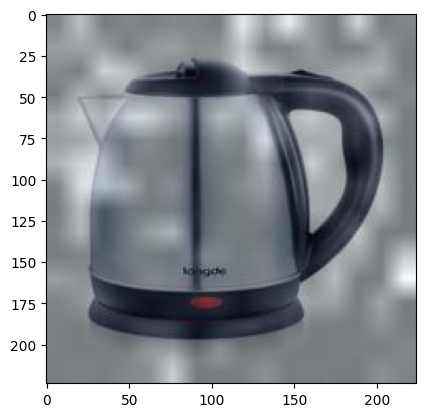

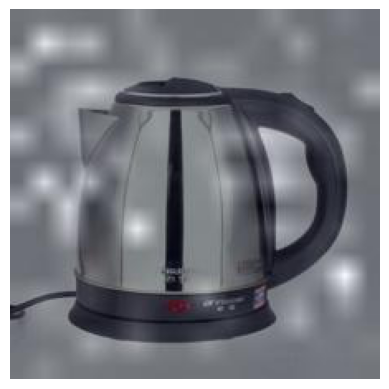

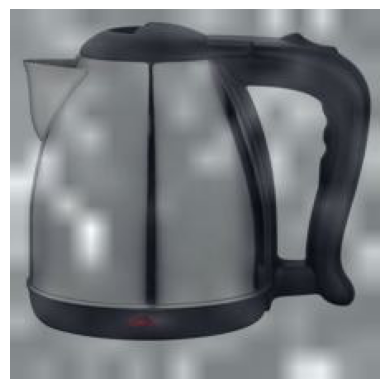

电水壶


In [ ]:
question = 'Answer with organized answers: What type of rose is in the picture? Mention some of its characteristics and how to take care of it ?'

# query_image = '/kaggle/input/flowers/flowers/rose/00f6e89a2f949f8165d5222955a5a37d.jpg'
# query_image = './projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/断肠草/4_33.12.jpg'
# query_image = "./projects/codebase/applications/RAG_with_open_source_multi_modal/concepts/红雀珊瑚/1_25.94.jpg"
query_image = "./projects/codebase/applications/RAG_with_open_source_multi_modal/test/电水壶/电水壶_5_34.4.jpg"
raw_image = Image.open(query_image)

# doc = collection_text.query(
#     query_embeddings=embedding_function(query_image),
#     n_results=3,
        
# )['documents'][0]

# print(doc)


plt.imshow(raw_image)
plt.show()
imgs = collection_images.query(query_uris=query_image, include=['data'], n_results=3)
for img in imgs['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

ret_res = imgs['uris'][0][0]
ret_con = ret_res.split('/')[-1].split('_')[0]
print(ret_con)

In [ ]:
imgs['uris'][0]

In [51]:
doc

['Olistat tablets are indicated for the treatment of obese or overweight patients (body mass index ≥ 24).',
 'LCD display is an active matrix LCD display driven by thin film transistors, which mainly stimulates liquid crystal molecules to produce dots, lines, and surfaces with the back light tube to form a picture. IPS, TFT, and SLCD are all subclasses of LCD. The working principle is to use the arrangement direction of liquid crystal molecules to change (modulate) the transmittance of the external light source under the action of an electric field, completing the electro-optical transformation. Then, using different excitations of R, G, and B primary color signals, the color reproduction in the time and space domains is completed through the red, green, and blue primary color filter film.',
 'Blueberry jam is a type of jam made from ingredients such as blueberries, which mainly include water, maltose, frozen blueberries, lemon, and granulated sugar. Blueberry jam can alleviate eye fat

In [33]:
prompt = """<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers , and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
{question} Use the following article as an answer source. Do not write outside its scope unless you find your answer better {article} if you thin your answer is better add it after document.<|im_end|>
<|im_start|>assistant
""".format(question='question', article=doc)

In [34]:
# prompt = """<|im_start|>system
# A chat between a curious human and an artificial intelligence assistant.
# The assistant is an exprt in flowers , and gives helpful, detailed, and polite answers to the human's questions.
# The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
# <|im_start|>user
# <image>
# Describe the image.<|im_end|>
# <|im_start|>assistant
# """

In [35]:
inputs = processor(prompt, raw_image, model, return_tensors='pt')

inputs['input_ids'] = inputs['input_ids'].to(model.device)
inputs['attention_mask'] = inputs['attention_mask'].to(model.device)

In [36]:
from transformers import TextStreamer

streamer = TextStreamer(tokenizer)

In [37]:
%%time
output = model.generate(**inputs, max_new_tokens=300, do_sample=True, top_p=0.5, temperature=0.2, eos_token_id=tokenizer.eos_token_id, streamer=streamer)

Setting `pad_token_id` to `eos_token_id`:50295 for open-end generation.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers, and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
question Use the following article as an answer source. Do not write outside its scope unless you find your answer better A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern A

In [38]:
print(tokenizer.decode(output[0]).replace(prompt, "").replace("<|im_end|>", ""))

<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers, and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.
<|im_start|>user
<image>
question Use the following article as an answer source. Do not write outside its scope unless you find your answer better A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern Africa. Spe

In [ ]:
plt.imshow(raw_image)
plt.show()
imgs = collection_images.query(query_uris=query_image, include=['data'], n_results=3)
for img in imgs['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
print('answer is ==> '+'A beautiful dark purple rose is in full bloom against a blurry background. The rose has a velvety texture and is surrounded by green leaves.')
